# Queshque Glacier OGGM - Draft 6 - 7/24/2024
#### Switched to altitude band flowlines from geometric centerlines

In [1]:
## IMPORTS ##
import sys
import os
import time
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import salem
import seaborn as sns
import concurrent.futures as cf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import date, datetime
import concurrent.futures as cf

# Local programs
sys.path.append('/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_python_scripts')
sys.path.append(os.getcwd())

import GlacierCalibration as GC
from GlacierCalibration import inversion_model_run, aggregate_gpr_data_clip

import inversion_calibration as IC

import oggm
from oggm import workflow, tasks, utils, cfg, graphics
#from oggm.core.climate import compute_ref_t_stars
#from oggm.core.inversion import find_inversion_calving, calving_flux_from_depth
#from oggm.core.massbalance import ScalarMassBalance
from oggm.core.flowline import FluxBasedModel
from oggm.core.massbalance import mb_calibration_from_scalar_mb, MonthlyTIModel, MultipleFlowlineMassBalance

2024-10-07 12:37:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-07 12:37:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-07 12:37:51: oggm.cfg: Multiprocessing: using all available processors (N=24)
/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


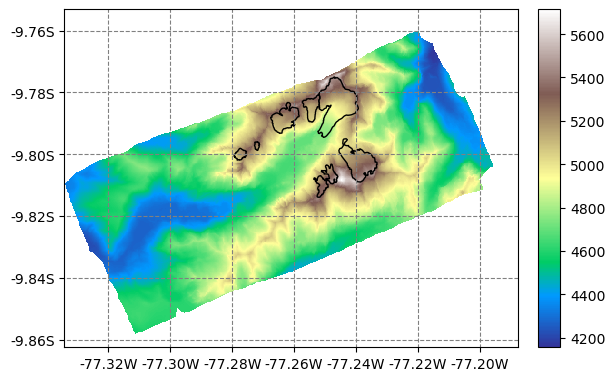

In [2]:
# Create gdir without calving
cfg.initialize(logging_level='ERROR') # supress print outputs
cfg.PATHS['working_dir'] = os.path.join(os.getcwd(),'Draft_6/')
OUTPUTS = os.getcwd()+'/Outputs/'
initialization_files = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_QQ_inputs/' #  '/home/tshutkin/OGGM/GPR_A_factor_calibration/initialization_files/'

inventory=gpd.read_file(initialization_files+'QQ_inventory_final_2008.shp')
intersects_path=initialization_files+'QQ_intersects_final_2008.shp'
intersects=gpd.read_file(intersects_path)

# Update RGI attributes    
# Names
inventory.loc[0,'Name'] = 'Queshque'
names=[]
for i,n in enumerate(inventory.Name.values):
    if type(n)!=str:
        n=f'Glacier_{i}'
    names.append(n)
inventory['Name']=names

# RGI Region 1
names=[]
for i,n in enumerate(inventory.O1Region.values):
    if type(n)!=str:
        n='16'
    names.append(n)
inventory['O1Region']=names

# RGI Region 2
names=[]
for i,n in enumerate(inventory.O2Region.values):
    if type(n)!=str:
        n='01'
    names.append(n)
inventory['O2Region']=names

# Term Type
inventory.loc[0,'TermType'] = 2 # for lake terminating glacier

cfg.set_intersects_db(intersects_path) # Set intersects file
cfg.PATHS['dem_file'] = initialization_files+'QQ_lidar_4326_10m.tif' # Use 2008 LiDAR DEM

data=xr.open_dataset(cfg.PATHS['dem_file'],engine='rasterio').to_dataarray()
data = xr.where(data>0,data,np.nan)
#data = xr.where(xr.open_rasterio(cfg.PATHS['dem_file'])>0,xr.open_rasterio(cfg.PATHS['dem_file']),np.nan)
grid = data.salem.grid
smap=salem.Map(grid=grid)
smap.set_data(data)
smap.set_plot_params(cmap='terrain')
smap.set_shapefile(inventory, facecolor='none',edgecolor='k')
smap.visualize();

In [3]:
OUTPUTS

'/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/Revisions/Outputs/'

In [4]:
## Static Parameters ##
cfg.PARAMS['border'] = 200 # For calibrating present day glaciers. CHANGE FOR MONTE CARLO
cfg.PARAMS['use_multiprocessing'] = True # Important for speed
cfg.PARAMS['use_multiple_flowlines'] = True # More realistic flowlines
cfg.PARAMS['hydro_month_sh']= 1 # Resolve hydro year ambiguity by using January as month 1..
cfg.PARAMS['use_rgi_area'] = False # calcuate areas from inventory
cfg.PARAMS['inversion_fs'] = 0 # Neglect sliding during inversion
cfg.PARAMS['fs'] = 0 # Neglect sliding in model runs
cfg.PARAMS['baseline_climate']='CUSTOM' # Use custom clim
# Set fixed gridcell resolution
# Important!
cfg.PARAMS['grid_dx_method']='fixed' 
cfg.PARAMS['fixed_dx']=10
cfg.PARAMS['use_kcalving_for_inversion'] =False
cfg.PARAMS['inversion_fs']=0
cfg.PARAMS['use_inversion_params_for_run']=True
cfg.PARAMS['store_fl_diagnostics'] = True

2024-10-07 12:37:56: oggm.cfg: PARAMS['border'] changed from `80` to `200`.
2024-10-07 12:37:56: oggm.cfg: Multiprocessing switched ON after user settings.
2024-10-07 12:37:56: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2024-10-07 12:37:56: oggm.cfg: PARAMS['use_rgi_area'] changed from `True` to `False`.
2024-10-07 12:37:56: oggm.cfg: PARAMS['baseline_climate'] changed from `GSWP3_W5E5` to `CUSTOM`.
2024-10-07 12:37:56: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2024-10-07 12:37:56: oggm.cfg: PARAMS['fixed_dx'] changed from `50.0` to `10`.
2024-10-07 12:37:56: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


In [5]:
gdirs = workflow.init_glacier_directories(inventory.loc[0:1],reset=False, force=False)
gdir=gdirs[0]
gdir

2024-10-07 12:37:56: oggm.workflow: Execute entity tasks [GlacierDirectory] on 2 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-16.02060
  Region: 16: Low Latitudes
  Subregion: 16-01: Low-latitude Andes              
  Name: Queshque
  Glacier type: Glacier
  Terminus type: Lake-terminating
  Status: Glacier or ice cap
  Area: 1.644906629634894 km2
  Lon, Lat: (-77.24380720543019, -9.784778186098325)
  Grid (nx, ny): (543, 615)
  Grid (dx, dy): (10.0, -10.0)

In [8]:
cfg.PARAMS['elevation_band_flowline_binsize'], cfg.PARAMS['flowline_dx'],gdir.grid.dx

(30.0, 2.0, 10.0)

In [7]:
# Geometry tasks - Using Altitude Band Flowlines
workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source='USER');

list_tasks = [tasks.process_dem,
              tasks.simple_glacier_masks,
              tasks.elevation_band_flowline,
              tasks.fixed_dx_elevation_band_flowline,
              tasks.compute_downstream_line,
              tasks.compute_downstream_bedshape,
                ]
    
for task in list_tasks:
    workflow.execute_entity_task(task, gdirs);

2024-07-26 10:34:19: oggm.workflow: Execute entity tasks [define_glacier_region] on 2 glaciers
2024-07-26 10:34:20: oggm.workflow: Execute entity tasks [process_dem] on 2 glaciers
2024-07-26 10:34:27: oggm.workflow: Execute entity tasks [simple_glacier_masks] on 2 glaciers
2024-07-26 10:34:33: oggm.workflow: Execute entity tasks [elevation_band_flowline] on 2 glaciers
2024-07-26 10:34:35: oggm.workflow: Execute entity tasks [fixed_dx_elevation_band_flowline] on 2 glaciers
2024-07-26 10:34:40: oggm.workflow: Execute entity tasks [compute_downstream_line] on 2 glaciers
2024-07-26 10:34:44: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 2 glaciers


#### Climate:

In [138]:
### THis is some draft 4 garbage...I hope ###
#############################################

# 1962 glacier center:
# cenlon, cenlat = -77.24555894158757, -9.787550525686378 # from QQ_1962.ipynb
# _cenlon, _cenlat = gdir.cenlon, gdir.cenlat # Store 2008 center point
# # Assign 1962 values to 2008 glacier
# gdir.cenlon = cenlon
# gdir.cenlat = cenlat
# (gdir.cenlon, gdir.cenlat) == (cenlon, cenlat)

In [8]:
# Climate Tasks ##
# CRU
cfg.PARAMS['baseline_climate']='CRU'
workflow.execute_entity_task(tasks.process_climate_data, [gdir], output_filesuffix='CRU')

# PISCO
cfg.PARAMS['baseline_climate'] ='CUSTOM'
cfg.PATHS['climate_file'] = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/PISCO/CH_PISCO_Clim_OGGM_ready_1.nc' # This filepath has the correct units on each datavar
workflow.execute_entity_task(tasks.process_climate_data, [gdir], output_filesuffix='PISCO')

# Combine and write "climate_historical" file
tasks.historical_delta_method(gdirs[0], ref_filesuffix='PISCO', hist_filesuffix='CRU',
                            output_filesuffix=None, ref_year_range=None,
                            delete_input_files=False, scale_stddev=True,
                            replace_with_ref_data=True)

2024-07-26 10:35:10: oggm.cfg: PARAMS['baseline_climate'] changed from `CUSTOM` to `CRU`.
2024-07-26 10:35:10: oggm.workflow: Execute entity tasks [process_climate_data] on 1 glaciers
/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/salem/datasets.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.sub_t = [_to_scalar(self._time[t0]),
/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/salem/datasets.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[0]
/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/salem/datasets.py:120: FutureWarning: S

In [9]:
with xr.open_dataset(gdir.get_filepath('climate_historical'),) as nc:
    hgt = nc.ref_hgt
print('The Reference Height For MB Model is:',hgt,'m')

The Reference Height For MB Model is: 5111.0 m


In [142]:
# Reset center lat/lon. This is important for gridded data tasks.
# gdir.cenlon = _cenlon
# gdir.cenlat = _cenlat
# (gdir.cenlon, gdir.cenlat) == (_cenlon, _cenlat)

### Calibrate Mass Balance Parameters using Geodetic Mass Balance (1962-2008) over 2008 Glacier Boundary

In [10]:
tasks.gridded_attributes(gdir) # Necessary

#### Calculate volume change

Unprojected Data Volume Loss: -36781693.75
Projected Data Volume Loss: -37173258.224398576

In [11]:
# Get Geodetic Mass Balance Raster
smb_path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/QQ_1962/Queshque Geodetic MB/QQ-DoD_2008mask.tif'
grids_path = gdir.get_filepath('gridded_data')
damb = salem.open_xr_dataset(smb_path)
damb = damb.where(damb.data>-1e10)

with salem.open_xr_dataset(grids_path) as dsg:
    # It is necessary to project data into meters rather than degrees
    dat = dsg.salem.transform(damb).data
    dsg.close()

damb_transform=dat.where(dat>-1e10)
dx = damb_transform.x.values[101]-damb_transform.x.values[100] # Pixel resolution = 10m

print('Unprojected Data Volume Loss:',np.nansum(damb.data)*dx**2)
print('Projected Data Volume Loss:',np.nansum(damb_transform)*dx**2)


Unprojected Data Volume Loss: -36781693.75
Projected Data Volume Loss: -37173258.224398576


/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


#### Calculate Specific Mass Balance

In [12]:
S0= gdir.rgi_area_m2
S1=1.37 # What is this value?
y0=1962
y1=2008 # SHould this be 2008 or 2009?
#dV=-150e6 # m^3 ice # Can use this value form Huh or my new value as calculated above (considerably less mass change)
dV= np.nansum(damb_transform)*dx**2 # multiplied by 100 to account for pixel resolution
# convert to: kg m-2 yr-1
smb = dV*cfg.PARAMS['ice_density']/(S0)/(y1-y0) # Ice mass loss divided by surface area in m2, divided by length of time
smb # kg m-2 yr-1

-442.1545060371504

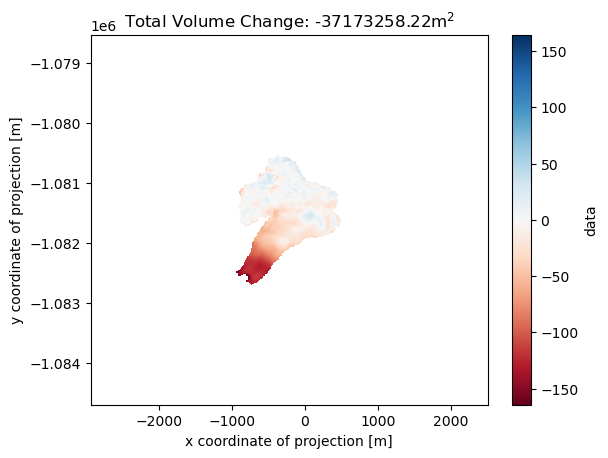

In [13]:
f,ax=plt.subplots()
damb_transform.plot(ax=ax,cmap='RdBu');
ax.set_title(f'Total Volume Change: {round(np.nansum(damb_transform.data)*100,2)}m$^2$');


### Add data to gridded vars

In [14]:
from oggm.utils import ncDataset

In [15]:
grids_path = gdir.get_filepath('gridded_data') # gridded data filepath
with xr.open_dataset(os.path.join(os.getcwd(),'millan_data.nc')) as ds_millan: # Millan data (already downloaded and processed to this glacier grid)
    ds_millan = ds_millan.where(ds_millan.glacier_mask) # clip to 2008 glacier extent

# Define Data
ref_dh = damb_transform.data
damb_mwe_per_yr = (damb_transform ) * cfg.PARAMS['ice_density'] / 1000 / (y1-y0) # convert to mwe per year
damb_mwe_per_yr = damb_mwe_per_yr.data
millan_v = ds_millan.millan_v.data

In [16]:
# Add to gridded data file
with ncDataset(grids_path, 'a') as nc:

    # Reference Surface Height Change
    vn = 'ref_dh'
    if vn in nc.variables:
        v = nc.variables[vn]
    else:
        v = nc.createVariable(vn, 'f4', ('y', 'x', ))
    v.units = 'm'
    v.long_name = 'Glacier Surface Height Change Reference Data (1962-2008)'
    v[:] = ref_dh

    # Reference Mass Balance (mwe per year)
    vn = 'ref_mb'
    if vn in nc.variables:
        v = nc.variables[vn]
    else:
        v = nc.createVariable(vn, 'f4', ('y', 'x', ))
    v.units = 'm.w.e. a$^-$$^1$'
    v.long_name = 'Glacier Mass Balance (1962-2008)'
    v[:] = damb_mwe_per_yr
    
    # Millan velocity
    vn = 'millan_v'
    if vn in nc.variables:
        v = nc.variables[vn]
    else:
        v = nc.createVariable(vn, 'f4', ('y', 'x', ))
    v.units = 'ma$^-$$^1$'
    v.long_name = 'Glacier Surface Velocity (2017-2088)'
    v.source = 'Millan et al., 2022'
    v[:] = millan_v
    

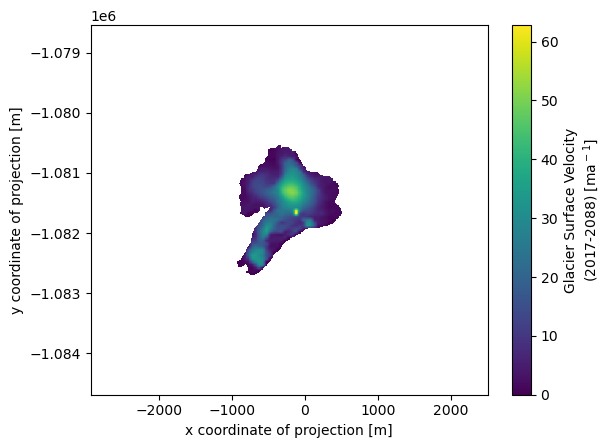

In [17]:
with xr.open_dataset(grids_path) as ds:
    ds.millan_v.plot()
    ds.close()

#### Calibrate Mass Balance Model Parameters

In [18]:
smb

-442.1545060371504

In [19]:
cfg.PARAMS['melt_f']

5.0

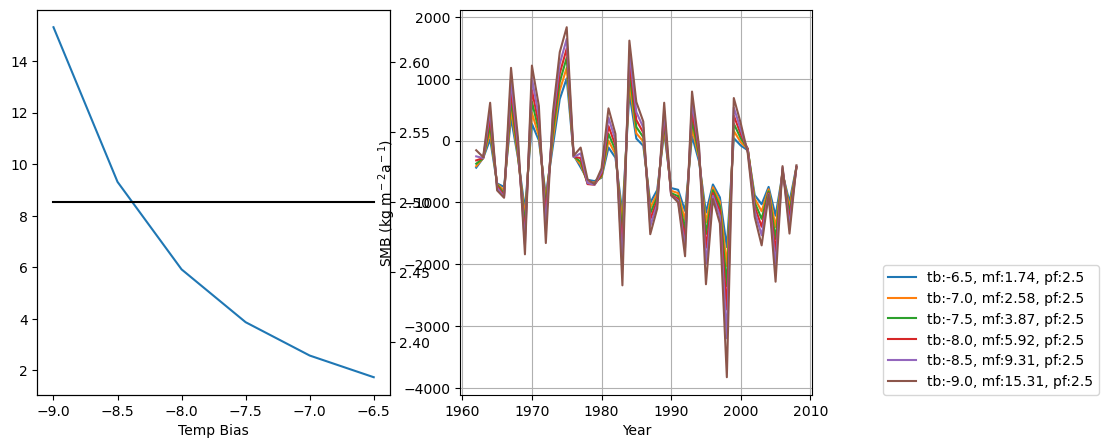

In [20]:
# Calibrate Mass Balance Parameters
gdir=gdirs[0]
fls=gdir.read_pickle('inversion_flowlines')
years=np.arange(y0,y1+1)
f,(ax,ax2)=plt.subplots(1,2,figsize=(10,5))
tt=[]
pp=[]
melt_fs=[]
prcp_fs=[]
temp_bs=[]
mean_elas=[]
# cols = ['rgi_id',
#         'bias',
#         'melt_f',
#         'prcp_fac',
#         'temp_bias',
#         'reference_mb',
#         'reference_mb_err',
#         'reference_period',
#         'baseline_climate_source']
mbdf=pd.DataFrame()
temp_biases=np.arange(6.5,9.1,0.5)*-1
for tb in temp_biases:
    try:
        mb_params = mb_calibration_from_scalar_mb(gdir, ref_mb=smb, ref_mb_years = (y0,y1+1),
                                    overwrite_gdir=True,
                                    prcp_fac=2.5,
                                    temp_bias = tb,
                                    prcp_fac_max = 10.0,
                                    prcp_fac_min = 0.1,
                                    melt_f_min = 1.5,
                                    calibrate_param1='melt_f',
                                    #calibrate_param3='temp_bias',
                                    calibrate_param2='prcp_fac'
                                     )
        #_=mb_params.pop('Unnamed: 0')
        global_params=mb_params.pop('mb_global_params')
        mbdf[f'{tb}']=mb_params
        melt_fs.append(mb_params['melt_f'])
        prcp_fs.append(mb_params['prcp_fac'])
        temp_bs.append(mb_params['temp_bias'])

        mbmod=MonthlyTIModel(gdir)
        smb1=mbmod.get_specific_mb(fls=fls, year=np.arange(y0,y1+1))
        elas=mbmod.get_ela(year=np.arange(y0,y1+1))
        mean_elas.append(np.mean(elas))
        temps=[]
        prcps=[]
        for yr in np.arange(y0,y1+1):
            temp,_,prcp,_=mbmod.get_annual_climate(heights=[5000], year=yr)
            temps.append(temp)
            prcps.append(prcp)
        tt.append(temps)
        pp.append(prcps)
        ax2.plot(np.arange(y0,y1+1),smb1,
                 label=f'tb:{round(mb_params['temp_bias'],1)}, mf:{round(mb_params['melt_f'],2)}, pf:{round(mb_params['prcp_fac'],1)}')

    
    except RuntimeError:
        #mb_cals.append(np.nan)
        melt_fs.append(np.nan)
        prcp_fs.append(np.nan)
        temp_bs.append(np.nan)


ax.plot(temp_bs,melt_fs);
ax.set_xlabel('Temp Bias');
ax1=ax.twinx()
ax1.plot(temp_bs,prcp_fs,color='k');
ax2.legend(loc=(1.2,0.));
ax2.grid()
ax2.set_ylabel('SMB (kg m$^-$$^2$a$^-$$^1$)');
ax2.set_xlabel('Year');



In [21]:
# Save calibrations
path = os.path.join(OUTPUTS,'mb_calibrations.csv')
mbdf.T.to_csv(path)

In [22]:
path = os.path.join(OUTPUTS,'mb_calibrations.csv')
df_raw=pd.read_csv(path, index_col=None)
df_raw.head(2)

Unnamed: 0          rgi_id  bias    melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0  1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0  2.577051       2.5       -7.0   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...

In [23]:
# Store Global MB Parameters
global_params={'temp_default_gradient': -0.0065,
                     'temp_all_solid': 0.0,
                     'temp_all_liq': 2.0,
                     'temp_melt': -1.0}

In [24]:
mbp=df_raw.iloc[3].to_dict() # Use intermediate model for first pass
mbp['mb_global_params']=global_params
cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
gdir.write_json(mbp,'mb_calib') # Update MB calibration data


2024-07-26 10:37:28: oggm.cfg: PARAMS['geodetic_mb_period'] changed from `2000-01-01_2020-01-01` to `1962-01-01_2009-01-01`.


In [25]:
#tasks.apparent_mb_from_any_mb(gdir) 

list_talks = [
    tasks.apparent_mb_from_any_mb,
    tasks.prepare_for_inversion,  # This is a preprocessing task
    tasks.mass_conservation_inversion,  # This does the actual job
    tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
    #tasks.init_present_time_glacier,
    #tasks.gridded_attributes # Already run above
    #tasks.distribute_thickness_per_altitude
    ]
        
for task in list_talks:
    workflow.execute_entity_task(task, [gdir])


2024-07-26 10:37:38: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 10:37:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 10:37:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 10:37:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


## Flow Model Calibration

In [26]:

with xr.open_dataset(gdir.get_filepath('gridded_data')) as nc:
    topo = nc.topo_smoothed

#### Prepare Calibration and Validation Observations

In [32]:
# Prepare GPR Data
# Examine 2014 GPR Data
gpr_path=initialization_files+'Queshque_GPR_2014.shp'
df = salem.read_shapefile(gpr_path)
coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy
all_coords = df.index.to_list()
Cal_coords, Val_coords = train_test_split(all_coords, test_size=0.5, random_state=42)
Cal = df.loc[Cal_coords]
Val = df.loc[Val_coords] 

## CALIBRATION DATA ##
# Aggregate GPR by Gridcell Resolution
df_agg = Cal[['lon', 'lat','x','y', 'profundida','altura_sup','altura_Bed']].copy()
ii, jj = gdir.grid.transform(df_agg['lon'], df_agg['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = [int(i) for i in ii]
df_agg['j'] = [int(j) for j in jj]
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean().copy()
# 2008 Surface Elevation
surf = xr.open_dataset(gdir.get_filepath('gridded_data')).topo # Get surface topo from dem
df_agg['surf_2008'] = surf.interp(x=('z', df_agg.x), y=('z', df_agg.y))
df_agg['delta_surf']= df_agg.altura_sup-df_agg.surf_2008
df_agg['thk_2008']= df_agg.surf_2008-df_agg.altura_Bed

## VALIDATION DATA ##

# Aggregate  validation GPR to Gridcell resolution
df_Val = Val[['lon', 'lat','x','y', 'profundida','altura_sup','altura_Bed']].copy()
ii, jj = gdir.grid.transform(df_Val['lon'], df_Val['lat'], crs=salem.wgs84, nearest=True)
df_Val['i'] = [int(i) for i in ii]
df_Val['j'] = [int(j) for j in jj]
# We trick by creating an index of similar i's and j's
df_Val['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_Val = df_Val.groupby('ij').mean().copy()

df_Val['surf_2008'] = surf.interp(x=('z', df_Val.x), y=('z', df_Val.y))
df_Val['delta_surf']= df_Val.altura_sup-df_Val.surf_2008
df_Val['thk_2008']= df_Val.surf_2008-df_Val.altura_Bed

In [45]:
## Some Functions ##
def to_minimize(x, gdir, observations, varname, return_map=False):

    # # Delete Glacier Diagnostics file
    # os.remove(gdir.get_filepath('diagnostics'))
    
    default_glen_a=2.4e-24
        # list_talks = [
        #         tasks.mass_conservation_inversion,  # This does the actual job
        #         tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
        #         tasks.init_present_time_glacier
        # ]
        # for task in list_talks:
        #     workflow.execute_entity_task(task, gdirs[0])
            
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as model: # Get dimensions from glacier directory
        da,v = IC.map_dist_thk(gdir, ds=model, glen_a=default_glen_a*x, fs=None, varname_suffix='')
    
    if return_map:
        mfl=gdir.read_pickle('inversion_output')[-1]
        thickness= mfl['thick']
        thickness=thickness[thickness>0].mean()
        return da, v, thickness, mfl
    else:
        ME = IC.error_eval(da, observations, varname)[-1] # take mean error (since sign changes)
        print(f'Mean Error: {ME}')
        return ME
    
def calibrate_flow_model(gdir, observations, varname, a, b, min_slope):
    """
    calibrates creep parameter of OGGM flow model using point observations.
    gdir - oggm glacier directory
    observations - dataframe of point observations (e.g., GPR thickness values with cooridnates)
    varname - variable in observations to calibrate thickness agianst
    a, b - the min (a) and max (b) bounding values for the a-factor used in calibration
    """
    from scipy.optimize import brentq
    import time
    

    cfg.PARAMS['min_slope'] = min_slope # avoid unatrual overdeepening
    start_time = time.time()
    
    optim_param = brentq(to_minimize, a, b, args=(gdir, observations, varname))
    print("--- %s seconds ---" % (time.time() - start_time))
    return optim_param

    # Prepare for inversion
    # list_talks = [
    #     tasks.apparent_mb_from_any_mb,  # This is a preprocessing task
    #     tasks.prepare_for_inversion
    # ]
    # def to_minimize(x):
    #     # list_talks = [
    #     #         tasks.mass_conservation_inversion,  # This does the actual job
    #     #         tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
    #     #         tasks.init_present_time_glacier
    #     # ]
    #     # for task in list_talks:
    #     #     workflow.execute_entity_task(task, gdirs[0])
            
    #     with xr.open_dataset(gdir.get_filepath('gridded_data')) as model: # Get dimensions from glacier directory
    #         da,v = IC.map_dist_thk(gdir, ds=model, glen_a=default_glen_a*x, fs=None, varname_suffix='')
         
    #     ME = IC.error_eval(da, observations, varname)[-1] # take mean error (since sign changes)
    #     print(f'Mean Error: {ME}')
    #     return ME
        
    # def to_minimize(x):
    #     # Recalculate Inversion
    #     list_talks = [
    #              tasks.prepare_for_inversion,  # This is a preprocessing task
    #              tasks.mass_conservation_inversion,  # This does the actual job
    #              tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
    #              tasks.distribute_thickness_per_altitude
    #                 ]
        
    #     for task in list_talks:
    #         workflow.execute_entity_task(task, gdir)
            
    #     with xr.open_dataset(gdir.get_filepath('gridded_data')) as model: # Get dimensions from glacier directory
    #         da = model.distributed_thickness
         
    #     ME = IC.error_eval(da, observations, varname)[-1] # take mean error (since sign changes)
    #     print(f'Mean Error: {ME}')
    #     return ME
        

        

In [47]:
# Delete Glacier Diagnostics file
os.remove(gdir.get_filepath('diagnostics'))

In [48]:
cfg.PARAMS['use_kcalving_for_inversion'] =False
cfg.PARAMS['inversion_fs']=0
cfg.PARAMS['use_inversion_params_for_run']=True

default_glen_a=2.4e-24
min_slope = 7.5
var = 'thk_2008' # calibrate against derived thickness measurements
fs=0

# Create Table to Store data
df=df_raw.copy()

global_params={'temp_default_gradient': -0.0065,
                     'temp_all_solid': 0.0,
                     'temp_all_liq': 2.0,
                     'temp_melt': -1.0}

empty = np.ones_like(df.temp_bias.values)*np.nan
df['Creep_Param']= empty
#df['Cal_ME']=empty
df['A_Factor']=empty
# df['Cal_RMSE']=empty
df['Val_ME']=empty
df['Val_MAE']=empty
df['Val_RMSE']=empty
df['Inversion_Volume']=empty
df['Mean_Thickness_Below_5100m']=empty
df['Flowline_Thickness']=empty
df['apparent_mb_from_any_mb_residual']=empty

for i in range(len(df_raw)): #
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    # This should re-write gdir diagnostics file to avoid error
    mb_params = mb_calibration_from_scalar_mb(gdir, ref_mb=smb, ref_mb_years = (y0,y1+1),
                                    overwrite_gdir=True,
                                    prcp_fac=2.5,
                                    temp_bias = mbp['temp_bias'],
                                    prcp_fac_max = 5.0,
                                    prcp_fac_min = 0.1,
                                    melt_f_min = 1.5,
                                    calibrate_param1='melt_f',
                                    #calibrate_param3='temp_bias',
                                    #calibrate_param2='prcp_fac'
                                     )
    # Sanity Check
    assert np.isclose(mb_params['melt_f'], mbp['melt_f'],rtol=1e-05, atol=1e-08, equal_nan=False)
    assert np.isclose(mb_params['temp_bias'], mbp['temp_bias'],rtol=1e-05, atol=1e-08, equal_nan=False)

    # Continue
    gdir.write_json(mbp,'mb_calib') # Overwrite MB calibration parameters
    workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdir)
    mb_res = gdir.get_diagnostics()['apparent_mb_from_any_mb_residual']

    # Delete Glacier Diagnostics file
    os.remove(gdir.get_filepath('diagnostics'))

    # Now calibrate Creep Parameter
    A_fac = calibrate_flow_model(gdir, df_agg, var, 0.1, 10, min_slope) # change min slope to 7.5?
    opt_A = A_fac * default_glen_a

    # Validate Results
    da,v,thk,fls = to_minimize(A_fac, gdir, df_Val, '', return_map=True) # Use to_minimize() function to recompute thickness and volume using calibrated A-factor
    mean_thk=float(da.where(topo<=df_Val.surf_2008.max()).mean(dim=('x','y')).values)
    error_Val=IC.error_eval(da, df_Val, 'thk_2008', return_df=True)
    df_error = error_Val[-1] # Point by point thickness error
    df_error.to_csv(OUTPUTS+f'val_error_tb{mbp['temp_bias']}.csv')
    # cfg.PARAMS['inversion_glen_a']=opt_A
    # cfg.PARAMS['glen_a']=opt_A
    # list_talks = [
    #      tasks.prepare_for_inversion,  # This is a preprocessing task
    #      tasks.mass_conservation_inversion,  # This does the actual job
    #      tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
    #      tasks.distribute_thickness_per_altitude
    #          ]
    # for task in list_talks:
    #     workflow.execute_entity_task(task, [gdir])
        
    # with xr.open_dataset(gdir.get_filepath('gridded_data')) as model:
    #     da = model.distributed_thickness

    
    # Store Data
    df.loc[i,'Inversion_Volume']=v
    df.loc[i,'Mean_Thickness_Below_5100m']=mean_thk
    df.loc[i,'Flowline_Thickness']=thk
    df.loc[i,'apparent_mb_from_any_mb_residual'] = mb_res
    
    cols = ['Creep_Param','A_Factor','Val_ME','Val_MAE','Val_RMSE']
    data = [opt_A, A_fac, error_Val[-2], error_Val[-3], error_Val[-4]] 
    for j,col in enumerate(cols):
        df.loc[i,col]=data[j]

    # Get Some Additional Information 
    tasks.compute_inversion_velocities(gdir,with_sliding=False,
                                       filesuffix=f'tb{mbp['temp_bias']}') # The output is written in 'inversion_output.pkl' in m yr-1 



2024-07-26 12:30:54: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:30:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:30:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:30:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:30:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:30:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:30:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 55.51147121027056


2024-07-26 12:31:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -29.259112956660555


2024-07-26 12:31:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:31:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -24.365803565314195


2024-07-26 12:31:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:31:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -15.647483400121125


2024-07-26 12:31:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:31:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -6.134252436718322


2024-07-26 12:31:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 3.9941710220140036


2024-07-26 12:31:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:31:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.9367994921682516


2024-07-26 12:31:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.13023107822040322


2024-07-26 12:31:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 0.00022883293235595104


2024-07-26 12:31:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -1.0717944068586725e-06


2024-07-26 12:31:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:31:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -8.76184662426128e-12


2024-07-26 12:31:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:31:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:31:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 5.055288324396743e-12
--- 61.443984508514404 seconds ---


2024-07-26 12:32:01: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:32:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 63.14022636495922


2024-07-26 12:32:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -26.332356106444646


2024-07-26 12:32:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -22.166015088319813


2024-07-26 12:32:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -13.18067125093669


2024-07-26 12:32:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -3.387648737275598


2024-07-26 12:32:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 1.7948956587701825


2024-07-26 12:32:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.22711525473673327


2024-07-26 12:32:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.01402143444072167


2024-07-26 12:32:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 5.412377923223806e-06


2024-07-26 12:32:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:32:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -2.724608547554587e-09


2024-07-26 12:32:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:32:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:32:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 4.327039424951992e-14


2024-07-26 12:33:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -1.0714729323220746e-11
--- 61.790096044540405 seconds ---


2024-07-26 12:33:08: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:33:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:33:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:13: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 69.72209853724317


2024-07-26 12:33:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -23.738833475137707


2024-07-26 12:33:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:33:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -20.12253500636882


2024-07-26 12:33:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:33:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -10.900947512612744


2024-07-26 12:33:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.8773032596953572


2024-07-26 12:33:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:33:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 0.3325466999745583


2024-07-26 12:33:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:33:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.010642465067236637


2024-07-26 12:33:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.00012609534650464884


2024-07-26 12:33:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:33:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 4.3566837271255786e-10


2024-07-26 12:33:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:33:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 1.3879183061166768e-14


2024-07-26 12:34:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:34:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -8.649180314705926e-12
--- 56.2804913520813 seconds ---


2024-07-26 12:34:10: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:34:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:34:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 75.21047997102008


2024-07-26 12:34:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -21.39632884626645


2024-07-26 12:34:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:34:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -18.225582020225424


2024-07-26 12:34:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -8.826062073130958


2024-07-26 12:34:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 1.4767248114492382


2024-07-26 12:34:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.6088539241349137


2024-07-26 12:34:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:34:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 0.005501471288287843


2024-07-26 12:34:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 0.000346907012470712


2024-07-26 12:34:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:34:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:34:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:34:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 2.661736615724683e-07


2024-07-26 12:35:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 1.2999079570582193e-11


2024-07-26 12:35:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -4.0821126650490495e-14
--- 55.84366774559021 seconds ---


2024-07-26 12:35:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:11: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:35:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 80.87499296420039


2024-07-26 12:35:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -19.235558211282363


2024-07-26 12:35:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -16.472345909893228


2024-07-26 12:35:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -6.897472384607971


2024-07-26 12:35:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 3.5793502725755526


2024-07-26 12:35:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.9235337417136013


2024-07-26 12:35:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.11078349262428955


2024-07-26 12:35:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 0.00034230303262752196


2024-07-26 12:35:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:35:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:35:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:35:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -1.37128890496594e-06


2024-07-26 12:36:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -1.6914642038897242e-11


2024-07-26 12:36:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 5.7149577310686696e-15


2024-07-26 12:36:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -5.999072772556083e-12
--- 61.274312019348145 seconds ---


2024-07-26 12:36:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:18: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2024-07-26 12:36:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 85.6500320989841


2024-07-26 12:36:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -17.24419961474662


2024-07-26 12:36:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -14.812894412641077


2024-07-26 12:36:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -5.098042339381591


2024-07-26 12:36:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: 4.1902813032227355


2024-07-26 12:36:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -0.7342748783941317


2024-07-26 12:36:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:36:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -0.10121330673311679


2024-07-26 12:36:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:36:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:36:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 0.00028694351279177086


2024-07-26 12:37:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:37:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:37:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: -1.0521280036916177e-06


2024-07-26 12:37:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:37:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -1.0894342280482903e-11


2024-07-26 12:37:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:37:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:37:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


Mean Error: -2.0410563325245248e-14


2024-07-26 12:37:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-07-26 12:37:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-07-26 12:37:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-07-26 12:37:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


Mean Error: 5.1793845494142344e-12
--- 60.96565008163452 seconds ---


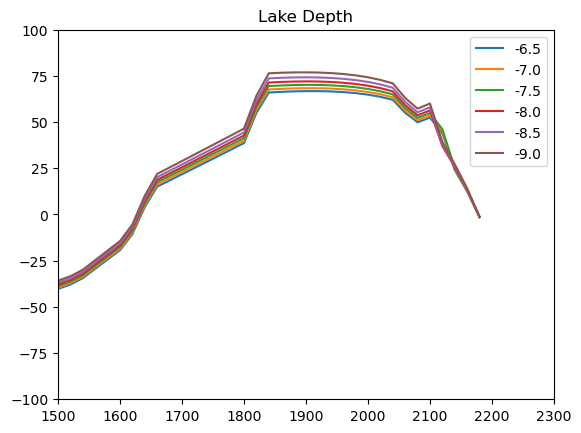

In [49]:
wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 

for i in range(len(df_raw)): #
    tb=df_raw.iloc[i].temp_bias
    fls=gdir.read_pickle('inversion_output',filesuffix=f'tb{tb}')[0]
    thk=fls['thick']
    surf=fls['hgt']
    bed=surf-thk
    dis = fls['dx']*np.arange(len(thk))
    lake_depth =  wl_cal - bed
    plt.plot(dis,lake_depth,label=tb)
   # plt.plot(dis,surf)
    
plt.xlim([1500,2300]) 
plt.ylim([-100,100]) 
plt.title('Lake Depth');
plt.legend();

#### Compare to Previous Minimal Survey (2009)

In [33]:
gpr_path=initialization_files+'Queshque_GPR_2009.shp' # Access GPR
df_09=salem.read_shapefile(gpr_path)

# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df_09['lon'].values, df_09['lat'].values)
df_09['x'] = xx
df_09['y'] = yy

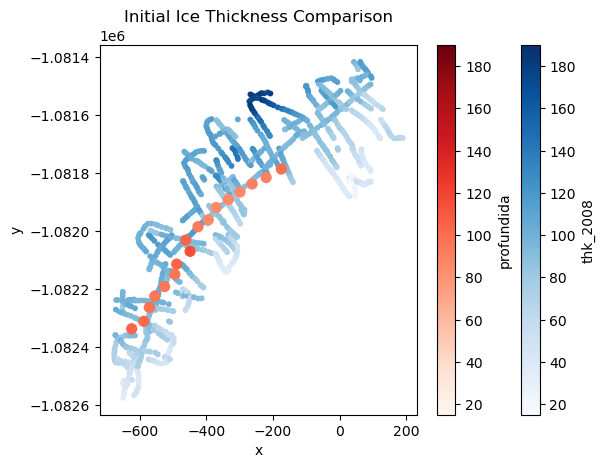

In [34]:
f,ax = plt.subplots()
ax.set_title('Initial Ice Thickness Comparison');
var='thk_2008'
df_agg.plot.scatter(x='x', y='y', c=var, cmap='Blues', s=10, vmin=15,vmax=190, ax=ax);
df_09.plot.scatter(x='x', y='y', c='profundida', cmap='Reds', s=50, vmin=15,vmax=190, ax=ax);

In [35]:
# Calculate Distance Matrix Between Two Datasets
def distance(a,b):
    from math import sqrt
    d=(a.x-b.x)**2 + (a.y-b.y)**2
    return sqrt(d)

def D_Matrix(A,B):
    D=np.zeros((len(A),len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            a=A.iloc[i]
            b=B.iloc[j]
            D[i,j]=distance(a,b)
    return D

In [36]:
# Calculate distance matrix
dist = D_Matrix(df_09,df_Val)

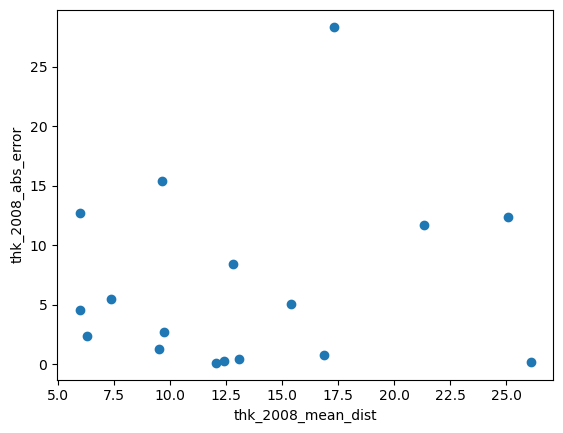

In [37]:
# Find thickness values from the extensive survey that correspond to each point from the 2009 survey 
# using the most proximal points

n=4 # number of nearest neighbors
vals_ag=[]
distances=[]
for i in range(len(df_09)):
    keys=dist[i].argsort()[:n] # find indeces of n smallest elements
    distances.append(np.mean(dist[i][keys])) # Record mean distance of 2009 survey point to n closest 2014 survey points
    vals_ag.append(np.mean(df_Val.iloc[keys].thk_2008)) # take average thickness value 
    
df_09['thk_2008']=vals_ag
df_09['thk_2008_mean_dist'] = distances
df_09['thk_2008_error'] = df_09.thk_2008 - df_09.profundida
df_09['thk_2008_abs_error'] = abs(df_09.thk_2008 - df_09.profundida)
plt.scatter(df_09.thk_2008_mean_dist,df_09.thk_2008_abs_error);
plt.xlabel('thk_2008_mean_dist')
plt.ylabel('thk_2008_abs_error');

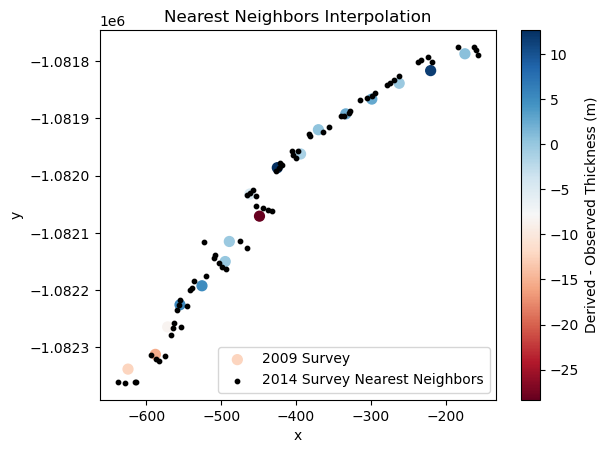

In [38]:
# Make sure this works
n=4
f,ax = plt.subplots()
ax.set_title('Nearest Neighbors Interpolation');

# Centerlines
#fls_proj.plot(ax=ax,color='pink',label='Glacier Flowline');

# GPR points
var='thk_2008_error'
df_09['Derived - Observed Thickness (m)'] = df_09[var].values
hh=df_09.plot.scatter(x='x', y='y', c='Derived - Observed Thickness (m)', cmap='RdBu', s=50, ax=ax,label='2009 Survey')
for point in range(len(df_09)):
    keys=dist[point].argsort()[:n]
    if point==0:
        df_Val.iloc[keys].plot.scatter(x='x', y='y', c='k', s=10, ax=ax, label='2014 Survey Nearest Neighbors');
    else:
        df_Val.iloc[keys].plot.scatter(x='x', y='y', c='k', s=10, ax=ax)
ax.legend(loc='lower right');

In [77]:
path = os.path.join(OUTPUTS, 'GPR_thickness_comparison.png')
f.savefig(path)

In [67]:
df_09['Derived - Observed Thickness (m)'].sort_values()

14   -28.344026
1    -15.425243
0    -12.363558
9     -8.400307
15    -4.537635
2     -1.237963
6     -0.233882
13    -0.202789
12     0.117690
3      0.466606
8      0.729522
4      2.327281
5      2.728086
11     5.081472
10     5.475495
7     11.666428
16    12.676237
Name: Derived - Observed Thickness (m), dtype: float64

In [68]:
mask = np.where(df_09['Derived - Observed Thickness (m)'].values> -20)
print('Ice Thickness Error: Minimal Survey (2009) vs. Derived 2008 Thickness')
print('MAE |',np.abs(df_09['Derived - Observed Thickness (m)'].values[mask]).mean() ,'m')#0.054700746867731465
print('RMSE |',(df_09['Derived - Observed Thickness (m)'].values[mask]**2).mean()**0.5,'m' )
print('ME |', df_09['Derived - Observed Thickness (m)'].values[mask].mean(),'m' )

Ice Thickness Error: Minimal Survey (2009) vs. Derived 2008 Thickness
MAE | 5.229387055594955 m
RMSE | 7.2878183499606735 m
ME | -0.07078497075484336 m


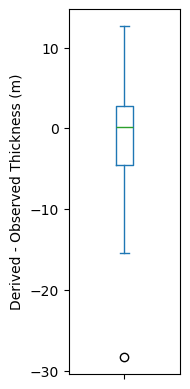

In [88]:
f,ax=plt.subplots(figsize=(2,4))
df_09['Derived - Observed Thickness (m)'].plot.box(ax=ax);
ax.set_ylabel('Derived - Observed Thickness (m)');
ax.set_xticks([1],[""]);
f.tight_layout()
path = os.path.join(OUTPUTS, 'derived_min_obs_thick_boxplot.png')
f.savefig(path)

In [18]:
df_09.profundida.mean(),df_09.thk_2008.mean()

(95.94117647058823, 94.25143910371315)

#### Velocity

In [50]:
# Add some velocity Data
uu_surf=[]
uu_max=[]
uu_min=[]
for tb in df.temp_bias:
    fls=gdir.read_pickle('inversion_output',filesuffix=f'tb{tb}')[0]
    fls['dis_on_line']=np.arange(0,len(fls['hgt']))
    fls['bed_h']=fls['hgt']-fls['thick']
    uu_surf.append(fls['u_surface'].mean())
    uu_max.append(fls['u_surface'].max())
    uu_min.append(fls['u_surface'].min())
df['mean_u_surf_m_per_a']=uu_surf
df['max_u_surf_m_per_a']=uu_max
df['min_u_surf_m_per_a']=uu_min
df.head(2)

Unnamed: 0          rgi_id  bias    melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0  1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0  2.577051       2.5       -7.0   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  ...    Val_ME  \
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.290560   
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.294803   

     Val_MAE   Val_RMSE  Inversion_Volume  Mean_Thickness_Below_5100m  \
0  24.013545  34.518850      8.096665e+07                   73.592180   
1  24.179261  34.799697      8.020542e+07                   73.576989   

   Flowline_Thickness  apparent_mb_from_any_mb_residual  mean_u_surf_m_per_a  \
0           66.620696                        442.154506            16.809282   
1           66.680584                        442.154506            21.340836   

   max_u_surf_m_per_a  min_u_surf_m_per_a  
0           26.949752            2.181344  
1           34.438708            2.326818  

[2 rows x 22 columns]

In [51]:
# Save Calibration Results
df.to_csv(OUTPUTS+'calibration_results.csv')

In [7]:
# Load CAlibration REsutls
df=pd.read_csv(OUTPUTS+'calibration_results.csv',index_col=0)
df

Unnamed: 0          rgi_id  bias     melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0   1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0   2.577051       2.5       -7.0   
2        -7.5  RGI60-16.02060     0   3.870401       2.5       -7.5   
3        -8.0  RGI60-16.02060     0   5.919010       2.5       -8.0   
4        -8.5  RGI60-16.02060     0   9.313196       2.5       -8.5   
5        -9.0  RGI60-16.02060     0  15.313471       2.5       -9.0   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   
2   -442.154506               NaN  1962-01-01_2009-01-01   
3   -442.154506               NaN  1962-01-01_2009-01-01   
4   -442.154506               NaN  1962-01-01_2009-01-01   
5   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  ...    Val_ME  \
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.290560   
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.294803   
2  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.299645   
3  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.303545   
4  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.309351   
5  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.316588   

     Val_MAE   Val_RMSE  Inversion_Volume  Mean_Thickness_Below_5100m  \
0  24.013545  34.518850      8.096665e+07                   73.592180   
1  24.179261  34.799697      8.020542e+07                   73.576989   
2  24.374505  35.128244      7.948764e+07                   73.564689   
3  24.555124  35.415304      7.880863e+07                   73.547654   
4  24.809969  35.822816      7.811494e+07                   73.536119   
5  25.142728  36.342371      7.741884e+07                   73.525558   

   Flowline_Thickness  apparent_mb_from_any_mb_residual  mean_u_surf_m_per_a  \
0           66.620696                        442.154506            16.809282   
1           66.680584                        442.154506            21.340836   
2           66.804331                        442.154506            26.247678   
3           66.837857                        442.154506            31.515443   
4           67.069114                        442.154506            37.285912   
5           67.408681                        442.154506            43.605711   

   max_u_surf_m_per_a  min_u_surf_m_per_a  
0           26.949752            2.181344  
1           34.438708            2.326818  
2           42.814114            2.437661  
3           52.575029            2.537145  
4           63.523590            2.622666  
5           75.576479            2.701705  

[6 rows x 22 columns]

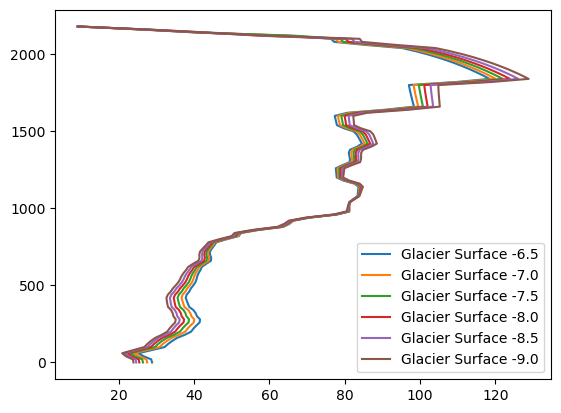

In [11]:
# uu_surf=[]
# uu_max=[]
# uu_min=[]
f,ax=plt.subplots()
for tb in df.temp_bias:
    fls=gdir.read_pickle('inversion_output',filesuffix=f'tb{tb}')[0]
    fls['dis_on_line']=np.arange(0,len(fls['hgt'])) *fls['dx']
    fls['bed_h']=fls['hgt']-fls['thick']
    ax.plot(fls['thick'],fls['dis_on_line'],label=f'Glacier Surface {tb}')
    # ax.fill_between(x=fls['dx']*fls['dis_on_line'],y1=fls['hgt'],y2=fls['bed_h'],color='aliceblue')
    # ax.plot(fls['dx']*fls['dis_on_line'],fls['bed_h'],color='brown', label='Glacier Bed')
    # ax.fill_between(x=fls['dx']*fls['dis_on_line'],y1=fls['bed_h'],y2=4500,color='tan')
#     uu_surf.append(fl['u_surface'].mean())
#     uu_max.append(fl['u_surface'].max())
#     uu_min.append(fl['u_surface'].min())
# df['mean_u_surf_m_per_a']=uu_surf
# df['max_u_surf_m_per_a']=uu_max
# df['min_u_surf_m_per_a']=uu_min
# df.head(2)
ax.legend();

In [9]:
fls

{'dx': 20.0,
 'flux_a0': array([2.45727477e-06, 3.22020390e-06, 3.65447171e-06, 4.07246684e-06,
        5.18975378e-06, 6.67605677e-06, 8.08114009e-06, 9.98841537e-06,
        1.19030893e-05, 1.36705615e-05, 1.50944121e-05, 1.64908228e-05,
        1.81091767e-05, 2.02000792e-05, 2.22566762e-05, 2.39874635e-05,
        2.53342103e-05, 2.66680551e-05, 2.70873949e-05, 2.73932375e-05,
        2.76949205e-05, 2.78616440e-05, 2.81767280e-05, 3.00081982e-05,
        3.18818285e-05, 3.42775223e-05, 3.71807832e-05, 4.00897764e-05,
        4.25432681e-05, 4.49722198e-05, 4.76806930e-05, 5.06310280e-05,
        5.35718770e-05, 5.70223425e-05, 6.05182246e-05, 6.43886778e-05,
        6.91766923e-05, 7.42250599e-05, 7.96630980e-05, 8.55228751e-05,
        9.18468884e-05, 9.87150787e-05, 1.06291414e-04, 1.14748799e-04,
        1.23722235e-04, 1.33860672e-04, 1.45576854e-04, 1.59473576e-04,
        1.67272118e-04, 1.69176666e-04, 1.70991516e-04, 1.72711758e-04,
        1.74334448e-04, 1.75990984e-04, 

In [54]:
df.columns

Index(['Unnamed: 0', 'rgi_id', 'bias', 'melt_f', 'prcp_fac', 'temp_bias',
       'reference_mb', 'reference_mb_err', 'reference_period',
       'baseline_climate_source', 'Creep_Param', 'A_Factor', 'Val_ME',
       'Val_MAE', 'Val_RMSE', 'Inversion_Volume', 'Mean_Thickness_Below_5100m',
       'Flowline_Thickness', 'apparent_mb_from_any_mb_residual',
       'mean_u_surf_m_per_a', 'max_u_surf_m_per_a', 'min_u_surf_m_per_a'],
      dtype='object')

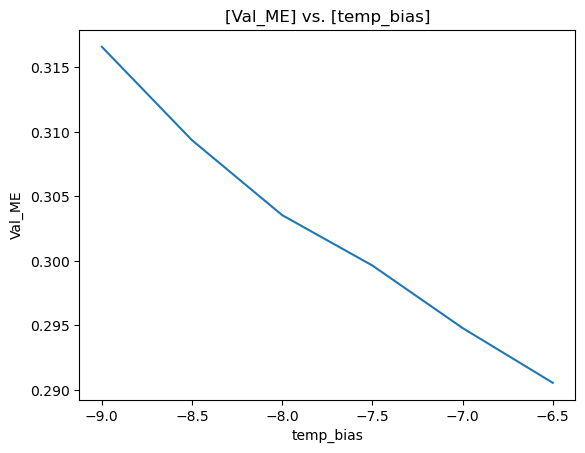

In [239]:
x='temp_bias'
y='Val_ME'
plt.plot(df[x],df[y]);
plt.xlabel(x);
plt.ylabel(y);
plt.title(f'[{y}] vs. [{x}]');

### Mass Balance Gradients

In [57]:
# Is inversion flux maximum a good ELA estimate? # **Apparent ELA estimate (i.e., underestimated)
for tb in df.temp_bias:
    fl=gdir.read_pickle('inversion_output',filesuffix=f'tb{tb}')[0]
   # print('Apparent ELA:')
    print(tb,fl['hgt'][fl['flux']==fl['flux'].max()].mean())
    # print('Flux')
    # print(fl['flux'].mean())

-6.5 5117.394926634621
-7.0 5094.593795101853
-7.5 5071.789950332193
-8.0 5050.022953225323
-8.5 5030.854372641068
-9.0 5000.913430964098


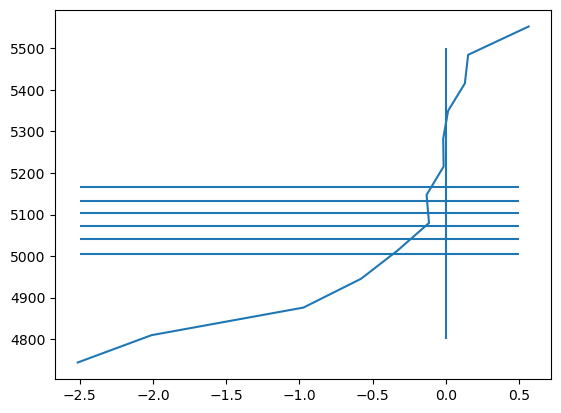

In [59]:
# Another look at ELA estimates
grids_path = gdir.get_filepath('gridded_data') # gridded data filepath
with xr.open_dataset(grids_path) as ds:
    ds_group = ds.groupby_bins('topo',bins=20).mean() # group gridded data by altitude bins
    ref_mb = ds_group.ref_mb.values.flatten()
    alt = ds_group.topo.values.flatten()
    ds.close()

plt.plot(ref_mb,alt)
for ela in mean_elas:
    plt.hlines(ela,xmin=-2.5,xmax=0.5);

plt.vlines(0,ymin=4800,ymax=5500);

## Inversion Surface Velocity

In [62]:
# Important to first store the model flowlines - So re run inversion

# mbp=df_raw.iloc[3].to_dict() # take intermediate model calibration
# mbp['mb_global_params']=global_params
# cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']

# gdir.write_json(mbp,'mb_calib') # Update MB calibration data

# tasks.apparent_mb_from_any_mb(gdir) 

# cfg.PARAMS['min_slope'] = 6.0
# list_talks = [
#     tasks.prepare_for_inversion,  # This is a preprocessing task
#     tasks.mass_conservation_inversion,  # This does the actual job
#     tasks.filter_inversion_output,  # This smoothes the thicknesses at the tongue a little
#     tasks.init_present_time_glacier
#     ]
        
# for task in list_talks:
#     workflow.execute_entity_task(task, [gdir])

In [60]:
tasks.elevation_band_flowline(gdir,bin_variables='millan_v',
                                     preserve_totals=False)
 # Create blank fixed dx elevation band fls to store data
tasks.fixed_dx_elevation_band_flowline(gdir,bin_variables='millan_v',
                                     preserve_totals=False)


In [61]:
df_v_inv = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0) # _fixed_dx

In [62]:
df_v_inv.head(2)

widths_m      area_m2  millan_v
dis_along_flowline                                  
30.0                16.127807   322.556137  4.160244
50.0                51.945130  1038.902593  4.073063

In [63]:
df.head(2)

Unnamed: 0          rgi_id  bias    melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0  1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0  2.577051       2.5       -7.0   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  ...    Val_ME  \
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.290560   
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.294803   

     Val_MAE   Val_RMSE  Inversion_Volume  Mean_Thickness_Below_5100m  \
0  24.013545  34.518850      8.096665e+07                   73.592180   
1  24.179261  34.799697      8.020542e+07                   73.576989   

   Flowline_Thickness  apparent_mb_from_any_mb_residual  mean_u_surf_m_per_a  \
0           66.620696                        442.154506            16.809282   
1           66.680584                        442.154506            21.340836   

   max_u_surf_m_per_a  min_u_surf_m_per_a  
0           26.949752            2.181344  
1           34.438708            2.326818  

[2 rows x 22 columns]

In [64]:
# Compare velocity profiles of Inverions runs to Millan velocity profile
for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.compute_inversion_velocities(gdir)

    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v','ref_dh'],
                              preserve_totals=[False, True]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v','ref_dh'],
                              preserve_totals=[False, True]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]
    #df_regular['mean_elevation'] = fl.surface_h
    inv = gdir.read_pickle('inversion_output')[0]
    df_v_inv[f'OGGM_inversion_velocity_tb{mbp['temp_bias']}'] = inv['u_surface'] # Store for comparison
    


    
df_v_inv

widths_m      area_m2  millan_v  \
dis_along_flowline                                      
30.0                 16.127807   322.556137  4.160244   
50.0                 51.945130  1038.902593  4.073063   
70.0                139.721297  2794.425936  3.681951   
90.0                316.128054  6322.561080  2.772401   
110.0               471.154952  9423.099030  2.166152   
...                        ...          ...       ...   
2130.0              188.284925  3765.698501  3.298946   
2150.0              158.519450  3170.388997  2.642528   
2170.0              128.753975  2575.079492  1.986110   
2190.0               98.988499  1979.769988  1.329692   
2210.0               69.223024  1384.460484  0.673274   

                    OGGM_inversion_velocity_tb-6.5  \
dis_along_flowline                                   
30.0                                      2.181344   
50.0                                      2.870140   
70.0                                      4.305730   
90.0                                      4.424561   
110.0                                     4.821568   
...                                            ...   
2130.0                                    4.886834   
2150.0                                    4.891174   
2170.0                                    3.654504   
2190.0                                    4.237483   
2210.0                                    7.233708   

                    OGGM_inversion_velocity_tb-7.0  \
dis_along_flowline                                   
30.0                                      2.326818   
50.0                                      3.067225   
70.0                                      4.572992   
90.0                                      4.741712   
110.0                                     5.187115   
...                                            ...   
2130.0                                    6.654516   
2150.0                                    6.662367   
2170.0                                    4.947457   
2190.0                                    5.749996   
2210.0                                    9.913881   

                    OGGM_inversion_velocity_tb-7.5  \
dis_along_flowline                                   
30.0                                      2.437661   
50.0                                      3.215128   
70.0                                      4.762380   
90.0                                      4.969505   
110.0                                     5.450090   
...                                            ...   
2130.0                                    8.817800   
2150.0                                    8.834418   
2170.0                                    6.514343   
2190.0                                    7.594101   
2210.0                                   13.251322   

                    OGGM_inversion_velocity_tb-8.0  \
dis_along_flowline                                   
30.0                                      2.537145   
50.0                                      3.347391   
70.0                                      4.928860   
90.0                                      5.166734   
110.0                                     5.672357   
...                                            ...   
2130.0                                   11.437104   
2150.0                                    7.732421   
2170.0                                    8.393177   
2190.0                                    9.816511   
2210.0                                   17.347913   

                    OGGM_inversion_velocity_tb-8.5  \
dis_along_flowline                                   
30.0                                      2.622666   
50.0                                      3.460537   
70.0                                      5.068630   
90.0                                      5.332988   
110.0                                     5.860403   
...                                            ...   
2130.0                              

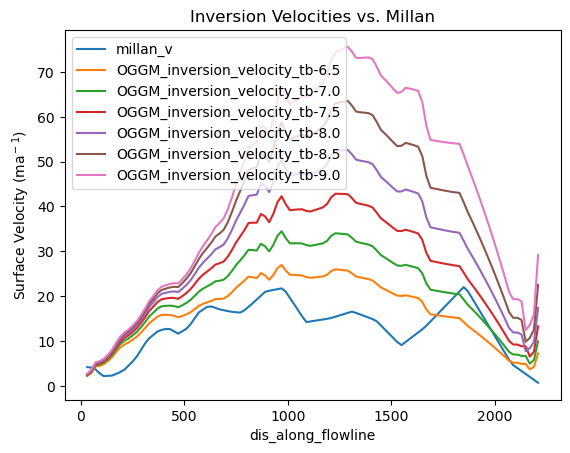

In [65]:
df_v_inv[['millan_v','OGGM_inversion_velocity_tb-6.5',
           'OGGM_inversion_velocity_tb-7.0', 'OGGM_inversion_velocity_tb-7.5',
           'OGGM_inversion_velocity_tb-8.0','OGGM_inversion_velocity_tb-8.5','OGGM_inversion_velocity_tb-9.0']].plot();

plt.title('Inversion Velocities vs. Millan');
plt.ylabel('Surface Velocity (ma$^-$$^1$)');

In [66]:
# Evaluate Error Against Millan
df_se = df_v_inv[['millan_v','OGGM_inversion_velocity_tb-6.5',
               'OGGM_inversion_velocity_tb-7.0', 'OGGM_inversion_velocity_tb-7.5',
               'OGGM_inversion_velocity_tb-8.0','OGGM_inversion_velocity_tb-9.0']]

for col in df_se.columns:
    rmse = ((df_se[col]-df_se['millan_v'])**2).mean() **0.5
    mae = abs((df_se[col]-df_se['millan_v'])).mean()
    print(rmse, mae)

0.0 0.0
5.966700462896031 5.1317508600117225
10.411875142691388 8.625275413985928
15.771301308749562 13.288221730700116
21.78252454921303 18.551773420276334
35.99824920652026 30.63509613410848


## Surface Velocity During Run

In [5]:
cfg.PARAMS['use_inversion_params_for_run'],cfg.PARAMS['store_fl_diagnostics']

(True, True)

In [68]:
# Instability. See: https://docs.oggm.org/en/latest/faq.html#ice-velocities-in-oggm-are-sometimes-noisy-or-unrealistic-how-so
# cfg.PARAMS['cfl_min_dt'] = 60.0
# cfg.PARAMS['cfl_number'] = 0.01

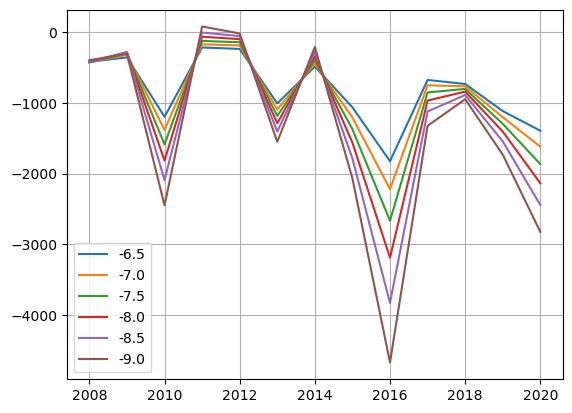

In [69]:
# Mass Balance Forcing
y0=2008
fls=gdir.read_pickle('inversion_flowlines')
for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data

    mbmod = MonthlyTIModel(gdir)
    smb1=mbmod.get_specific_mb(fls=fls, year=np.arange(y0,2021))
    elas=mbmod.get_ela(year=np.arange(y0,2021))
    plt.plot(np.arange(y0,2021),smb1,
                 label=f'{tb}') 

plt.grid()
plt.legend();

####

#### Historical Models, No Calving

In [6]:
cfg.PARAMS['min_slope'] #= 7.5 # had been using six

1.5

In [71]:
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False

for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.init_present_time_glacier(gdir)
    #tasks.compute_inversion_velocities(gdir)


    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]

    suf=f'_historical_tb{tb}'
    tasks.run_from_climate_data(gdir, store_model_geometry=True,
                            mb_elev_feedback='monthly', store_monthly_step=True,
                            ys=2008,ye=2020,evolution_model =FluxBasedModel,
                            output_filesuffix=suf)
    
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
        ds_fl = ds_fl.load()

    vel = ds_fl.sel(time=2017).ice_velocity_myr.data[:len(df_v_inv)]
    df_v_inv[f'OGGM_Run_velocity_tb{tb}_2017']=vel
    vel = ds_fl.sel(time=2018).ice_velocity_myr.data[:len(df_v_inv)]
    df_v_inv[f'OGGM_Run_velocity_tb{tb}_2018']=vel


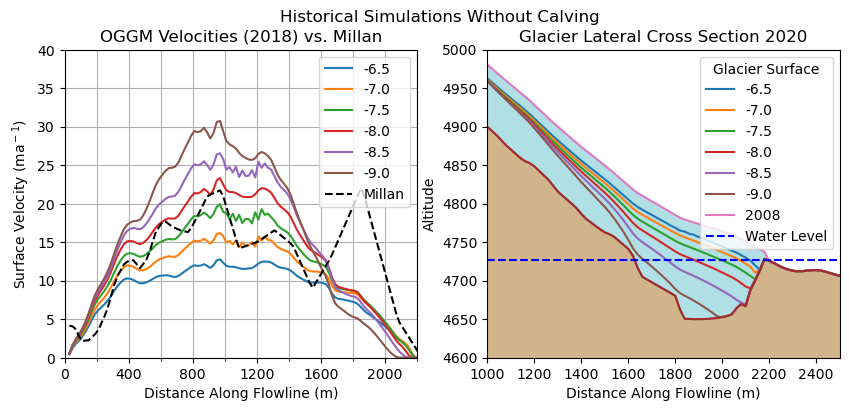

In [167]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(10,4))
f.suptitle('Historical Simulations Without Calving');

year_v = 2018
for tb in df_raw.temp_bias.values:
    # Plot velocity Profile
    # df_v_inv[['millan_v', #f'OGGM_inversion_velocity_tb{tb}',
    #           #f'OGGM_Run_velocity_tb{tb}_2017',
    #           f'OGGM_Run_velocity_tb{tb}_2018']].plot(ax=ax,legend=False)
    ax.plot(df_v_inv[f'OGGM_Run_velocity_tb{tb}_{year_v}'], label = str(tb))
    
    ax.set_title(f'OGGM Velocities ({year_v}) vs. Millan');
    ax.set_ylabel('Surface Velocity (ma$^-$$^1$)');
    
    # Plot THickness Cross section
    suf=f'_historical_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
        ds_fl_ = ds_fl.load()
    

    year=2020
    ds_fl = ds_fl_.sel(time=year).copy()
    ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
    surf = ds_fl.thickness_m + ds_fl.bed_h
    surf.plot(ax=ax1, label=f'{tb}')
    
    if tb == df_raw.temp_bias.values.min():
        
        ds_fl = ds_fl_.sel(time=2008).copy()
        ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
        surf = ds_fl.thickness_m + ds_fl.bed_h
        
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
        surf.plot(ax=ax1, label='2008')
        ds_fl.bed_h.plot(ax=ax1)
        
    elif tb == df_raw.temp_bias.values.max():
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
    
ds_fl.bed_h.plot(ax=ax1,color='brown')
ax1.fill_between(x=ds_fl.dis_along_flowline.values,y1=ds_fl.bed_h.values,y2=4600,color='tan')
ax1.axhline(wl_cal,linestyle='--',color='blue',label='Water Level');


ax1.set_ylim([4600,5000]);
ax1.set_xlim([1000,2500]);
ax1.legend(title='Glacier Surface',loc ='upper right');
ax1.set_title(f'Glacier Lateral Cross Section {year}');
ax1.set_ylabel('Altitude');

ax.plot(df_v_inv.millan_v,color='k',linestyle='--',label='Millan')
ax.legend();

ax1.set_xlabel('Distance Along Flowline (m)');
ax.set_xlabel('Distance Along Flowline (m)');

ax1.set_xlabel('Distance Along Flowline (m)');
ax.set_xlabel('Distance Along Flowline (m)');
ax.set_xlim([0,2200]);
ax.set_ylim([0,40]);
ax.set_xticks(np.arange(0,2400,400), labels=np.arange(0,2400,400), rotation=0)
ax.set_xticks(np.arange(200,2400,400), labels=['' for i in np.arange(200,2400,400)], minor=True, rotation=0)
ax.grid(which='both');

In [168]:
path = os.path.join(OUTPUTS, 'historical_simulation_no_calving.png')
f.savefig(path)

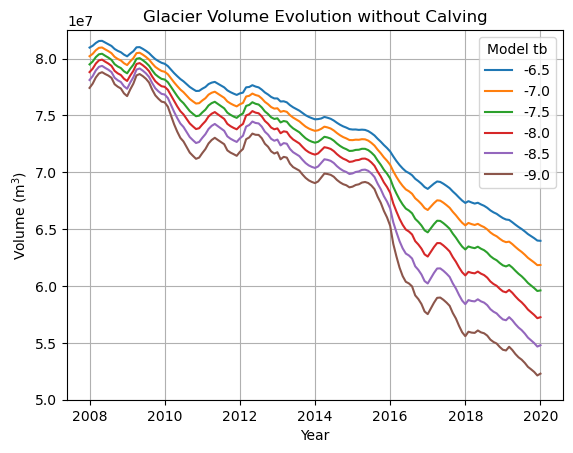

In [180]:
f,ax=plt.subplots()
for tb in df_raw.temp_bias:
    suf=f'_historical_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        length=ds.length_m
        ds.close()    
   
    vol.plot(ax=ax,label=str(tb))
plt.title('Glacier Volume Evolution without Calving');
plt.ylabel('Volume (m$^3$)');
plt.xlabel('Year');
plt.legend(title='Model tb');
plt.grid();
plt.ylim([5.0e7,8.25e7]);

In [181]:
path = os.path.join(OUTPUTS, 'historical_simulation_no_calving.png')
f.savefig(path)

#### Historical Simulation, no calving, with hydrological output
- for the monthly acc/abl trendss, I use the tb-7.0 and tb-8.5 as representative low and high sensitivity models

In [11]:
cfg.PARAMS['min_slope'] = 7.5 # had been using six

2024-08-04 16:33:45: oggm.cfg: PARAMS['min_slope'] changed from `1.5` to `7.5`.


In [76]:
cfg.PARAMS['store_model_geometry']=True
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False

for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df_cal_res.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.init_present_time_glacier(gdir)
    #tasks.compute_inversion_velocities(gdir)


    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]

    suf=f'_historical_with_hydro_tb{tb}'
    
    # This time run with hydrological output
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, store_model_geometry=True,
                            mb_elev_feedback='annual', store_monthly_step=False,
                            climate_input_filesuffix ='',
                            ys=2008,ye=2021,evolution_model =FluxBasedModel,
                            output_filesuffix=suf, store_monthly_hydro=True);

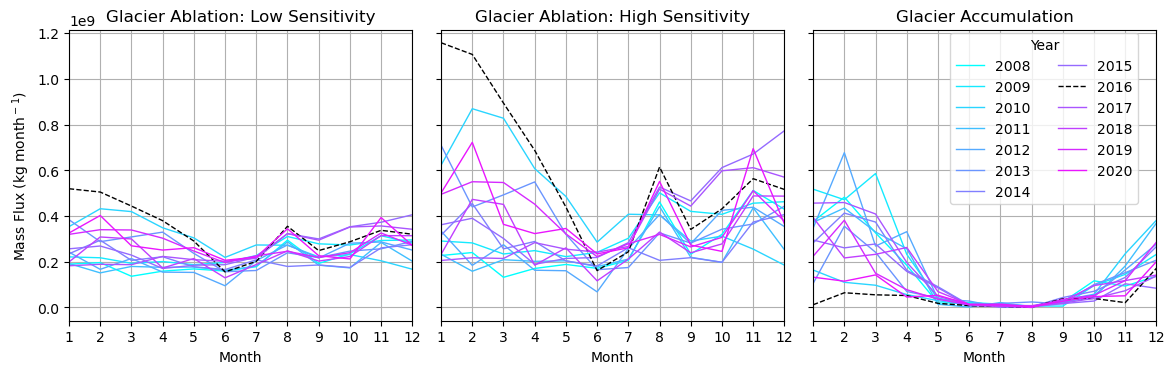

In [159]:
f,(ax,ax1,ax2)=plt.subplots(1,3,figsize=(12,4),sharey=True)
ax.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,13)))
ax2.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,13)))
ax1.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,13)))

for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
    suf=f'_historical_with_hydro_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        for year in ds.time.values[0:-1]:
            if year==2016:
                if i == 0:
                    ds.sel(time=year).melt_on_glacier_monthly.plot(ax=ax,linewidth=1,linestyle='--',color='k')
                    ds.sel(time=year).snowfall_on_glacier_monthly.plot(ax=ax2,label=int(year),linewidth=1,linestyle='--',color='k')
                else:
                    ds.sel(time=year).melt_on_glacier_monthly.plot(ax=ax1,linewidth=1,linestyle='--',color='k')
            else:
                if i == 0:
                    ds.sel(time=year).melt_on_glacier_monthly.plot(ax=ax,linewidth=1)
                    ds.sel(time=year).snowfall_on_glacier_monthly.plot(ax=ax2,label=int(year),linewidth=1)
                else:
                    ds.sel(time=year).melt_on_glacier_monthly.plot(ax=ax1,linewidth=1) 
            
ax.set_title('Glacier Ablation: Low Sensitivity');
#ax.legend(title='Year',loc=(1.02,0.2));
ax.set_xlabel('Month');
ax.set_ylabel('Mass Flux (kg month$^-$$^1$)');
ax.set_xlim([1,12]);
ax.set_xticks(np.arange(1,13));
ax.grid();

ax1.set_title('Glacier Ablation: High Sensitivity');
#ax.legend(title='Year',loc=(1.02,0.2));
ax1.set_xlabel('Month');
ax1.set_ylabel('');
ax1.set_xlim([1,12]);
ax1.set_xticks(np.arange(1,13));
ax1.grid();

ax2.set_title('Glacier Accumulation');
ax2.legend(title='Year',ncol=2, loc=(0.4,0.4));
ax2.set_xlabel('Month');
ax2.set_ylabel('');
ax2.set_xlim([1,12]);
ax2.set_xticks(np.arange(1,13));
ax2.grid();

plt.tight_layout()
#f.suptitle('Low Sensitivity Mass Balance Model');

In [128]:
path = os.path.join(OUTPUTS, 'monthly_glacier_acc_abl.png')
f.savefig(path)

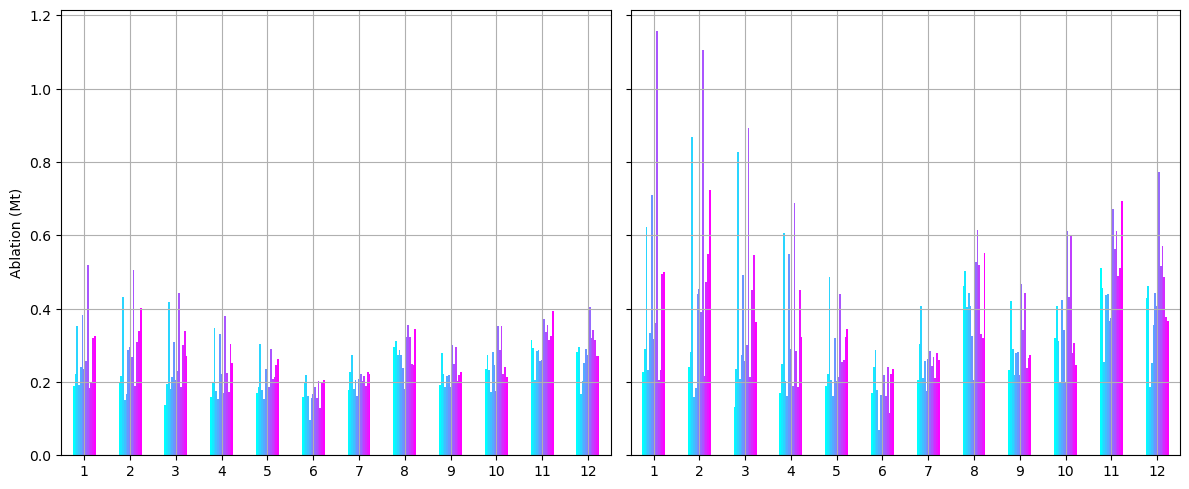

In [62]:
## Monthly Melt
f,axs=plt.subplots(1,2,sharey=True, figsize=(12,5))

for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
    suf=f'_historical_with_hydro_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        df_melt = pd.DataFrame(index=np.arange(1,13))
        for year in ds.time.values[0:-1]:
            melt= ds.sel(time=year).to_dataframe()['melt_on_glacier_monthly']
            df_melt[f'melt_{int(year)}']=melt *1e-9


    df_melt.plot.bar(ax=axs[i], color=plt.cm.cool(np.linspace(0,1,13)))
    
hh,ll = axs[1].get_legend_handles_labels()
axs[1].legend(handles=hh, labels = [l.split('_')[1] for l in ll],
           loc='upper right',title='Year',ncols=3);


axs[0].set_ylabel('Ablation (Mt)');
axs[0].get_legend().remove()
axs[1].get_legend().remove()
for ax in axs:
    ax.set_xlabel('');
    ax.grid();
    ax.set_xticks(np.arange(0,12),labels=[str(i) for i in np.arange(1,13)],rotation=0);
    
# axs[0].set_title('Low Sensitivity Model');
# axs[1].set_title('High Sensitivity Model');
plt.tight_layout()


In [ ]:
month_totals = df_acc.sum(axis=1)
month_totals.loc[[12,1,2]].sum()/month_totals.sum(), month_totals.loc[[6,7,8]].sum()/month_totals.sum()

In [46]:
path = os.path.join(OUTPUTS, 'monthly_glacier_abl_no_legend.png')
f.savefig(path)

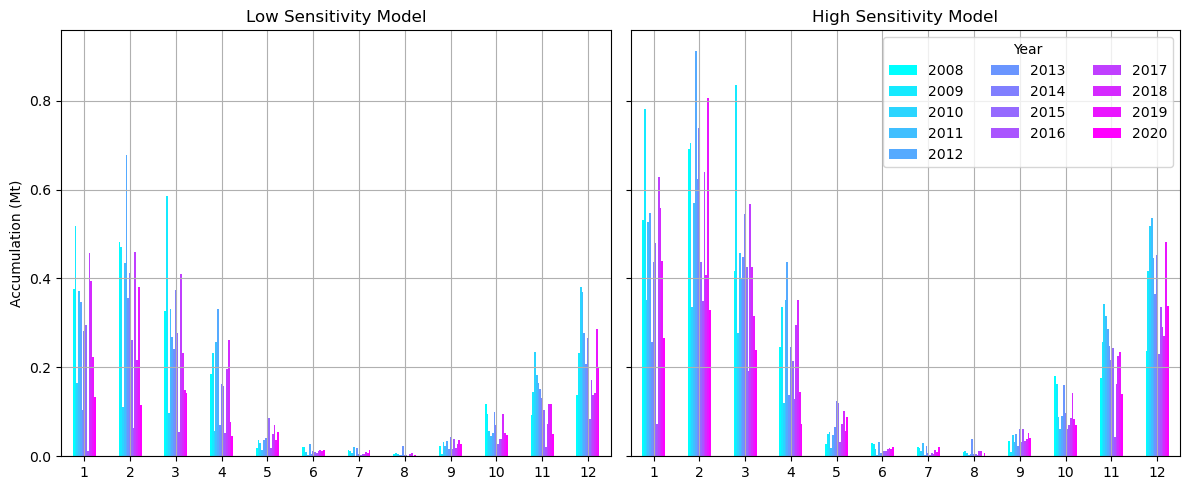

In [48]:
## Monthly Accumulation
f,axs=plt.subplots(1,2,sharey=True, figsize=(12,5))

for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
    suf=f'_historical_with_hydro_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        df_acc = pd.DataFrame(index=np.arange(1,13))
        for year in ds.time.values[0:-1]:
            melt= ds.sel(time=year).to_dataframe()['snowfall_on_glacier_monthly']
            df_acc[f'acc_{int(year)}']=melt *1e-9


    df_acc.plot.bar(ax=axs[i], color=plt.cm.cool(np.linspace(0,1,13)))
    
hh,ll = axs[1].get_legend_handles_labels()
axs[1].legend(handles=hh, labels = [l.split('_')[1] for l in ll],
           loc='upper right',title='Year',ncols=3);


axs[0].set_ylabel('Accumulation (Mt)');
axs[0].get_legend().remove()
for ax in axs:
    ax.set_xlabel('');
    ax.grid();
    ax.set_xticks(np.arange(0,12),labels=[str(i) for i in np.arange(1,13)],rotation=0);
    
axs[0].set_title('Low Sensitivity Model');
axs[1].set_title('High Sensitivity Model');
plt.tight_layout()

In [61]:
month_totals = df_acc.sum(axis=1)
month_totals.loc[[12,1,2]].sum()/month_totals.sum(), month_totals.loc[[6,7,8]].sum()/month_totals.sum()

(0.5537296263500443, 0.015885003182269947)

In [44]:
path = os.path.join(OUTPUTS, 'monthly_glacier_acc_no_legend.png')
f.savefig(path)

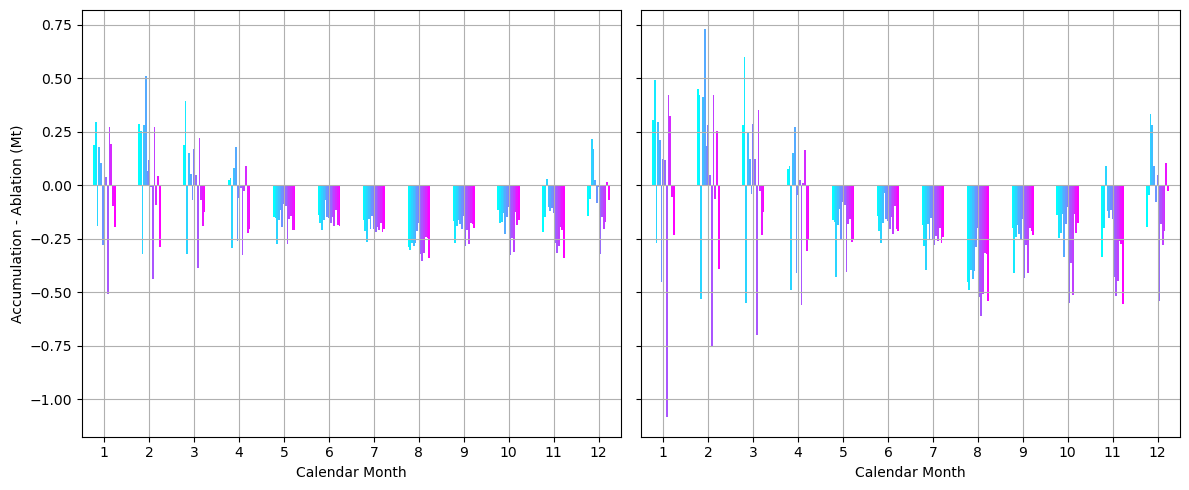

In [41]:
## Monthly Mass Balance
f,axs=plt.subplots(1,2,sharey=True, figsize=(12,5))

for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
    suf=f'_historical_with_hydro_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        df_mb = pd.DataFrame(index=np.arange(1,13))
        for year in ds.time.values[0:-1]:
            _df= ds.sel(time=year).to_dataframe()[['melt_on_glacier_monthly','snowfall_on_glacier_monthly']]
            mb=_df['snowfall_on_glacier_monthly'] - _df['melt_on_glacier_monthly']
            df_mb[f'mb_{int(year)}']=mb *1e-9
    df_mb.plot.bar(ax=axs[i], color=plt.cm.cool(np.linspace(0,1,13)))
    
ax0=axs[0]
hh,ll = ax0.get_legend_handles_labels()
# ax0.legend(handles=hh, labels = [l.split('_')[1] for l in ll],
#            loc=(0.23,0.04),title='Year',ncols=3);


axs[0].set_ylabel('Accumulation - Ablation (Mt)');
axs[1].get_legend().remove()
axs[0].get_legend().remove()
for ax in axs:
    ax.set_xlabel('Calendar Month');
    ax.grid();
    ax.set_xticks(np.arange(0,12),labels=[str(i) for i in np.arange(1,13)],rotation=0);
    
# axs[0].set_title('Low Sensitivity Model');
# axs[1].set_title('High Sensitivity Model');
plt.tight_layout()

In [42]:
path = os.path.join(OUTPUTS, 'monthly_glacier_mb_no_legend.png')
f.savefig(path)

In [39]:
# f,axs=plt.subplots(3,2,figsize=(12,12),sharex=True)

# for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
#     suf=f'_historical_with_hydro_tb{tb}'
#     with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
#         df_melt = pd.DataFrame(index=np.arange(1,13))
#         for year in ds.time.values[0:-1]:
#             melt= ds.sel(time=year).to_dataframe()['snowfall_on_glacier_monthly']
#             df_melt[f'melt_{int(year)}']=melt *1e-9


#     df_melt.plot.bar(ax=axs[0][i], color=plt.cm.cool(np.linspace(0,1,13)))
    
# hh,ll = axs[0][1].get_legend_handles_labels()
# axs[0][1].legend(handles=hh, labels = [l.split('_')[1] for l in ll],
#            loc='upper right',title='Year',ncols=3);


# # axs[0].set_ylabel('Accumulation (Mt)');
# axs[0][0].get_legend().remove()
# # for ax in axs:
# #     ax.set_xlabel('Calendar Month');
# #     ax.grid();
# #     ax.set_xticks(np.arange(0,12),labels=[str(i) for i in np.arange(1,13)],rotation=0);
    
# axs[0][0].set_title('Low Sensitivity Model');
# axs[0][1].set_title('High Sensitivity Model');

# for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
#     suf=f'_historical_with_hydro_tb{tb}'
#     with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
#         df_melt = pd.DataFrame(index=np.arange(1,13))
#         for year in ds.time.values[0:-1]:
#             melt= ds.sel(time=year).to_dataframe()['melt_on_glacier_monthly']
#             df_melt[f'melt_{int(year)}']=melt *1e-9
#         df_melt.plot.bar(ax=axs[1][i], color=plt.cm.cool(np.linspace(0,1,13)))
#     axs[1][i].get_legend().remove()
    
# for i,tb in enumerate(df_raw.loc[[1,4]].temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
#     suf=f'_historical_with_hydro_tb{tb}'
#     with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
#         df_mb = pd.DataFrame(index=np.arange(1,13))
#         for year in ds.time.values[0:-1]:
#             _df= ds.sel(time=year).to_dataframe()[['melt_on_glacier_monthly','snowfall_on_glacier_monthly']]
#             mb=_df['snowfall_on_glacier_monthly'] - _df['melt_on_glacier_monthly']
#             df_mb[f'mb_{int(year)}']=mb *1e-9
#     df_mb.plot.bar(ax=axs[2][i], color=plt.cm.cool(np.linspace(0,1,13)))
#     axs[2][i].get_legend().remove()

In [98]:
# df_abl = pd.DataFrame(columns=['DJF_%','JJA_%'])
# for i,tb in enumerate(df_raw.temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
#     suf=f'_historical_with_hydro_tb{tb}'
#     with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
#         df_melt = pd.DataFrame(index=np.arange(1,13))
#         for year in ds.time.values[0:-1]:
#             melt= ds.sel(time=year).to_dataframe()['melt_on_glacier_monthly']
#             df_melt[f'melt_{int(year)}']=melt *1e-9

#     month_totals = df_melt.sum(axis=1)
#     df_abl.loc[tb,'DJF_%']=month_totals.loc[[12,1,2]].sum()/month_totals.sum() *100
#     df_abl.loc[tb,'JJA_%'] = month_totals.loc[[6,7,8]].sum()/month_totals.sum() *100

# df_acc = pd.DataFrame(columns=['DJF_%','JJA_%'])
# for i,tb in enumerate(df_raw.temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
#     suf=f'_historical_with_hydro_tb{tb}'
#     with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
#         df_melt = pd.DataFrame(index=np.arange(1,13))
#         for year in ds.time.values[0:-1]:
#             melt= ds.sel(time=year).to_dataframe()['snowfall_on_glacier_monthly']
#             df_melt[f'snowfall_{int(year)}']=melt *1e-9

#     month_totals = df_melt.sum(axis=1)
#     df_acc.loc[tb,'DJF_%']=month_totals.loc[[12,1,2]].sum()/month_totals.sum() *100
#     df_acc.loc[tb,'JJA_%'] = month_totals.loc[[6,7,8]].sum()/month_totals.sum() *100

df_mb = pd.DataFrame(columns=['Pos_mb','Neg_mb'])
for i,tb in enumerate(df_raw.temp_bias): # Picking the tb-7.0 and tb-8.5 as representative low and high sensitivity models.
    suf=f'_historical_with_hydro_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        df_mass_bal = pd.DataFrame(index=np.arange(1,13))
        for year in ds.time.values[0:-1]:
            _df= ds.sel(time=year).to_dataframe()[['melt_on_glacier_monthly','snowfall_on_glacier_monthly']]
            mb=_df['snowfall_on_glacier_monthly'] - _df['melt_on_glacier_monthly']
            df_mass_bal[f'mb_{int(year)}']=mb *1e-9

    month_totals = df_melt.sum(axis=1)
    df_mb.loc[tb,'Pos_mb']= df_mass_bal.where(df_mass_bal>=0).count().sum()
    #month_totals.loc[[12,1,2]].sum()/month_totals.sum() *100
    df_mb.loc[tb,'Neg_mb'] = df_mass_bal.where(df_mass_bal<0).count().sum()
    #month_totals.loc[[6,7,8]].sum()/month_totals.sum() *100

In [105]:
df_mb

Pos_mb Neg_mb
-6.5     30    126
-7.0     33    123
-7.5     35    121
-8.0     36    120
-8.5     37    119
-9.0     38    118

## Temperature vs. Precipitaiton Forcing
Here I hold temp and precip constant to evaluate indipendent forcing of each timeseries

In [182]:
def write_synthetic_climate(gdir, year, t=False, p=False, half_period=15, suffix='SYNTHETIC', plot=False):
    # gdir: glacier dir
    # t (bool): whether to hold temp constant (True for hold contant)
    # p (bool): whether to hold prcp constant (True for hold contant)
    # year (int): central year for constant climatic mean
    # half_period (int): half period for climatic mean (climate period = 2*half_period + 1)
    # suffix (str): suffix for output climate_historical file
    # plot (bool): whether to plot results of new dataset
    
    y0=year-half_period
    y1=year+half_period
        
    fpath = gdir.get_filepath('climate_historical')
    with xr.open_dataset(fpath) as ds:
        # get timeseries
        time=ds.time.values
        _temp=ds.temp.values
        temp=_temp
        _prcp=ds.prcp.values
        prcp=_prcp
        # Overwrite temp and/or prcp
        if t:
            clim_mean = ds.temp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')}).groupby("time.month").mean("time")
            temp = xr.zeros_like(ds.temp).groupby('time.month') + clim_mean
            temp=temp.values
            
            # temp = ds.temp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')})
            # temp = temp.groupby('time.month').mean() 
            # temp = xr.zeros_like(_temp) + temp
            # temp=temp.values
            #temp.resample(time=f'{half_period*2+1}AS').mean().values
 
        if p:
            clim_mean = ds.prcp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')}).groupby("time.month").mean("time")
            prcp = xr.zeros_like(ds.prcp).groupby('time.month') + clim_mean
            prcp=prcp.values
            # prcp = ds.prcp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')})
            # prcp = np.ones(len(time))*prcp.resample(time=f'{half_period*2+1}AS').mean().values

        # Get attributes
        attrs=ds.attrs
        ref_pix_hgt=attrs['ref_hgt']
        ref_pix_lon=attrs['ref_pix_lon']
        ref_pix_lat=attrs['ref_pix_lat']
        source=attrs['climate_source']
        
        gdir.write_monthly_climate_file(time, prcp, temp,
                                    ref_pix_hgt, ref_pix_lon, ref_pix_lat,
                                    source=source,
                                    file_name='climate_historical',
                                    filesuffix=suffix)
        # Plot results
        if plot:
            f,ax=plt.subplots()
            ax1=ax.twinx()       
            fpath = gdir.get_filepath('climate_historical',filesuffix=suffix)
            with xr.open_dataset(fpath) as ds:
            # Data is in hydrological years
            # -> let's just ignore the first and last calendar years
                ds.temp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')}).plot(ax=ax,c='orange',label='temp');
                ds.prcp.sel({'time':slice(str(y0)+'-01-01',str(y1)+'-12-01')}).plot(ax=ax1,label='prcp');
            ax.legend(loc=2);
            ax1.legend();
            ax.set_title(f'Monthly Climate Written to climate_historical{suffix}');
            ax.set_ylim([4,11]);
            

#### Constant Seasonal Temperature

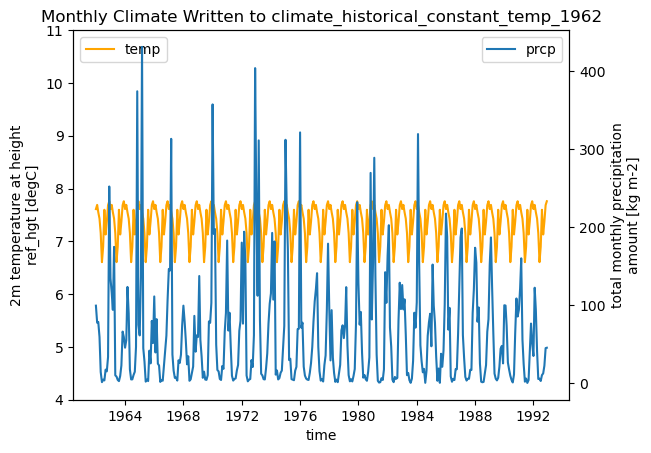

In [81]:
# Write syntheti climate with climatic avereage monthly temperature for 30 year period beginning in 1962
write_synthetic_climate(gdir, 1962+15, t=True, p=False, half_period=15, suffix='_constant_temp_1962', plot=True)

In [82]:
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False

for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.init_present_time_glacier(gdir)
    #tasks.compute_inversion_velocities(gdir)


    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]

    suf=f'_constant_temp_tb{tb}'
    tasks.run_from_climate_data(gdir, store_model_geometry=True,
                            mb_elev_feedback='monthly', store_monthly_step=True,
                            climate_input_filesuffix = '_constant_temp_1962',
                            ys=2008,ye=2020,evolution_model =FluxBasedModel,
                            output_filesuffix=suf)

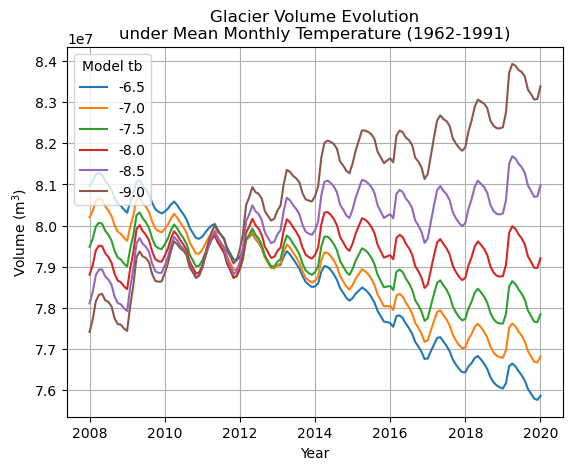

In [213]:
f,ax=plt.subplots()
for tb in df_raw.temp_bias:
    suf=f'_constant_temp_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        length=ds.length_m
        ds.close()    
   
    vol.plot(ax=ax,label=str(tb))
plt.title('Glacier Volume Evolution\nunder Mean Monthly Temperature (1962-1991)');
plt.ylabel('Volume (m$^3$)');
plt.xlabel('Year');
plt.legend(title='Model tb');
plt.grid();

In [142]:
path = os.path.join(OUTPUTS, 'historical_simulatin_constant_temp.png')
f.savefig(path)

#### Constant Seasonal Precipitation

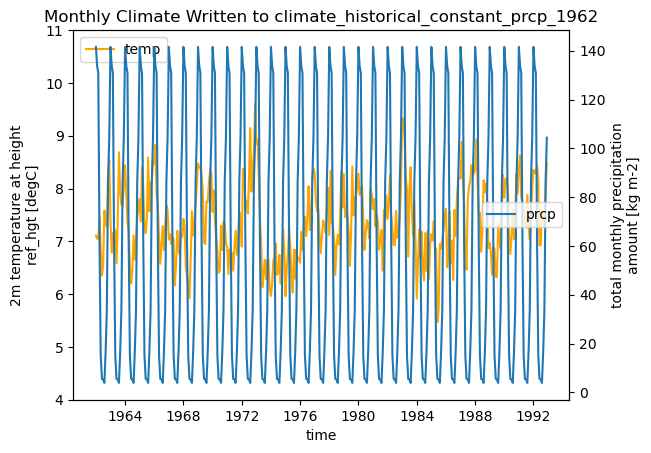

In [84]:
# Write syntheti climate with climatic avereage monthly precipitation for 30 year period beginning in 1962
write_synthetic_climate(gdir, 1962+15, t=False, p=True, half_period=15, suffix='_constant_prcp_1962', plot=True)

In [85]:
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False

for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.init_present_time_glacier(gdir)
    #tasks.compute_inversion_velocities(gdir)


    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]

    suf=f'_constant_prcp_tb{tb}'
    tasks.run_from_climate_data(gdir, store_model_geometry=True,
                            mb_elev_feedback='monthly', store_monthly_step=True,
                            climate_input_filesuffix = '_constant_prcp_1962',
                            ys=2008,ye=2020,evolution_model =FluxBasedModel,
                            output_filesuffix=suf)

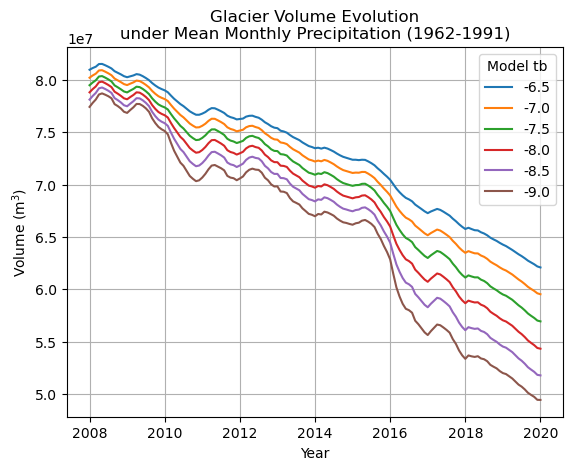

In [143]:
f,ax=plt.subplots()
for tb in df_raw.temp_bias:
    suf=f'_constant_prcp_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        length=ds.length_m
        ds.close()    
   
    vol.plot(ax=ax,label=str(tb))
plt.title('Glacier Volume Evolution\nunder Mean Monthly Precipitation (1962-1991)');
plt.ylabel('Volume (m$^3$)');
plt.xlabel('Year');
plt.legend(title='Model tb');
plt.grid();

In [144]:
path = os.path.join(OUTPUTS, 'historical_simulatin_constant_prcp.png')
f.savefig(path)

#### Constant Seasonal Climate

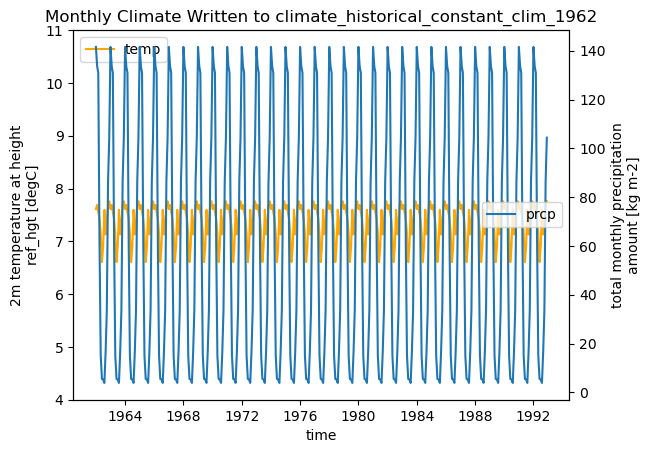

In [183]:
# Write syntheti climate with climatic avereage monthly clim for 30 year period beginning in 1962
write_synthetic_climate(gdir, 1962+15, t=True, p=True, half_period=15, suffix='_constant_clim_1962', plot=True)

In [192]:
cfg.PARAMS['store_model_geometry']=True
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False

for i in range(len(df_raw)): # Pull already calibrated vars
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df_cal_res.iloc[i].Creep_Param
    
    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.init_present_time_glacier(gdir)
    #tasks.compute_inversion_velocities(gdir)


    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    fl = gdir.read_pickle('inversion_flowlines')[0]

    suf=f'_constant_clim_tb{tb}'
    # tasks.run_from_climate_data(gdir, store_model_geometry=True,
    #                         mb_elev_feedback='monthly', store_monthly_step=True,
    #                         climate_input_filesuffix = '_constant_clim_1962',
    #                         ys=2008,ye=2020,evolution_model =FluxBasedModel,
    #                         output_filesuffix=suf)

    # This time run with hydrological output
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, store_model_geometry=True,
                            mb_elev_feedback='annual', store_monthly_step=False,
                            climate_input_filesuffix = '_constant_clim_1962',
                            ys=2008,ye=2020,evolution_model =FluxBasedModel,
                            output_filesuffix=suf, store_monthly_hydro=True);

2024-08-02 17:00:47: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


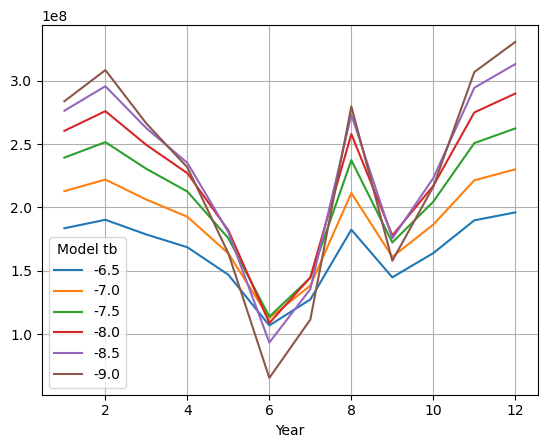

In [225]:
f,ax=plt.subplots()
for tb in df_raw.temp_bias:
    suf=f'_constant_clim_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        length=ds.length_m
        melt = ds.melt_on_glacier_monthly #.groupby('month_2d').mean(dim='time')
        snow=ds.snowfall_on_glacier
        ds.close()   
   
    melt.mean(dim='time').to_dataframe()['melt_on_glacier_monthly'].plot(ax=ax,label=str(tb))
    #melt.plot(ax=ax,label=str(tb))
#plt.title('Glacier Volume Evolution\nunder Mean Monthly Precipitation (1962-1991)');
#plt.ylabel('Volume (m$^3$)');
plt.xlabel('Year');
plt.legend(title='Model tb');
plt.grid();

<Axes: xlabel='month_2d'>

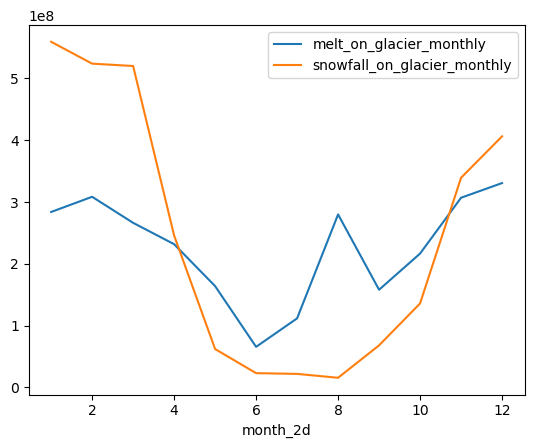

In [229]:
vars=['melt_on_glacier_monthly','snowfall_on_glacier_monthly']
ds[vars].mean(dim='time').to_dataframe()[vars].plot()

## With Calving

In [88]:
from oggm.core.flowline import k_calving_law

In [35]:
#df_v_inv = pd.read_csv(OUTPUTS+'model_flowline_results.csv',index_col=1)

In [241]:
cfg.PARAMS['use_kcalving_for_run']=False
gdir.is_tidewater=False
gdir.is_lake_terminating=False
wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
#k=1.0 # calving constant unless I want to iterate later

In [90]:
# path = os.path.join(OUTPUTS,'mb_calibrations.csv')
# df_raw=pd.read_csv(path, index_col=None)
# df_raw.head()

In [91]:
cfg.PARAMS['use_inversion_params_for_run']

True

In [92]:
# Re-Run Models but with Calving

for i in range(len(df_raw)): # Pull already calibrated vars

    # Reset MB Calibration 
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    tasks.apparent_mb_from_any_mb(gdir)

    # Run Inversion
    glen_a = df.iloc[i].Creep_Param

    tasks.prepare_for_inversion(gdir)
    tasks.mass_conservation_inversion(gdir,glen_a=glen_a)
    tasks.filter_inversion_output(gdir)
    tasks.compute_inversion_velocities(gdir)
    tasks.init_present_time_glacier(gdir)

    # Compute elevation bands
    tasks.elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]  # I"m actually not sure if preserving totals is meaningful with velocities - likely not
                              # NOTE: we could bin variables according to max() as well!
                              )
    # And fixed dx elevation bands
    tasks.fixed_dx_elevation_band_flowline(gdir,
                              bin_variables=['millan_v'],
                              preserve_totals=[False]
                                      )
    df_regular = pd.read_csv(gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx'), index_col=0)
    #fl = gdir.read_pickle('inversion_flowlines')[0]
    
    # Run Model with Calving
    cfg.PARAMS['use_kcalving_for_run']=True
    gdir.is_tidewater=True
    gdir.is_lake_terminating=True
    
    # Iterate over range of calving rate constants (k, meters per year)
    for k in np.arange(0.6,3.7,0.6):
        suf=f'_tb{tb}_calving_{k}'
        tasks.run_from_climate_data(gdir,
                            mb_elev_feedback='monthly',# init_model_filesuffix='_1962_spinup_bias0',
                            store_monthly_step=True,calving_k=k, calving_law=k_calving_law,
                            ys=2008,ye=2020,water_level=wl_cal,evolution_model =FluxBasedModel,
                            output_filesuffix=suf)
        with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
            ds_fl = ds_fl.load()
    
        vel = ds_fl.sel(time=2017).ice_velocity_myr.data[:len(df_v_inv)]
        df_v_inv[f'OGGM_Run_velocity{suf}_2017']=vel
        vel = ds_fl.sel(time=2018).ice_velocity_myr.data[:len(df_v_inv)]
        df_v_inv[f'OGGM_Run_velocity{suf}_2018']=vel

    cfg.PARAMS['use_kcalving_for_run']=False
    gdir.is_tidewater=False
    gdir.is_lake_terminating=False


2024-07-26 13:31:37: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.
2024-07-26 13:31:42: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `True` to `False`.
2024-07-26 13:31:43: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.
2024-07-26 13:31:48: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `True` to `False`.
2024-07-26 13:31:49: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.
2024-07-26 13:31:54: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `True` to `False`.
2024-07-26 13:31:54: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.
2024-07-26 13:32:00: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `True` to `False`.
2024-07-26 13:32:00: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.
2024-07-26 13:32:06: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `True` to `False`.
2024-07-26 13:32:07: oggm.cfg: PARAMS['use_kcalving_for_run'

In [96]:
df_v_inv.to_csv(OUTPUTS+'model_flowline_results.csv')

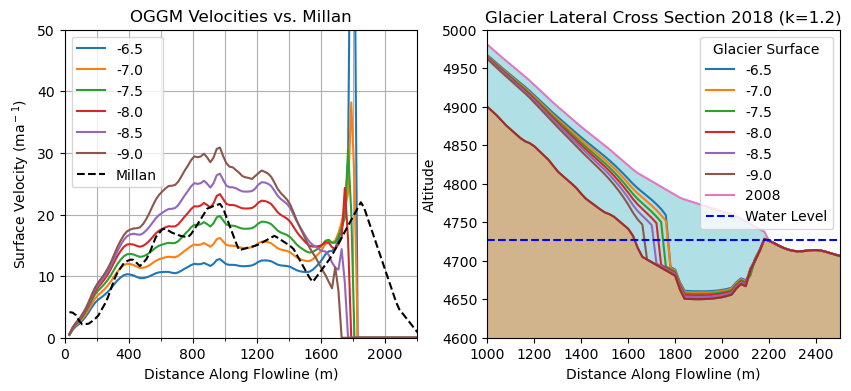

In [10]:
k=  1.2
yr = 2018 # 2018 or 2017
wl_cal = 4727 

profile_yr = 2018 # any year (for visualizing lateral cross section
f,(ax,ax1)=plt.subplots(1,2,figsize=(10,4))
for tb in df_raw.temp_bias.values:
    # Plot velocity Profile
    # df_v_inv[['millan_v', #f'OGGM_inversion_velocity_tb{tb}',
    #           #f'OGGM_Run_velocity_tb{tb}_2017',
    #           f'OGGM_Run_velocity_tb{tb}_2018']].plot(ax=ax,legend=False)
    ax.plot(df_v_inv[f'OGGM_Run_velocity_tb{tb}_calving_{k}_{yr}'], label = str(tb))
    
    ax.set_title('OGGM Velocities vs. Millan');
    ax.set_ylabel('Surface Velocity (ma$^-$$^1$)');
    
    # Plot THickness Cross section
    suf=f'_tb{tb}_calving_{k}'
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
        ds_fl_ = ds_fl.load()
    

    ds_fl = ds_fl_.sel(time=profile_yr).copy()
    ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
    surf = ds_fl.thickness_m + ds_fl.bed_h
    surf.plot(ax=ax1, label=f'{tb}')
    #ds_fl.bed_h.plot(ax=ax1,label=f'{tb}')
    
    if tb == df_raw.temp_bias.values.min():
        
        ds_fl = ds_fl_.sel(time=2008).copy()
        ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
        surf = ds_fl.thickness_m + ds_fl.bed_h
        
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
        surf.plot(ax=ax1, label='2008')
        ds_fl.bed_h.plot(ax=ax1)
        
    # elif tb == df_raw.temp_bias.values.max():
    #     ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
    
ds_fl.bed_h.plot(ax=ax1,color='brown')
ax1.fill_between(x=ds_fl.dis_along_flowline.values,y1=ds_fl.bed_h.values,y2=4600,color='tan')
ax1.axhline(wl_cal,linestyle='--',color='blue',label='Water Level');


ax1.set_ylim([4600,5000]);
ax1.set_xlim([1000,2500]);
ax1.legend(title='Glacier Surface',loc ='upper right')#(1.1,0.05));
ax1.set_title(f'Glacier Lateral Cross Section {profile_yr} (k={k})');
ax1.set_ylabel('Altitude');

ax.plot(df_v_inv.millan_v,color='k',linestyle='--',label='Millan')
ax.legend();

ax1.set_xlabel('Distance Along Flowline (m)');
ax.set_xlabel('Distance Along Flowline (m)');
ax.set_xlim([0,2200]);
ax.set_ylim([0,50]);
ax.set_xticks(np.arange(0,2400,400), labels=np.arange(0,2400,400), rotation=0)
ax.set_xticks(np.arange(200,2400,400), labels=['' for i in np.arange(200,2400,400)], minor=True, rotation=0)
ax.grid(which='both');

In [166]:
path = os.path.join(OUTPUTS, 'historical_simulatin_with_calving.png')
f.savefig(path)

In [147]:
# Evaluate Error Against Millan
df_se = df_v_inv[['millan_v',f'OGGM_Run_velocity_tb-6.5_calving_{k}_{yr}',f'OGGM_Run_velocity_tb-7.0_calving_{k}_{yr}',
                  f'OGGM_Run_velocity_tb-7.5_calving_{k}_{yr}',f'OGGM_Run_velocity_tb-8.0_calving_{k}_{yr}',
                  f'OGGM_Run_velocity_tb-8.5_calving_{k}_{yr}',f'OGGM_Run_velocity_tb-9.0_calving_{k}_{yr}'
                 ]]

for col in df_se.columns:
    sel = df_se[col]>0
    rmse = ((df_se[col][sel]-df_se['millan_v'])**2).mean() **0.5
    mae = abs((df_se[col][sel]-df_se['millan_v'])).mean()
    print(col,'| RMSE:',rmse, 'MAE:',mae)

millan_v | RMSE: 0.0 MAE: 0.0
OGGM_Run_velocity_tb-6.5_calving_1.2_2018 | RMSE: 9.798249345948063 MAE: 4.900950758186615
OGGM_Run_velocity_tb-7.0_calving_1.2_2018 | RMSE: 3.4892688048036655 MAE: 2.478519781506525
OGGM_Run_velocity_tb-7.5_calving_1.2_2018 | RMSE: 2.700239418282774 MAE: 2.1889213628504236
OGGM_Run_velocity_tb-8.0_calving_1.2_2018 | RMSE: 3.767079188485254 MAE: 3.2426728590900193
OGGM_Run_velocity_tb-8.5_calving_1.2_2018 | RMSE: 5.641283518412459 MAE: 5.15604919895629
OGGM_Run_velocity_tb-9.0_calving_1.2_2018 | RMSE: 7.571886091118534 MAE: 6.895519190904808


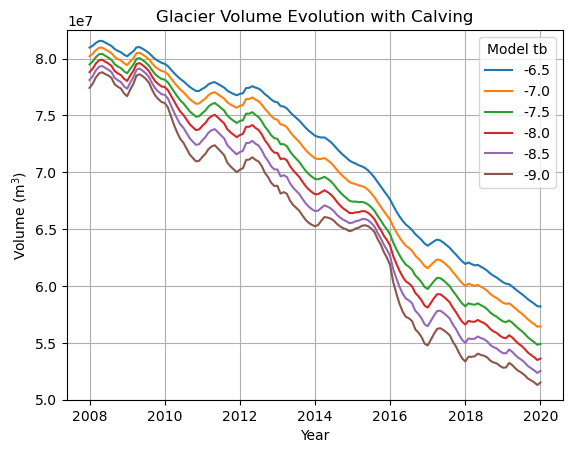

In [183]:
f,ax=plt.subplots()
for tb in df_raw.temp_bias:
    suf=f'_tb{tb}_calving_{k}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        length=ds.length_m
        ds.close()    
   
    vol.plot(ax=ax,label=str(tb))
plt.title('Glacier Volume Evolution with Calving');
plt.ylabel('Volume (m$^3$)');
plt.xlabel('Year');
plt.legend(title='Model tb');
plt.grid();
plt.ylim([5.0e7,8.25e7]);

In [184]:
path = os.path.join(OUTPUTS, 'historical_simulation_with_calving.png')
f.savefig(path)

## Analysis

In [12]:
path = os.path.join(OUTPUTS,'mb_calibrations.csv')
df_raw=pd.read_csv(path, index_col=None)

df_raw.head()

Unnamed: 0          rgi_id  bias    melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0  1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0  2.577051       2.5       -7.0   
2        -7.5  RGI60-16.02060     0  3.870401       2.5       -7.5   
3        -8.0  RGI60-16.02060     0  5.919010       2.5       -8.0   
4        -8.5  RGI60-16.02060     0  9.313196       2.5       -8.5   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   
2   -442.154506               NaN  1962-01-01_2009-01-01   
3   -442.154506               NaN  1962-01-01_2009-01-01   
4   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  
2  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  
3  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  
4  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...

In [13]:
# Store Global MB Parameters
global_params={'temp_default_gradient': -0.0065,
                     'temp_all_solid': 0.0,
                     'temp_all_liq': 2.0,
                     'temp_melt': -1.0}

In [8]:
df_v_inv= pd.read_csv(OUTPUTS+'model_flowline_results.csv',index_col=0)
df_cal_res= pd.read_csv(OUTPUTS+'calibration_results.csv',index_col=0)
df_v_inv.head()

widths_m      area_m2  millan_v  \
dis_along_flowline                                      
30.0                 16.127807   322.556137  4.160244   
50.0                 51.945130  1038.902593  4.073063   
70.0                139.721297  2794.425936  3.681951   
90.0                316.128054  6322.561080  2.772401   
110.0               471.154952  9423.099030  2.166152   

                    OGGM_inversion_velocity_tb-6.5  \
dis_along_flowline                                   
30.0                                      2.181344   
50.0                                      2.870140   
70.0                                      4.305730   
90.0                                      4.424561   
110.0                                     4.821568   

                    OGGM_inversion_velocity_tb-7.0  \
dis_along_flowline                                   
30.0                                      2.326818   
50.0                                      3.067225   
70.0                                      4.572992   
90.0                                      4.741712   
110.0                                     5.187115   

                    OGGM_inversion_velocity_tb-7.5  \
dis_along_flowline                                   
30.0                                      2.437661   
50.0                                      3.215128   
70.0                                      4.762380   
90.0                                      4.969505   
110.0                                     5.450090   

                    OGGM_inversion_velocity_tb-8.0  \
dis_along_flowline                                   
30.0                                      2.537145   
50.0                                      3.347391   
70.0                                      4.928860   
90.0                                      5.166734   
110.0                                     5.672357   

                    OGGM_inversion_velocity_tb-8.5  \
dis_along_flowline                                   
30.0                                      2.622666   
50.0                                      3.460537   
70.0                                      5.068630   
90.0                                      5.332988   
110.0                                     5.860403   

                    OGGM_inversion_velocity_tb-9.0  \
dis_along_flowline                                   
30.0                                      2.701705   
50.0                                      3.564826   
70.0                                      5.197009   
90.0                                      5.484191   
110.0                                     6.029177   

                    OGGM_Run_velocity_tb-6.5_2017  ...  \
dis_along_flowline                                 ...   
30.0                                     0.409302  ...   
50.0                                     1.178175  ...   
70.0                                     1.688901  ...   
90.0                                     2.067518  ...   
110.0                                    2.583544  ...   

                    OGGM_Run_velocity_tb-9.0_calving_1.2_2017  \
dis_along_flowline                                              
30.0                                                 0.556481   
50.0                                                 1.590167   
70.0                                                 2.307096   
90.0                                                 2.883221   
110.0                                                3.637741   

                    OGGM_Run_velocity_tb-9.0_calving_1.2_2018  \
dis_along_flowline                                              
30.0                                                 0.583738   
50.0                                                 1.670873   
70.0                                                 2.430326   
90.0                                                 3.030360   
110.0                                                3.796280   

                    OGGM_Run_

In [92]:
#df_cal_res#['Mean_Thickness_Below_5100m']#['Creep_Param']

### Climate Trends

In [6]:
from oggm.utils import date_to_floatyear
import pymannkendall as mk
from scipy import stats

In [14]:
## ENSO 3.4 Index ## Source: https://psl.noaa.gov/enso/dashboard.html
path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/Revisions/Climate_Data/ENSO_ANOM.xlsx'
enso34 = pd.read_excel(path, index_col=0,sheet_name='Nino 3.4')

# Annual
nino = enso34.mean(axis=1).loc[slice(1962,2020)]#.plot();
nino = nino.values

# Winter
nino_winter = enso34[[6,7,8]].mean(axis=1).loc[slice(1962,2020)]#.plot();
nino_winter = nino_winter.values

# Summer
nino_summer = enso34[[12,1,2]].mean(axis=1).loc[slice(1962,2020)]#.plot();
nino_summer = nino_summer.values

In [15]:
## ONI Index ## 
path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/Revisions/Climate_Data/ENSO_ANOM.xlsx'
enso34 = pd.read_excel(path, index_col=0,sheet_name='ONI')

# Winter
ONI_JJA = enso34['JJA'].loc[slice(1962,2020)]#.plot();
ONI_JJA = ONI_JJA.values

# Summer
ONI_DJF = enso34['DJF'].loc[slice(1962,2020)]#.plot();
ONI_DJF = ONI_DJF.values

# Spring
ONI_AMJ = enso34['AMJ'].loc[slice(1962,2020)]#.plot();
ONI_AMJ = ONI_AMJ.values

In [16]:
## SOI Index ## 
path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/Revisions/Climate_Data/ENSO_ANOM.xlsx'
enso34 = pd.read_excel(path, index_col=0,sheet_name='SOI')

# Annual
SOI = enso34.mean(axis=1).loc[slice(1962,2020)]#.plot();
SOI = SOI.values

# Winter
SOI_JJA = enso34[[6,7,8]].mean(axis=1).loc[slice(1962,2020)]#.plot();
SOI_JJA = SOI_JJA.values

# Summer
SOI_DJF = enso34[[12,1,2]].mean(axis=1).loc[slice(1962,2020)]#.plot();
SOI_DJF = SOI_DJF.values

In [17]:
tbs=[]

elas=[]
mean_ela=[]
smbs=[]

y0=1962
y1=2020
yrs=np.arange(y0,y1+1)

df_temp_m = pd.DataFrame(index=yrs, columns=np.arange(1,13))
df_tmelt_m = pd.DataFrame(index=yrs, columns=np.arange(1,13))
df_prcp_m = pd.DataFrame(index=yrs, columns=np.arange(1,13))

for i in range(len(df_raw)): # Pull already calibrated vars

    # Reset MB Calibration 
    mbp=df_raw.iloc[i].to_dict()
    mbp['mb_global_params']=global_params
    tb=mbp['temp_bias']
    tbs.append(tb)
    
    cfg.PARAMS['geodetic_mb_period']=mbp['reference_period']
    gdir.write_json(mbp,'mb_calib') # Update MB calibration data
    fls=gdir.read_pickle('inversion_flowlines')

    mbmod=MonthlyTIModel(gdir)
    smb=mbmod.get_specific_mb(fls=fls, year=np.arange(y0,y1+1))
    ela=mbmod.get_ela(year=np.arange(y0,y1+1))
    mean_ela.append(np.mean(ela))
    temps=[]
    prcps=[]
    for yr in np.arange(y0,y1+1):
        for m in np.arange(1,13):
            date = date_to_floatyear(yr,m)
            monthly_mb, temp, tempformelt, prcp, prcpsol= mbmod.get_monthly_mb(heights=[5000], year=date, add_climate=True)
            df_temp_m.loc[yr,m]=temp
            df_prcp_m.loc[yr,m]=prcp
            df_tmelt_m.loc[yr,m]=tempformelt
            
    elas.append(ela)
    smbs.append(smb)

2024-10-07 12:40:15: oggm.cfg: PARAMS['geodetic_mb_period'] changed from `2000-01-01_2020-01-01` to `1962-01-01_2009-01-01`.


In [18]:
df_clim = pd.DataFrame(index=yrs)
# Mean Annual Clim
df_clim['Temp_5000']= df_temp_m.mean(axis=1).values
df_clim['Prcp_5000']= df_prcp_m.mean(axis=1).values
# Mean JJA Clim
df_clim['Temp_JJA_5000']= df_temp_m[[6,7,8]].mean(axis=1).values
df_clim['Prcp_JJA_5000']= df_prcp_m[[6,7,8]].mean(axis=1).values
# Mean DJF Clim
df_clim['Temp_DJF_5000']= df_temp_m[[12,1,2]].mean(axis=1).values
df_clim['Prcp_DJF_5000']= df_prcp_m[[12,1,2]].mean(axis=1).values
# Mean MJJ Clim
df_clim['Temp_MJJ_5000']= df_temp_m[[5,6,7]].mean(axis=1).values
df_clim['Prcp_MJJ_5000']= df_prcp_m[[5,6,7]].mean(axis=1).values
# Mean AMJ Clim
df_clim['Temp_AMJ_5000']= df_temp_m[[4,5,6]].mean(axis=1).values
df_clim['Prcp_AMJ_5000']= df_prcp_m[[4,5,6]].mean(axis=1).values

# df_clim['Nino_3.4']=nino
# df_clim['Nino_3.4_JJA']=nino_winter
# df_clim['Nino_3.4_DJF']=nino_summer
df_clim['SMB']= np.mean(smbs,axis=0).flatten()
df_clim['ELA']= np.mean(elas,axis=0).flatten()

for col in df_clim.columns:
    ts = df_clim[col].copy() # Get variable timeseries
    climatology = ts.loc[slice(1980,2009)].mean() # Take mean climatology (1980-2009)
    std = ts.loc[slice(1980,2009)].std()
    ts -= climatology # Subtract from anual values
    df_clim[f'{col}_anom'] = ts # Assign to dataframe variable
    
    ts /= std # Divide by standard deviation
    df_clim[f'{col}_std_anom'] = ts # Assign to dataframe variable

df_clim.head()

Temp_5000   Prcp_5000 Temp_JJA_5000 Prcp_JJA_5000 Temp_DJF_5000  \
1962 -0.990414  136.255718     -1.461214      7.083496     -0.710864   
1963 -0.812518  145.593305     -0.726959     12.028315     -0.865522   
1964 -1.114011  179.008528     -1.695618     16.148245     -0.296546   
1965 -0.409411  188.903319     -0.548436      6.951982     -0.368094   
1966 -0.772963  107.651203     -1.344945      6.709221       0.01059   

     Prcp_DJF_5000 Temp_MJJ_5000 Prcp_MJJ_5000 Temp_AMJ_5000 Prcp_AMJ_5000  \
1962    357.307924     -1.685446      16.13617     -1.375358     61.776129   
1963    257.274087     -1.219494     18.208325     -1.337478    160.506547   
1964    145.689923     -1.879019     22.093693     -1.628326     92.680206   
1965    206.949263      -0.98121     28.044688     -0.794181     61.747092   
1966    214.168952     -1.423002     23.041229     -1.178081     40.426627   

      ...  Prcp_MJJ_5000_anom  Prcp_MJJ_5000_std_anom Temp_AMJ_5000_anom  \
1962  ...           -5.428014               -0.531406          -0.431981   
1963  ...           -3.355859               -0.328541          -0.394101   
1964  ...            0.529509                0.051839          -0.684948   
1965  ...            6.480504                0.634445           0.149197   
1966  ...            1.477045                0.144604          -0.234703   

     Temp_AMJ_5000_std_anom Prcp_AMJ_5000_anom Prcp_AMJ_5000_std_anom  \
1962              -1.038257          -6.588548              -0.285896   
1963              -0.947213          92.141871               3.998294   
1964              -1.646259           24.31553               1.055119   
1965               0.358592          -6.617585              -0.287156   
1966              -0.564104          -27.93805               -1.21231   

        SMB_anom SMB_std_anom   ELA_anom ELA_std_anom  
1962  300.589894     0.362474 -26.506425    -0.347525  
1963  346.584643     0.417937 -36.870174    -0.483403  
1964  933.580204     1.125780 -84.286033    -1.105071  
1965 -106.271892    -0.128151  13.964957     0.183094  
1966 -230.265168    -0.277671  23.679825     0.310465  

[5 rows x 36 columns]

In [15]:
df_clim['Nino_3.4']=nino
df_clim['Nino_3.4_JJA']=nino_winter
df_clim['Nino_3.4_DJF']=nino_summer

df_clim['ONI_JJA']=ONI_JJA
df_clim['ONI_DJF']=ONI_DJF
df_clim['ONI_AMJ']=ONI_AMJ

df_clim['SOI']=SOI
df_clim['SOI_JJA']=SOI_JJA
df_clim['SOI_DJF']=SOI_DJF

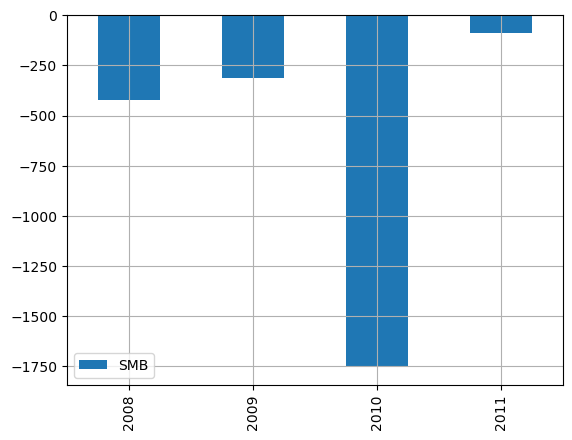

In [16]:
df_clim[['SMB']].loc[slice(2008,2011)].plot.bar()
plt.grid()

#### Detrended Timeseires

In [19]:
def detrend(x,y, order=2,plot=False):
    y=pd.to_numeric(y)
    # Detrend a timeseries
    if order==2:
        a,b,c=np.polyfit(x, y, order)
        detrend = a*x**2 + b*x + c 
    elif order==1:
        a,b=np.polyfit(x, y, order)
        detrend = a*x + b
    elif order==3:
        a,b,c,d=np.polyfit(x, y, order)
        detrend = a*x**3+b*x**2 + c*x + d
    else:
        return "Invalid Model Order"

    detrend = y-detrend
    if plot:
        plt.plot(x,y,label='OG');
        plt.plot(x,detrend,label='detrend');
        plt.title(f'Detrend order no.: {order}');
        plt.grid();
        plt.legend();

    return detrend 

In [18]:
df_clim.columns

Index(['Temp_5000', 'Prcp_5000', 'Temp_JJA_5000', 'Prcp_JJA_5000',
       'Temp_DJF_5000', 'Prcp_DJF_5000', 'Temp_MJJ_5000', 'Prcp_MJJ_5000',
       'Temp_AMJ_5000', 'Prcp_AMJ_5000', 'SMB', 'ELA', 'Temp_5000_anom',
       'Temp_5000_std_anom', 'Prcp_5000_anom', 'Prcp_5000_std_anom',
       'Temp_JJA_5000_anom', 'Temp_JJA_5000_std_anom', 'Prcp_JJA_5000_anom',
       'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_anom',
       'Temp_DJF_5000_std_anom', 'Prcp_DJF_5000_anom',
       'Prcp_DJF_5000_std_anom', 'Temp_MJJ_5000_anom',
       'Temp_MJJ_5000_std_anom', 'Prcp_MJJ_5000_anom',
       'Prcp_MJJ_5000_std_anom', 'Temp_AMJ_5000_anom',
       'Temp_AMJ_5000_std_anom', 'Prcp_AMJ_5000_anom',
       'Prcp_AMJ_5000_std_anom', 'SMB_anom', 'SMB_std_anom', 'ELA_anom',
       'ELA_std_anom', 'Nino_3.4', 'Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA',
       'ONI_DJF', 'ONI_AMJ', 'SOI', 'SOI_JJA', 'SOI_DJF'],
      dtype='object')

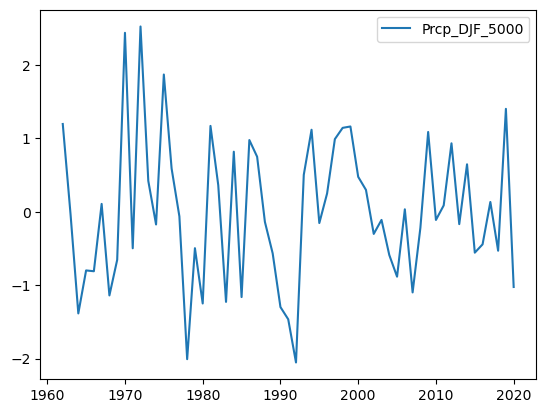

In [20]:
df_clim_detrend=pd.DataFrame(index=yrs)
cols = ['Temp_5000', 'Prcp_5000', 'Temp_JJA_5000', 'Prcp_JJA_5000',
       'Temp_DJF_5000', 'Prcp_DJF_5000', 'Temp_MJJ_5000', 'Prcp_MJJ_5000',
       'Temp_AMJ_5000', 'Prcp_AMJ_5000', 'SMB', 'ELA', 'Temp_5000_anom']
for col in cols:
    yy=detrend(df_clim_detrend.index,df_clim[col],order=3)
    df_clim_detrend[f'{col}'] = yy/yy.std()

df_clim_detrend[['Prcp_DJF_5000']].plot();

In [21]:
# Add ENSO Vars
df_clim_detrend['Nino_3.4']=nino
df_clim_detrend['Nino_3.4_JJA']=nino_winter
df_clim_detrend['Nino_3.4_DJF']=nino_summer

df_clim_detrend['ONI_JJA']=ONI_JJA
df_clim_detrend['ONI_DJF']=ONI_DJF
df_clim_detrend['ONI_AMJ']=ONI_AMJ

df_clim_detrend['SOI']=SOI
df_clim_detrend['SOI_JJA']=SOI_JJA
df_clim_detrend['SOI_DJF']=SOI_DJF

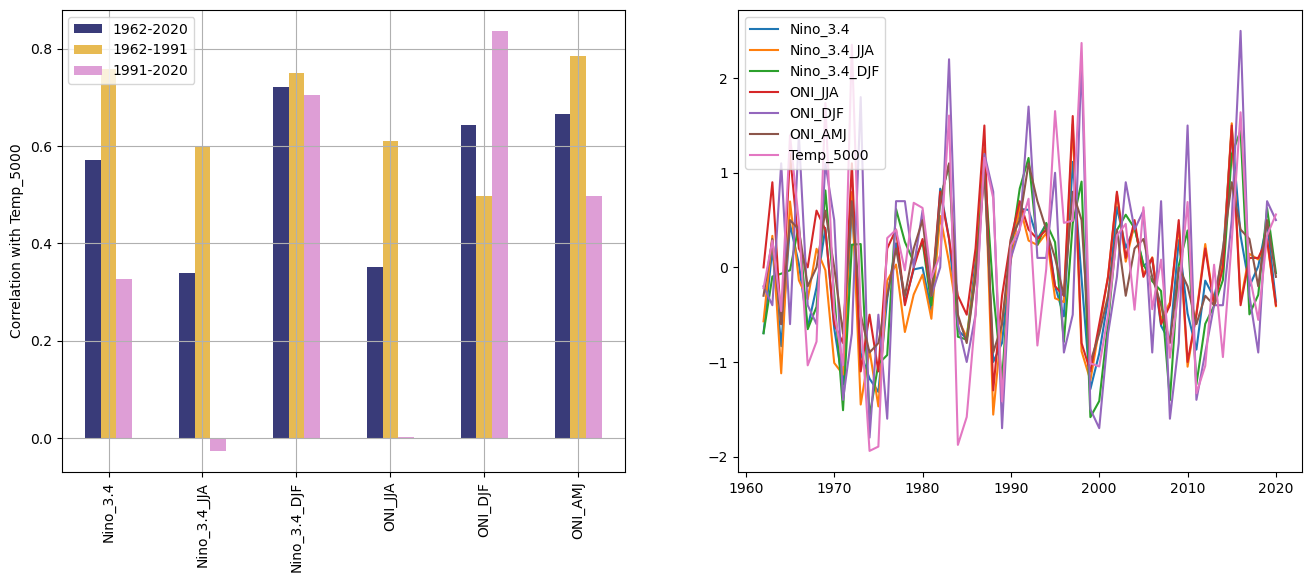

In [21]:
var='Temp_5000' # 'SMB_std_anom'

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ',]# 'SOI','SOI_JJA', 'SOI_DJF']

# vars = ['Temp_5000',
#        'Temp_JJA_5000', 
#        'Temp_DJF_5000']

df_corr=pd.DataFrame()

df_corr['1962-2020'] = df_clim_detrend.corr().loc[var][vars]
df_corr['1962-1991'] = df_clim_detrend.loc[slice(1962,1962+29)].corr().loc[var][vars]
df_corr['1991-2020'] = df_clim_detrend.loc[slice(1991,1991+29)].corr().loc[var][vars]

f,(ax,ax1)=plt.subplots(1,2,figsize=(16,6))
ax.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,3)))
df_corr.plot.bar(ax=ax,grid=True, color=plt.cm.tab20b(np.linspace(0,1,3)),
             #    ['lightsalmon','indianred','darkred'],
                 ylabel=f'Correlation with {var}');
vars.append(var)
df_clim_detrend[vars].plot(ax=ax1);

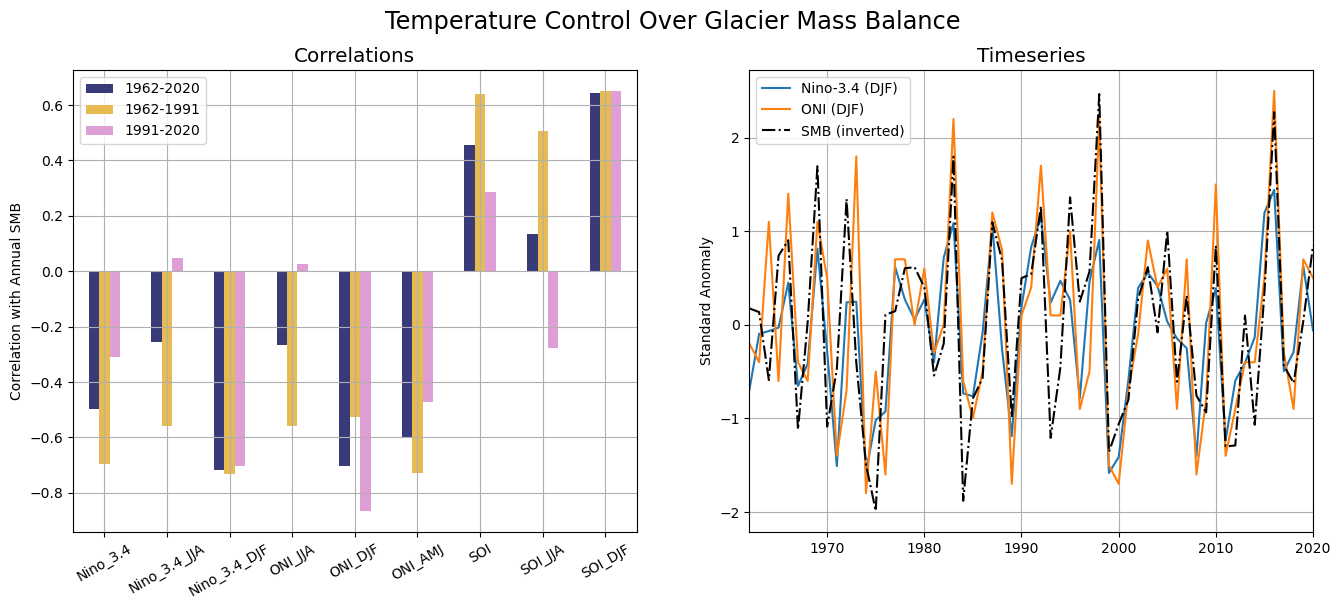

In [22]:
var='SMB' # 'SMB_std_anom'

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ', 'SOI','SOI_JJA', 'SOI_DJF']

# vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF'
#       , 'SOI','SOI_JJA', 'SOI_DJF']

# vars = [ 'Temp_5000_std_anom',
#        'Prcp_5000_std_anom', 'Temp_JJA_5000_std_anom',
#        'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_std_anom',
#        'Prcp_DJF_5000_std_anom', 'Temp_MJJ_5000_std_anom',
#        'Prcp_MJJ_5000_std_anom', 'Temp_AMJ_5000_std_anom',
#        'Prcp_AMJ_5000_std_anom']

# vars = ['Prcp_5000',
#        'Prcp_JJA_5000', 
#        'Prcp_DJF_5000',
#        ]

# vars = ['Temp_5000',
#        'Temp_JJA_5000', 
#        'Temp_DJF_5000']

df_corr=pd.DataFrame()

df_corr['1962-2020'] = df_clim_detrend.corr().loc[var][vars]
df_corr['1962-1991'] = df_clim_detrend.loc[slice(1962,1962+29)].corr().loc[var][vars]
df_corr['1991-2020'] = df_clim_detrend.loc[slice(1991,1991+29)].corr().loc[var][vars]

f,(ax,ax1)=plt.subplots(1,2,figsize=(16,6))
ax.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,3)))
df_corr.plot.bar(ax=ax,grid=True, color=plt.cm.tab20b(np.linspace(0,1,3)),
             #    ['lightsalmon','indianred','darkred'],
                 ylabel='Correlation with Annual SMB');
ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30);
#plt.xticks(rotation=30);
ax.set_title('Correlations',fontsize='x-large');

# Timeseriers
if vars[0].split('_')[0]=='Temp':
    df_clim_detrend[vars].plot(ax=ax1)
    df_clim_detrend['var_r']=df_clim_detrend[var]*-1
    df_clim_detrend['var_r'].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Annual','JJA','DJF','SMB (inverted)']
    
    ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30); # For First Plot

    
elif vars[0].split('_')[0]=='Prcp':
    df_clim_detrend[vars].plot(ax=ax1)
    df_clim_detrend[var].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Annual','JJA','DJF','SMB']
    
    ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30);

    
elif vars[0].split('_')[0]=='Nino':
    df_clim_detrend[['Nino_3.4_DJF','ONI_DJF']].plot(ax=ax1) #labels=['Anual','JJA','DJF']) #['Nino_3.4','Nino_3.4_JJA','Nino_3.4_DJF','SOI_DJF']
    df_clim_detrend['var_r']=df_clim_detrend[var]*-1
    df_clim_detrend['var_r'].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Nino-3.4 (DJF)','ONI (DJF)','SMB (inverted)']#['Nino Annual','Nino JJA','Nino DJF','ONI DJF','SMB (inverted)']

    ax.set_xticks(np.arange(len(vars)),labels=vars,rotation=30)

    
else:
    df_clim_detrend[var].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    
    

ax1.legend(handles = ax1.get_legend_handles_labels()[0],
           labels=labels);
ax1.set_xlim([1962,2020]);
ax1.set_ylabel('Standard Anomaly');
ax1.set_title('Timeseries',fontsize='x-large');

f.suptitle('Temperature Control Over Glacier Mass Balance',fontsize='xx-large');

In [77]:
path = os.path.join(OUTPUTS, 'Temp_SMB_detrend_corr_with_ts.png')
f.savefig(path)

In [115]:
vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ', 'SOI','SOI_JJA', 'SOI_DJF']
df_clim_detrend.corr().loc['Prcp_5000'][vars] # .loc[slice(1991,1991+29)] # .loc[slice(1991,1991+29)]

Nino_3.4       -0.084913
Nino_3.4_JJA   -0.040015
Nino_3.4_DJF   -0.190447
ONI_JJA        -0.041303
ONI_DJF        -0.250584
ONI_AMJ        -0.114600
SOI             0.070503
SOI_JJA        -0.079190
SOI_DJF         0.251774
Name: Prcp_5000, dtype: float64

In [114]:
data=df_clim_detrend#.loc[slice(1962,1962+29)]
for col in df_clim_detrend.columns:
    r = stats.pearsonr(data['Temp_5000'],data[col])
    if r.pvalue<0.05:
        print(col,':',r.statistic)
    else:
        print(col,': Not Significant',r.statistic)


Temp_5000 : 0.9999999999999998
Prcp_5000 : Not Significant -0.17258408929226604
Temp_JJA_5000 : 0.8088701540954552
Prcp_JJA_5000 : -0.4469721135604724
Temp_DJF_5000 : 0.8808377673875643
Prcp_DJF_5000 : Not Significant -0.10040586820227712
Temp_MJJ_5000 : 0.8314723907384977
Prcp_MJJ_5000 : -0.43055352723813883
Temp_AMJ_5000 : 0.8263966121719352
Prcp_AMJ_5000 : Not Significant -0.23733072169029676
SMB : -0.9314749381137648
ELA : 0.945161083611582
Temp_5000_anom : 1.0
Nino_3.4 : 0.5714860229390253
Nino_3.4_JJA : 0.3397402243571716
Nino_3.4_DJF : 0.7224981866440233
ONI_JJA : 0.35102570687133505
ONI_DJF : 0.6440677601063008
ONI_AMJ : 0.6652481421816463
SOI : -0.5267584573512858
SOI_JJA : Not Significant -0.2529298218575997
SOI_DJF : -0.6126268861796185
var_r : 0.9314749381137648


In [73]:
data=df_clim_detrend#.loc[slice(1991,1991+29)]#.loc[slice(1962,1962+29)]
for col in df_clim_detrend.columns:
    r = stats.pearsonr(data['SMB'],data[col])
    if r.pvalue<0.05:
        print(col,':',r.statistic)
    else:
        print(col,': Not Significant',r.statistic)

Temp_5000 : -0.9314749381137648
Prcp_5000 : 0.4706975267864207
Temp_JJA_5000 : -0.6478331228130622
Prcp_JJA_5000 : 0.40755315267063225
Temp_DJF_5000 : -0.8893741076669434
Prcp_DJF_5000 : 0.3325079935513074
Temp_MJJ_5000 : -0.6963421444794
Prcp_MJJ_5000 : 0.4163602168139
Temp_AMJ_5000 : -0.7553267437043351
Prcp_AMJ_5000 : 0.3325012532568856
SMB : 1.0
ELA : -0.9909431472018068
Temp_5000_anom : -0.9314749381152684
Nino_3.4 : -0.4976556098386717
Nino_3.4_JJA : -0.25728549152381475
Nino_3.4_DJF : -0.7166323112403131
ONI_JJA : -0.26599666478998213
ONI_DJF : -0.704704553874968
ONI_AMJ : -0.6001850962570741
SOI : 0.45543160822859374
SOI_JJA : Not Significant 0.13296235793549693
SOI_DJF : 0.6430765377016198
var_r : -1.0


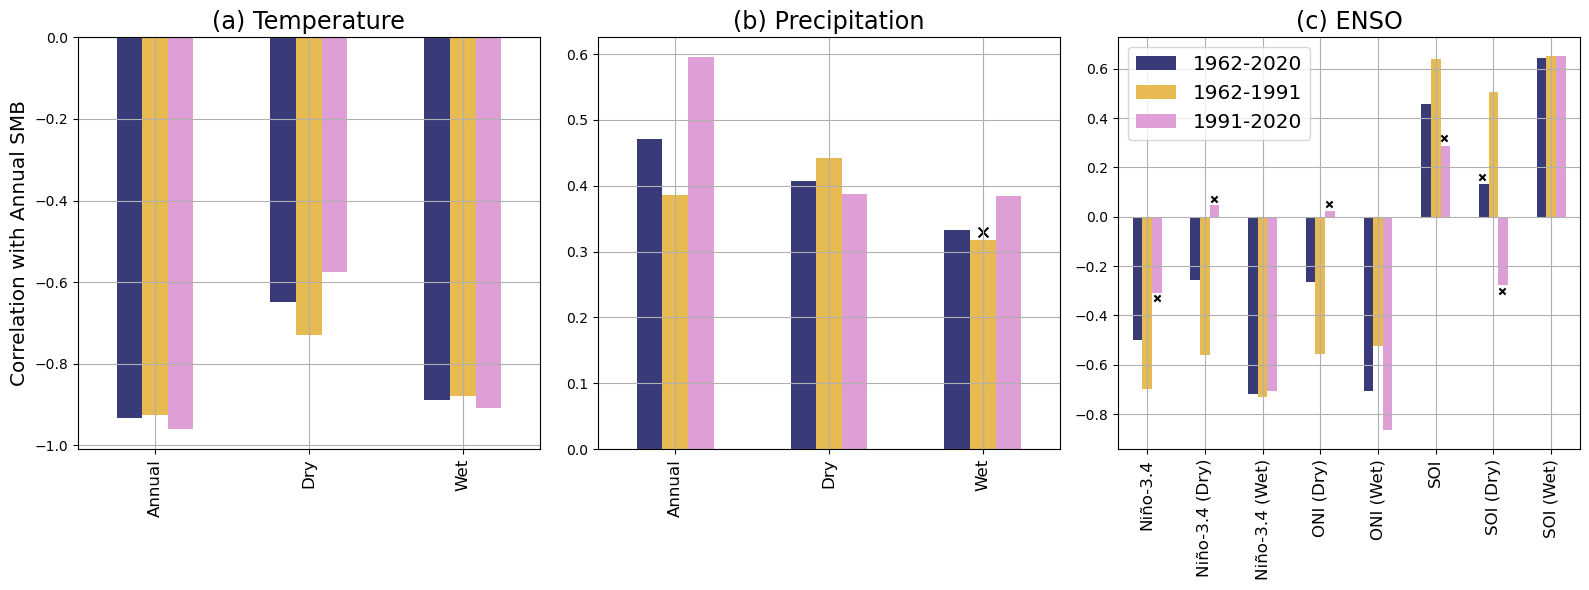

In [31]:
f,axs = plt.subplots(1,3,figsize=(16,6),sharey=False)

var='SMB' # 'SMB_std_anom'

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ', 'SOI','SOI_JJA', 'SOI_DJF']

# vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF'
#       , 'SOI','SOI_JJA', 'SOI_DJF']

# vars = [ 'Temp_5000_std_anom',
#        'Prcp_5000_std_anom', 'Temp_JJA_5000_std_anom',
#        'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_std_anom',
#        'Prcp_DJF_5000_std_anom', 'Temp_MJJ_5000_std_anom',
#        'Prcp_MJJ_5000_std_anom', 'Temp_AMJ_5000_std_anom',
#        'Prcp_AMJ_5000_std_anom']

# Temp
varsvars = [['Temp_5000','Temp_JJA_5000','Temp_DJF_5000'],['Prcp_5000','Prcp_JJA_5000','Prcp_DJF_5000'],['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'SOI','SOI_JJA', 'SOI_DJF']]
for i,vars in enumerate(varsvars):
    
    df_corr=pd.DataFrame()
    
    df_corr['1962-2020'] = df_clim_detrend.corr().loc[var][vars]
    df_corr['1962-1991'] = df_clim_detrend.loc[slice(1962,1962+29)].corr().loc[var][vars]
    df_corr['1991-2020'] = df_clim_detrend.loc[slice(1991,1991+29)].corr().loc[var][vars]
    
    ax=axs[i]
    ax.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,3)))
    df_corr.plot.bar(ax=ax,grid=True, color=plt.cm.tab20b(np.linspace(0,1,3)),
                 #    ['lightsalmon','indianred','darkred'],
                     ylabel='');
    if i<2:
        ax.set_xticks(np.arange(3),labels=['Annual','Dry','Wet'],fontsize='large',rotation=90);
        ax.get_legend().remove()
    else:
        labels=[]
        xticks = ax.get_xticklabels()
        # for tick in xticks:
        #     label = tick.get_text()
        #     labels.append(label)
        labels = ['Niño-3.4','Niño-3.4 (Dry)','Niño-3.4 (Wet)','ONI (Dry)','ONI (Wet)','SOI','SOI (Dry)','SOI (Wet)']
        ax.set_xticks(np.arange(8),labels,fontsize='large',rotation=90);
    if i==0:
        ax.set_ylabel('Correlation with Annual SMB',fontsize='x-large');
        
ax.legend(fontsize='x-large')
ax.get_xticks()
#ax.set_title('Temperature',fontsize='x-large');
titles = ['(a) Temperature','(b) Precipitation','(c) ENSO']
for title, ax in zip(titles,axs):
    ax.set_title(title,fontsize='xx-large');

# Insignificant Variables
axs[1].scatter(x=2,y=0.33,s=50,marker='x',color='k');
xx= [5.81,0.165,1.15,3.15,5.15,6.155]
yy=[0.14+0.02,-0.31-0.02,0.05+0.02,0.03+0.02,0.3+0.02,-0.28-0.02]
axs[2].scatter(x=xx,y=yy,s=20,marker='x',color='k');

plt.tight_layout()

In [32]:
path = os.path.join(OUTPUTS, 'SMB_correlations_v3.png')
f.savefig(path)

### Trend Analysis

In [107]:
def manken(y0,y1,dfm):
    slopes=[]
    ps=[]
    data=dfm.loc[slice(y0,y1)]
    cols=data.columns.values
    for col in cols:
        man_ken = mk.original_test(data[col])
        slopes.append(man_ken.slope)
        ps.append(man_ken.p)
    return pd.DataFrame(index=cols,columns=['Change_per_year','p-value'],data=np.array([slopes,ps]).T)#slopes, ps, cols


manken(2000,2020,df_clim[['Temp_5000','Temp_JJA_5000','Temp_DJF_5000','Prcp_5000','Prcp_JJA_5000','Prcp_DJF_5000','SMB']])
#pd.DataFrame(index=c,columns=['Slope','p-value'],data=np.array([a,b]).T)


Change_per_year   p-value
Temp_5000             0.027232  0.020063
Temp_JJA_5000         0.021081  0.043053
Temp_DJF_5000         0.024684  0.096747
Prcp_5000             0.445833  0.739764
Prcp_JJA_5000        -0.120247  0.414891
Prcp_DJF_5000         0.499272  0.785797
SMB                 -42.420909  0.096747

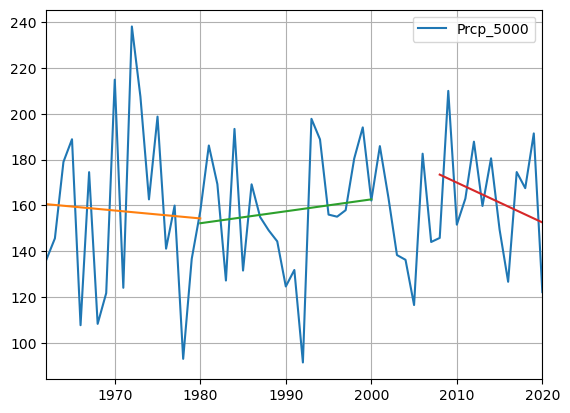

In [34]:
f,ax=plt.subplots()
var = 'Prcp_5000'
df_clim[[var]].plot(ax=ax);
ax.set_xlim([1962,2020])
#ax.set_xticks(np.arange(1962,2021,2),rot=90)

y0=1962
y1=1980
data=df_clim[var].loc[slice(y0,y1)]
# Simple Linear Regression
reg = stats.linregress(x=[i for i in range(len(data.values))],y=list(data.values)) #m, intercept, r_value, p_value, std_err = 
# Mann-Kendall Test
man_ken = mk.original_test(data)
ax.plot(np.arange(y0,y1+1),[man_ken.intercept + man_ken.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Mann-Kendall')
#plt.plot(np.arange(y0,y1+1),[reg.intercept + reg.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Linear Regression')

y0=1980
y1=2000
data=df_clim[var].loc[slice(y0,y1)]
# Simple Linear Regression
reg = stats.linregress(x=[i for i in range(len(data.values))],y=list(data.values)) #m, intercept, r_value, p_value, std_err = 
# Mann-Kendall Test
man_ken = mk.original_test(data)
ax.plot(np.arange(y0,y1+1),[man_ken.intercept + man_ken.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Mann-Kendall')
#plt.plot(np.arange(y0,y1+1),[reg.intercept + reg.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Linear Regression')

y0=2008
y1=2020
data=df_clim[var].loc[slice(y0,y1)]
# Simple Linear Regression
reg = stats.linregress(x=[i for i in range(len(data.values))],y=list(data.values)) #m, intercept, r_value, p_value, std_err = 
# Mann-Kendall Test
man_ken = mk.original_test(data)
ax.plot(np.arange(y0,y1+1),[man_ken.intercept + man_ken.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Mann-Kendall')
#plt.plot(np.arange(y0,y1+1),[reg.intercept + reg.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Linear Regression')

#df_clim[[var]].loc[df_clim[var]>0].plot(ax=ax);
ax.grid();

In [36]:
# 44 neg SMB yers, 15 pos
df_clim[['SMB']].sort_values(by='SMB')

SMB
2016 -3064.562105
1998 -2642.762546
2020 -2047.025946
2010 -1754.042894
2005 -1716.027837
1983 -1702.063893
1995 -1675.668464
2015 -1510.789079
1992 -1510.330550
1969 -1470.035510
2019 -1383.432699
2003 -1342.991010
2013 -1256.401688
1987 -1240.079350
2007 -1235.324074
1972 -1198.604882
1997 -1110.478060
2002 -1042.436989
2017  -951.277625
1988  -944.370865
1991  -909.992649
1966  -857.255835
1990  -846.413829
2018  -832.364645
1996  -825.803078
2004  -824.681006
1965  -733.262559
1979  -694.749828
1978  -670.948507
1980  -541.949415
2006  -473.569650
2008  -421.577608
2014  -363.654441
1962  -326.400773
2009  -311.690715
1977  -294.373202
1963  -280.406024
1976  -252.861113
1994  -207.398597
1968  -156.701767
2001  -154.400480
2012  -127.559261
1982  -102.331542
2011   -87.933607
2000    81.530381
1986   100.441834
1973   179.704447
1981   186.965320
1971   240.658639
1985   297.422180
1964   306.589536
1999   348.933654
1989   354.948329
1993   417.661136
1970   730.445141
1967   748.446525
1974  1031.220378
1984  1184.719348
1975  1415.302860

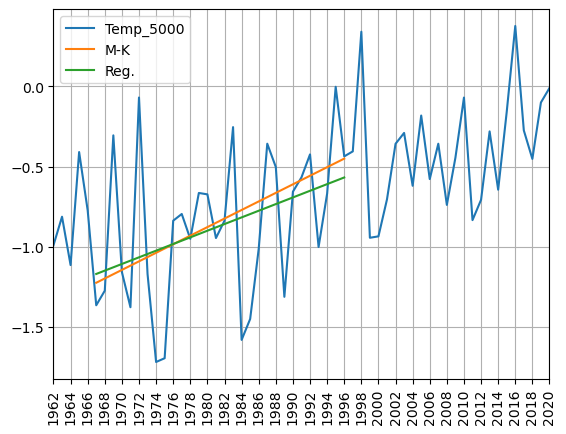

In [157]:
var = 'Temp_5000'
df_clim[[var]].plot();
plt.xlim([1962,2020])
plt.xticks(np.arange(1962,2021,2),rotation=90);
# plt.plot(np.arange(y0,y1+1),[man_ken.intercept + man_ken.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Mann-Kendall')
# plt.plot(np.arange(y0,y1+1),[reg.intercept + reg.slope*i for i in range(len(np.arange(y0,y1+1)))],label='Linear Regression')
plt.grid();
# plt.legend();
# plt.title(str(round(man_ken.slope * 10,3))+' | '+str(round(reg.slope * 10,3 )));
# print(man_ken.p,reg.pvalue)

yr0=1967
man_ken = mk.original_test(df_clim[var].loc[slice(yr0,yr0+29)])
reg = stats.linregress(x=np.arange(yr0,yr0+29+1),y=list(df_clim[var].loc[slice(yr0,yr0+29)].values))

yrs=np.arange(yr0,yr0+29+1)
plt.plot(yrs,[man_ken.intercept + man_ken.slope*i for i in range(len(yrs))],label='M-K');
plt.plot(yrs,[reg.intercept + reg.slope*i for i in yrs],label='Reg.');
plt.legend();

In [137]:
yrs[0]

(1962, 1999)

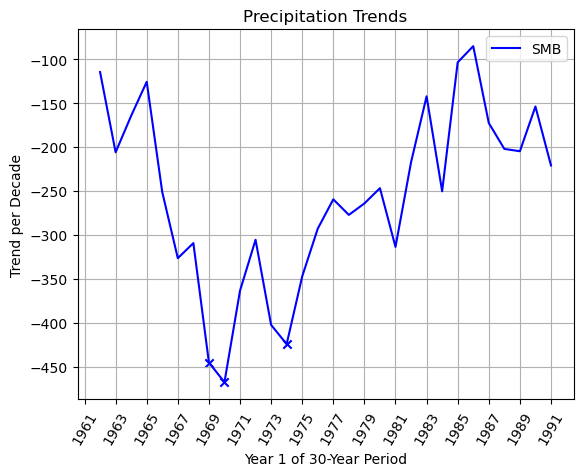

In [105]:
nyears=30 # window for trend analysis
vars = ['SMB']
colors=['blue','orange','green']
#yr0=1962
f,ax=plt.subplots()

for var , color in zip(vars,colors):
    slopes=[]
    slopes_mann=[]
    ps=[]
    yrs=[]
    for yr1 in df_clim.loc[1962+nyears-1:].index.values:
        yr0=yr1-(nyears-1)
        yrs.append((yr0,yr1))
        man_ken = mk.original_test(df_clim[var].loc[slice(yr0,yr1)])
        reg = stats.linregress(x=np.arange(yr0,yr1+1),y=list(df_clim[var].loc[slice(yr0,yr1)].values))
        slope=reg.slope*10
        slopes.append(slope)
        ps.append(man_ken.p)
        slopes_mann.append(man_ken.slope*10)
        
    for i,(yr0,yr1) in enumerate(yrs):
        if ps[i]<0.05:
            ax.scatter(yr0,slopes[i],marker='x',color=color)
            #ax.scatter(yr0,slopes_mann[i],marker='x',color='purple')
    
    ax.plot([y[0] for y in yrs],slopes,label=var,color=color);
#ax.plot([y[0] for y in yrs],slopes_mann, color='purple',label='T-S');
plt.grid();
plt.xticks(np.arange(1961,1992,2),rotation=60);
plt.legend();
plt.xlabel(f'Year 1 of {nyears}-Year Period')
plt.ylabel('Trend per Decade');
plt.title('Precipitation Trends');

In [95]:
path = os.path.join(OUTPUTS, 'Prcp_30yr_running_trend.png')
f.savefig(path)

In [101]:
yr0=1962
yr1=2020
stats.linregress(x=np.arange(yr0,yr1+1),y=list(df_clim['Temp_DJF_5000'].loc[slice(yr0,yr1)].values))

LinregressResult(slope=0.015208171381486831, intercept=-30.649583752472186, rvalue=0.43070244400699526, pvalue=0.0006612070849564389, stderr=0.004220914481782696, intercept_stderr=8.404148127205572)

In [96]:
mk.original_test(df_clim['Temp_5000'])

Mann_Kendall_Test(trend='increasing', h=True, p=6.822018859597989e-06, z=4.499167195440045, Tau=0.4026884862653419, s=689.0, var_s=23383.666666666668, slope=0.015376084380679667, intercept=-1.1103704035547048)

#### Variable Correlations

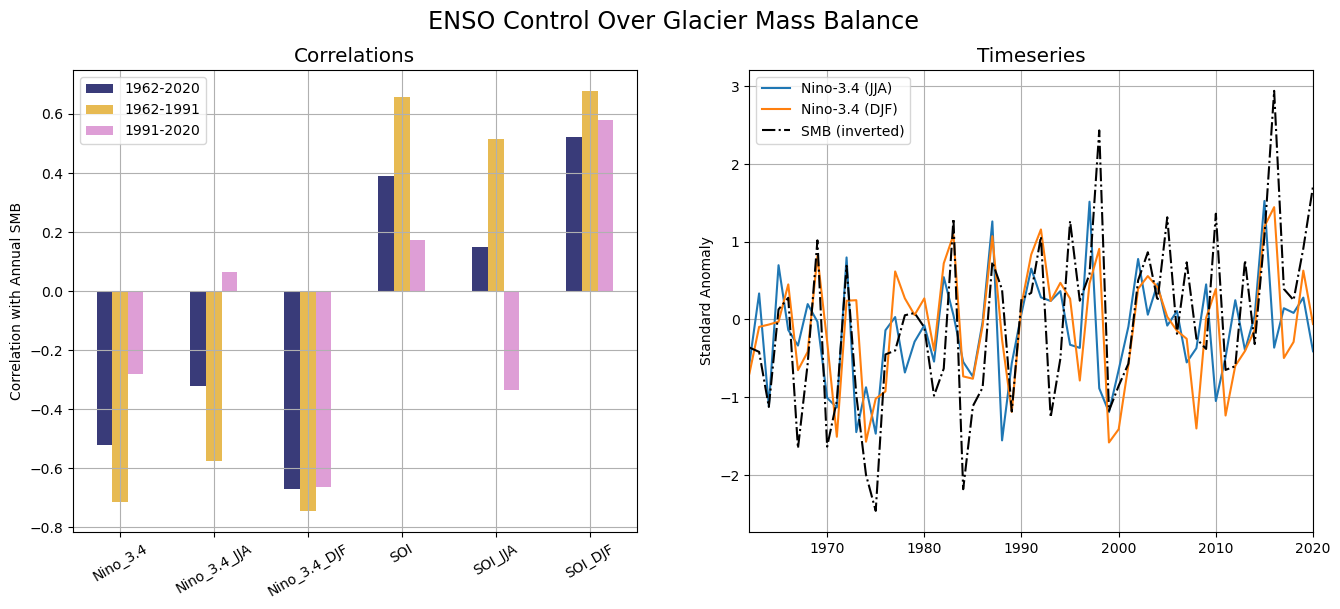

In [26]:
# df_corr=df_clim[['Temp_5000_std_anom','Temp_JJA_5000_std_anom','Temp_DJF_5000_std_anom','Temp_AMJ_5000_std_anom',
#                  'SMB_std_anom','Nino_3.4_DJF']].corr()

# df_corr=df_clim[['Temp_5000_std_anom','Temp_DJF_5000_std_anom','Temp_JJA_5000_std_anom',
#                  'Prcp_5000_std_anom','Prcp_DJF_5000_std_anom','Prcp_JJA_5000_std_anom','Prcp_AMJ_5000_std_anom',
#                  'SMB_std_anom','Nino_3.4_DJF']].corr()

# df_corr=df_clim[['Prcp_5000_std_anom','Prcp_JJA_5000_std_anom','Prcp_DJF_5000_std_anom','Prcp_AMJ_5000_std_anom',
#                  'SMB_std_anom','Nino_3.4','SOI','ONI_JJA', 'ONI_DJF','ONI_AMJ']].corr()

# df_corr=df_clim[['SMB_std_anom', 'Nino_3.4',
#        'Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 'ONI_DJF', 'ONI_AMJ', 'SOI',
#        'SOI_JJA', 'SOI_DJF']].corr()
                 
       # 'Prcp_5000_std_anom', 'Temp_JJA_5000_std_anom','Temp_MJJ_5000_std_anom','Prcp_MJJ_5000_std_anom',
       # 'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_std_anom',
       # 'Prcp_DJF_5000_std_anom', 'SMB_std_anom', 'ELA_std_anom', 'Nino_3.4',
       # 'Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 'ONI_DJF', 'SOI', 'SOI_JJA',
       # 'SOI_DJF']].corr()

var='SMB_std_anom' # 'SMB_std_anom'

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ', 'SOI','SOI_JJA', 'SOI_DJF']

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF'
      , 'SOI','SOI_JJA', 'SOI_DJF']

# vars = [ 'Temp_5000_std_anom',
#        'Prcp_5000_std_anom', 'Temp_JJA_5000_std_anom',
#        'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_std_anom',
#        'Prcp_DJF_5000_std_anom', 'Temp_MJJ_5000_std_anom',
#        'Prcp_MJJ_5000_std_anom', 'Temp_AMJ_5000_std_anom',
#        'Prcp_AMJ_5000_std_anom']

vars = ['Prcp_5000_std_anom',
       'Prcp_JJA_5000_std_anom', 
       'Prcp_DJF_5000_std_anom']

# vars = ['Temp_5000_std_anom',
#        'Temp_JJA_5000_std_anom', 
#        'Temp_DJF_5000_std_anom']

df_corr=pd.DataFrame()

df_corr['1962-2020'] = df_clim.corr().loc[var][vars]
df_corr['1962-1991'] = df_clim.loc[slice(1962,1962+29)].corr().loc[var][vars]
df_corr['1991-2020'] = df_clim.loc[slice(1991,1991+29)].corr().loc[var][vars]

f,(ax,ax1)=plt.subplots(1,2,figsize=(16,6))
ax.set_prop_cycle('color',plt.cm.cool(np.linspace(0,1,3)))
df_corr.plot.bar(ax=ax,grid=True, color=plt.cm.tab20b(np.linspace(0,1,3)),
             #    ['lightsalmon','indianred','darkred'],
                 ylabel='Correlation with Annual SMB');
ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30);
#plt.xticks(rotation=30);
ax.set_title('Correlations',fontsize='x-large');

# Timeseriers
if vars[0].split('_')[0]=='Temp':
    df_clim[vars].plot(ax=ax1)
    df_clim['var_r']=df_clim[var]*-1
    df_clim['var_r'].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Annual','JJA','DJF','SMB (inverted)']
    
    ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30); # For First Plot

    
elif vars[0].split('_')[0]=='Prcp':
    df_clim[vars].plot(ax=ax1)
    df_clim[var].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Annual','JJA','DJF','SMB']
    
    ax.set_xticks(np.arange(3),labels=['Annual','JJA','DJF'],rotation=30);

    
elif vars[0].split('_')[0]=='Nino':
    df_clim[['Nino_3.4_JJA','Nino_3.4_DJF']].plot(ax=ax1) #labels=['Anual','JJA','DJF']) #['Nino_3.4','Nino_3.4_JJA','Nino_3.4_DJF','SOI_DJF']
    df_clim['var_r']=df_clim[var]*-1
    df_clim['var_r'].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    labels=['Nino-3.4 (JJA)','Nino-3.4 (DJF)','SMB (inverted)']#['Nino Annual','Nino JJA','Nino DJF','ONI DJF','SMB (inverted)']

    ax.set_xticks(np.arange(len(vars)),labels=vars,rotation=30)

    
else:
    df_clim[var].plot(ax=ax1,linestyle='-.',color='k',grid=True);
    
    

ax1.legend(handles = ax1.get_legend_handles_labels()[0],
           labels=labels);
ax1.set_xlim([1962,2020]);
ax1.set_ylabel('Standard Anomaly');
ax1.set_title('Timeseries',fontsize='x-large');

f.suptitle('ENSO Control Over Glacier Mass Balance',fontsize='xx-large');

In [158]:
path = os.path.join(OUTPUTS, 'Temp_SMB_corr_with_ts.png')
f.savefig(path)

In [408]:
df_corr

1962-2020  1962-1991  1991-2020
Nino_3.4      -0.520338  -0.713529  -0.279707
Nino_3.4_JJA  -0.320990  -0.574205   0.063457
Nino_3.4_DJF  -0.668912  -0.743962  -0.661597
ONI_JJA       -0.220251  -0.558408   0.061485
ONI_DJF       -0.621921  -0.518431  -0.831965
ONI_AMJ       -0.539458  -0.725472  -0.398423
SOI            0.388063   0.658192   0.173664
SOI_JJA        0.149805   0.515448  -0.333722
SOI_DJF        0.523012   0.677730   0.578382

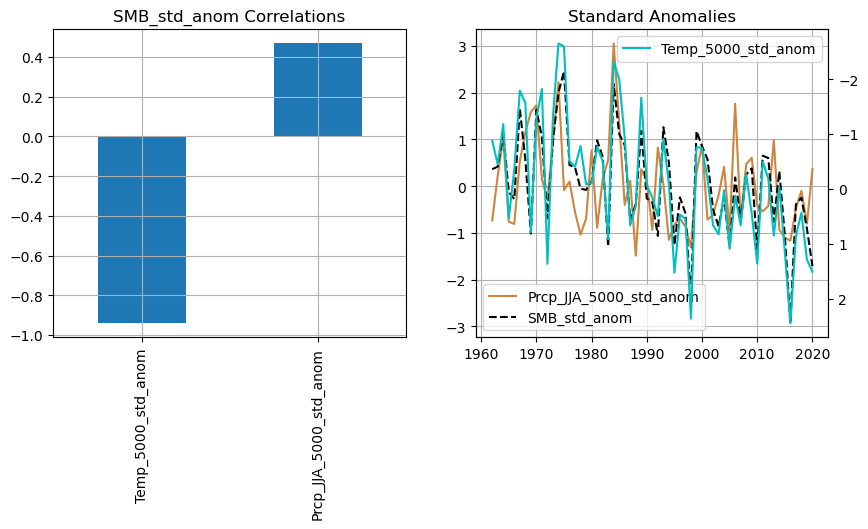

In [84]:
df_corr= df_clim.corr()
var='SMB_std_anom' # 'SMB_std_anom'

vars=['Nino_3.4','Nino_3.4_JJA', 'Nino_3.4_DJF', 'ONI_JJA', 
        'ONI_DJF', 'ONI_AMJ', 'SOI','SOI_JJA', 'SOI_DJF']

# vars = [ 'Temp_5000_std_anom',
#        'Prcp_5000_std_anom', 'Temp_JJA_5000_std_anom',
#        'Prcp_JJA_5000_std_anom', 'Temp_DJF_5000_std_anom',
#        'Prcp_DJF_5000_std_anom', 'Temp_MJJ_5000_std_anom',
#        'Prcp_MJJ_5000_std_anom', 'Temp_AMJ_5000_std_anom',
#        'Prcp_AMJ_5000_std_anom']

vars = ['Temp_5000_std_anom','Prcp_JJA_5000_std_anom']

f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax3=ax2.twinx()
ax3.invert_yaxis()
ax3.set_prop_cycle(color=['c','m','y'])
ax2.set_prop_cycle(color=['peru','maroon','linen'])

# sr1 = df_corr_91_20.loc[var]
# sr1=sr1[vars]

# sr2 = df_corr_62_91.loc[var]
# sr2=sr2[vars]

# sr3 = df_corr.loc[var]
# sr3=sr3[vars]


sr=df_corr.loc[var][vars]
#sr.pop(var)
sr.plot.bar(ax=ax1)
ax1.set_title(f'{var} Correlations');
ax1.grid();


# #df_clim['Temp_5000_std_anom']*=-1

#df_clim.plot.scatter(x=var,y='Prcp_DJF_5000_std_anom',ax=ax2); #Prcp_5000_std_anom
#df_clim[[var,'Prcp_5000_std_anom','Temp_5000_std_anom']].plot(ax=ax2)
#vars = ['Temp_5000_std_anom','Prcp_5000_std_anom']

vars_ax2 = []
vars_ax3 = []
for v in vars:
    if df_corr.loc[var,v]>0:
        vars_ax2.append(v)
    else:
        vars_ax3.append(v)
        
df_clim[vars_ax2].plot(ax=ax2)
df_clim[vars_ax3].plot(ax=ax3)
df_clim[[var]].plot(ax=ax2,color='k',linestyle='--')
ax2.grid();
#ax2.set_ylabel('Standard Anomaly');
ax2.set_title('Standard Anomalies');
#ax2.set_xlim([1960,1980]);
ax2.legend(loc='lower left');

#### Observations:
- Among precipitation variables, SMB is most closely ccorrelated with dry season (JJA) precipitation
- Among temperature variables, SMB is most closely correlation with mean annual temperature
- Among ENSO indices, SMB is most closely correlated with Nino 3.4 DJF, which is closely correlated to DJF (wet season) temperature.
- Together, these suggest that temperature is the first order control on mass balance over the study period, with dry season precipitaiton dynamics playing a secondary modulating role. This is somewhat consistent with previous studies, which also note the significance of dry season precipitaiton dynamics.

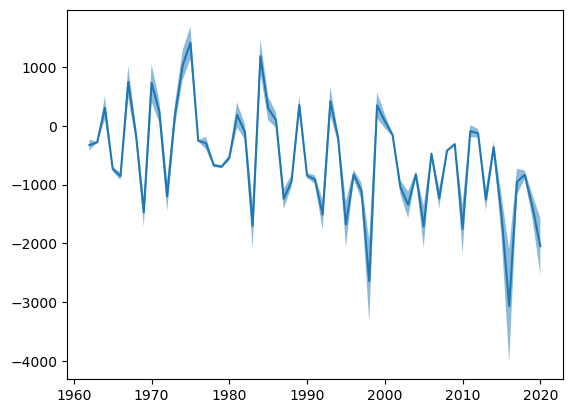

In [34]:
smb_mean = np.mean(smbs,axis=0).flatten()
smb_std = np.std(smbs,axis=0).flatten()

plt.plot(yrs,smb_mean)
plt.fill_between(x=yrs, y1=smb_mean+smb_std, y2=smb_mean-smb_std,alpha=0.5);

### Drivers of Glacier Loss

In [16]:
k=1.2

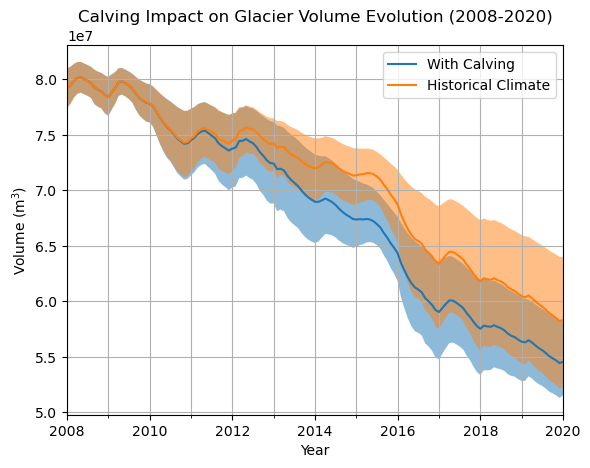

In [39]:

f,ax=plt.subplots()

vols=[]
vols_percent_with_calving=[]
for tb in df_raw.temp_bias:
    suf=f'_tb{tb}_calving_{k}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        vols.append(vol)
        vol_percent = vol.sel(time=2008) - vol 
        vol_percent /= vol.sel(time=2008)
        vol_percent *=100
        vols_percent_with_calving.append(vol_percent)
        ds.close() 

vol_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='With Calving',ax=ax)
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5)

vols=[]
vols_percent_no_calving=[]
for tb in df_raw.temp_bias:
    suf=f'_historical_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        vols.append(vol)
        vol_percent = vol.sel(time=2008) - vol 
        vol_percent /= vol.sel(time=2008)
        vol_percent *=100
        vols_percent_no_calving.append(vol_percent)
        ds.close() 

vol_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='Historical Climate',ax=ax)
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5);

plt.legend()
plt.title('Calving Impact on Glacier Volume Evolution (2008-2020)');
plt.xlabel('Year');
plt.ylabel('Volume (m$^3$)');
ax.set_xticks(np.arange(2008,2021), labels=['' for i in np.arange(2008,2021)], minor=True, rotation=0);
ax.set_xlim([2008,2020])
plt.grid(which='both');

In [46]:
## View Percent Volume Loss ##
# _vols = [v.data for v in vols_percent_with_calving]
# vol_mean.data = np.mean(_vols,axis=0)
# vol_mean
#vols_percent_with_calving[0]

In [235]:
path = os.path.join(OUTPUTS, 'historical_glacier_simulation_calving_impact.png')
f.savefig(path)

In [ ]:
vol_percent_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='Historical Climate',ax=ax)
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5);

plt.legend()
plt.title('Calving Impact on Glacier Volume Evolution (2008-2020)');
plt.xlabel('Year');
plt.ylabel('Volume (m$^3$)');
ax.set_xticks(np.arange(2008,2021), labels=['' for i in np.arange(2008,2021)], minor=True, rotation=0);
ax.set_xlim([2008,2020])
plt.grid(which='both');

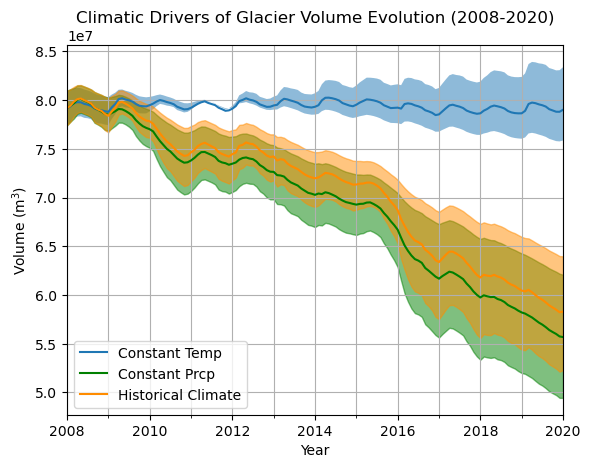

In [47]:
f,ax=plt.subplots()

# Constant Temp
vols=[]
vols_percent_constant_temp = []
for tb in df_raw.temp_bias:
    suf=f'_constant_temp_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        vols.append(vol)
        vol_percent = vol.sel(time=2008) - vol 
        vol_percent /= vol.sel(time=2008)
        vol_percent *=100
        vols_percent_constant_temp.append(vol_percent)
        ds.close() 

vol_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='Constant Temp',ax=ax)
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5)

# Constant Prcp
vols=[]
vols_percent_constant_prcp = []
for tb in df_raw.temp_bias:
    suf=f'_constant_prcp_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        vols.append(vol)
        vol_percent = vol.sel(time=2008) - vol 
        vol_percent /= vol.sel(time=2008)
        vol_percent *=100
        vols_percent_constant_prcp.append(vol_percent)
        ds.close() 

vol_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='Constant Prcp',ax=ax,color='green')
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5,color='green')

# Historical Climate
vols=[]
for tb in df_raw.temp_bias:
    suf=f'_historical_tb{tb}'

    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol=ds.volume_m3
        vols.append(vol)
        ds.close() 

vol_mean = xr.zeros_like(vols[0])
_vols = [v.data for v in vols]
vol_mean.data = np.mean(_vols,axis=0)

vol_mean.plot(label='Historical Climate',ax=ax, color='darkorange')
ax.fill_between(vol_mean.time.values, vols[0].values,y2=vols[-1].values,alpha=0.5, color='darkorange');



plt.legend()
plt.title('Climatic Drivers of Glacier Volume Evolution (2008-2020)');
plt.xlabel('Year');
plt.ylabel('Volume (m$^3$)');
ax.set_xticks(np.arange(2008,2021), labels=['' for i in np.arange(2008,2021)], minor=True, rotation=0);
ax.set_xlim([2008,2020])
plt.grid(which='both');

In [66]:
## View Percent Volume Loss ##
_vols = [v.data for v in vols_percent_with_calving]
vol_mean.data = np.mean(_vols,axis=0)
a,b,c = vol_mean.data[-1],vols_percent_with_calving[0].data[-1],vols_percent_with_calving[-1].data[-1]
a-b,a-c,a,b,c

(3.0187303824229765,
 -2.319783556529437,
 31.14025966324543,
 28.121529280822454,
 33.46004321977487)

In [233]:
path = os.path.join(OUTPUTS, 'historical_glacier_simulation_climate_sensitivity.png')
f.savefig(path)

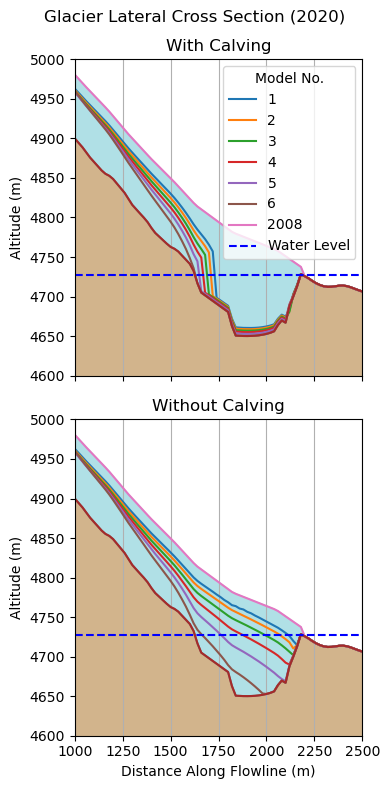

In [88]:
k=  1.2
yr = 2018 # 2018 or 2017
wl_cal = 4727 

profile_yr = 2020 # any year (for visualizing lateral cross section
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,8),sharex=True)
for i,tb in enumerate(df_raw.temp_bias.values):
    # Plot velocity Profile
    # df_v_inv[['millan_v', #f'OGGM_inversion_velocity_tb{tb}',
    #           #f'OGGM_Run_velocity_tb{tb}_2017',
    #           f'OGGM_Run_velocity_tb{tb}_2018']].plot(ax=ax,legend=False)
    # ax.plot(df_v_inv[f'OGGM_Run_velocity_tb{tb}_calving_{k}_{yr}'], label = str(tb))
    
    # ax.set_title('OGGM Velocities vs. Millan');
    # ax.set_ylabel('Surface Velocity (ma$^-$$^1$)');
    
    # Plot THickness Cross section - with calving
    suf=f'_tb{tb}_calving_{k}'
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
        ds_fl_ = ds_fl.load()
    

    ds_fl = ds_fl_.sel(time=profile_yr).copy()
    ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
    surf = (ds_fl.thickness_m + ds_fl.bed_h)#.where(ds_fl.ice_velocity_myr >0)
    surf.plot(ax=ax1, label=f'{i+1}')
    #ds_fl.bed_h.plot(ax=ax1,label=f'{tb}')
    
    if tb == df_raw.temp_bias.values.min():
        
        ds_fl = ds_fl_.sel(time=2008).copy()
        ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
        surf = ds_fl.thickness_m + ds_fl.bed_h
        
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
        surf.plot(ax=ax1, label='2008')
        ds_fl.bed_h.plot(ax=ax1)


    elif tb == df_raw.temp_bias.values.max():
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')

  
    #Plot THickness Cross section - Without calving
    suf=f'_historical_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
        ds_fl_ = ds_fl.load()
    

    ds_fl = ds_fl_.sel(time=profile_yr).copy()
    ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
    surf = ds_fl.thickness_m + ds_fl.bed_h
    surf.plot(ax=ax2, label=f'{tb}')
    #ds_fl.bed_h.plot(ax=ax1,label=f'{tb}')
    
    if tb == df_raw.temp_bias.values.min():
        
        ds_fl = ds_fl_.sel(time=2008).copy()
        ds_fl = ds_fl.where(ds_fl.dis_along_flowline<=3000).copy()
        surf = ds_fl.thickness_m + ds_fl.bed_h
        
        ax2.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
        surf.plot(ax=ax2, label='2008')
        ds_fl.bed_h.plot(ax=ax2)
        
    elif tb == df_raw.temp_bias.values.max():
        ax1.fill_between(x=ds_fl.dis_along_flowline.values,y2=ds_fl.bed_h.values,y1=surf.values,color='powderblue')
    

for axis in [ax1,ax2]:
    ds_fl.bed_h.plot(ax=axis,color='brown')
    axis.fill_between(x=ds_fl.dis_along_flowline.values,y1=ds_fl.bed_h.values,y2=4600,color='tan')
    axis.axhline(wl_cal,linestyle='--',color='blue',label='Water Level');
    axis.set_ylim([4600,5000]);
    axis.set_xlim([1000,2500]);
    axis.set_ylabel('Altitude (m)');
    axis.grid(axis='x')
    
# ax1.legend(title='Glacier Surface',loc ='upper right')#(1.1,0.05));
ax1.set_title('With Calving');
ax2.set_title('Without Calving');


# ax.plot(df_v_inv.millan_v,color='k',linestyle='--',label='Millan')
# ax.legend();

ax2.set_xlabel('Distance Along Flowline (m)');
ax1.set_xlabel('');
# ax.set_xlabel('Distance Along Flowline (m)');
# ax.set_xlim([0,2200]);
# ax.set_ylim([0,50]);
# ax.set_xticks(np.arange(0,2400,400), labels=np.arange(0,2400,400), rotation=0)
# ax.set_xticks(np.arange(200,2400,400), labels=['' for i in np.arange(200,2400,400)], minor=True, rotation=0)
# ax.grid(which='both');

ax1.legend(title='Model No.',ncols=1,loc='upper right');
f.suptitle(f'Glacier Lateral Cross Section ({profile_yr})');
plt.tight_layout()


In [89]:
path = os.path.join(OUTPUTS, 'Glacier_lat_cross_sections.png')
f.savefig(path)

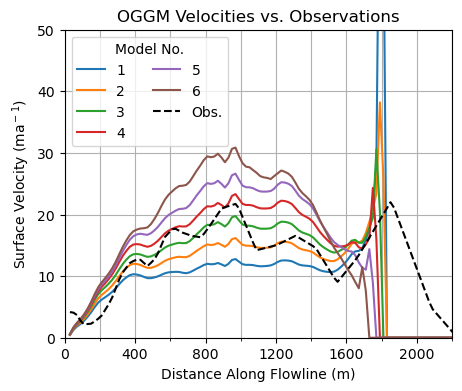

In [68]:
k=  1.2
yr = 2018 # 2018 or 2017
wl_cal = 4727 

f,ax=plt.subplots(figsize=(5,4),sharex=True)
for i,tb in enumerate(df_raw.temp_bias.values):
    #Plot velocity Profile
    ax.plot(df_v_inv[f'OGGM_Run_velocity_tb{tb}_calving_{k}_{yr}'], label = str(i+1))
    
    ax.set_title('OGGM Velocities vs. Millan');
    ax.set_ylabel('Surface Velocity (ma$^-$$^1$)');
    # df_v_inv[['millan_v', #f'OGGM_inversion_velocity_tb{tb}',
    #           #f'OGGM_Run_velocity_tb{tb}_2017',
    #           f'OGGM_Run_velocity_tb{tb}_2018']].plot(ax=ax,legend=False)    
    ax.set_title('OGGM Velocities vs. Observations');
    ax.set_ylabel('Surface Velocity (ma$^-$$^1$)');

ax.plot(df_v_inv.millan_v,color='k',linestyle='--',label='Obs.')
ax.legend(title='Model No.',ncols=2,loc='upper left');
ax.set_xlabel('Distance Along Flowline (m)');
ax.set_xlim([0,2200]);
ax.set_ylim([0,50]);
ax.set_xticks(np.arange(0,2400,400), labels=np.arange(0,2400,400), rotation=0)
ax.set_xticks(np.arange(200,2400,400), labels=['' for i in np.arange(200,2400,400)], minor=True, rotation=0)
ax.grid(which='both');

In [69]:
path = os.path.join(OUTPUTS, 'Glacier_velocity_profile.png')
f.savefig(path)

#### Lake Depth

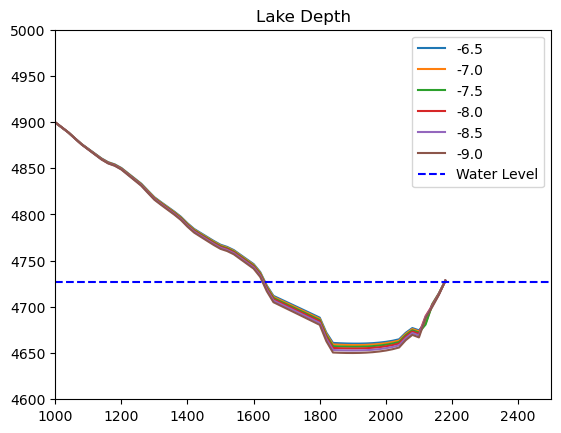

In [24]:
wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
depths=[]
for i in range(len(df_raw)): #
    tb=df_raw.iloc[i].temp_bias
    fls=gdir.read_pickle('inversion_output',filesuffix=f'tb{tb}')[0]
    thk=fls['thick']
    surf=fls['hgt']
    bed=surf-thk
    dis = fls['dx']*np.arange(len(thk))
    lake_depth =  wl_cal - bed
    depths.append(lake_depth)
    plt.plot(dis,bed,label=tb)
    #plt.plot(dis,surf)
    
#plt.xlim([1500,2300]) 
#plt.ylim([-100,100]) 
plt.ylim([4600,5000]);
plt.xlim([1000,2500]);
plt.hlines(wl_cal,xmin=1000,xmax=2500,linestyle='--',color='blue',label='Water Level');
plt.title('Lake Depth');
plt.legend();

In [31]:
for tb,depth in zip(df_raw.temp_bias,depths):
    bath = depth[np.where(depth>=0)]
    print(f'{tb} | Max: {bath.max()}, Mean: {bath.mean()}')

-6.5 | Max: 66.75327856271178, Mean: 45.6641442938886
-7.0 | Max: 68.33921383997131, Mean: 46.92502278048047
-7.5 | Max: 70.14173298548758, Mean: 48.354659007833746
-8.0 | Max: 72.01890054464275, Mean: 49.450451268126216
-8.5 | Max: 74.22563713389718, Mean: 51.171110530923116
-9.0 | Max: 76.92204768838656, Mean: 53.26862754625472


### Typical Annual Mass Balance Cycle

In [179]:
melt_anom

1     0.629259
2     0.973325
3     0.313578
4    -0.371822
5    -0.946191
6    -1.823805
7    -1.191558
8       0.8175
9    -0.624276
10   -0.024447
11    1.434361
12    0.814076
Name: Ablation, dtype: object

<Axes: >

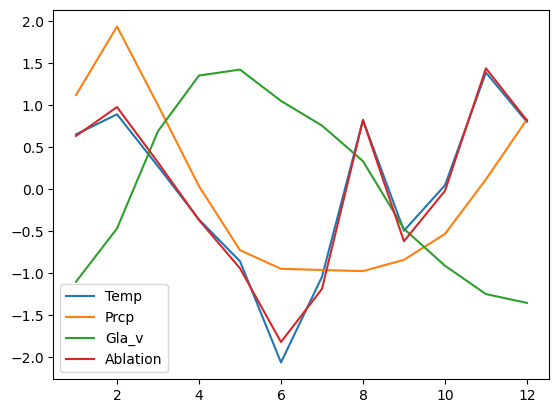

In [180]:
# Get climate
temp_ts=  df_temp_m.loc[2008:2020].mean(axis=0)
temp_anom = temp_ts - temp_ts.mean()
temp_anom /=temp_ts.std()
temp_anom.name = 'Temp'
#temp_anom.plot(ax=ax,label='Temperature',color='orange',linestyle='-.');

prcp_ts=  df_prcp_m.loc[2008:2020].mean(axis=0)
prcp_anom = prcp_ts - prcp_ts.mean()
prcp_anom /=prcp_ts.std()
prcp_anom.name = 'Prcp'

melt_ts=  df_tmelt_m.loc[2008:2020].mean(axis=0)
melt_anom = melt_ts - melt_ts.mean()
melt_anom /=melt_ts.std()
melt_anom.name = 'Ablation'
#prcp_anom.plot(ax=ax,label='Precipitation');

# Get relatively stable model run
suf=f'_constant_temp_tb-8.0'

with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
    ds=ds.load()
    v_ts = ds.groupby('calendar_month').mean().volume_m3
    ds.close()
    
v_anom = v_ts - v_ts.mean()
v_anom /=v_ts.std()
v_anom = v_anom.to_pandas()
v_anom.name = 'Gla_v'
#v_anom.plot(ax=ax,label='Glacier Volume',color='k');

df_ = pd.concat([temp_anom,prcp_anom,v_anom,melt_anom],axis=1)
df_.plot()
# df_['Month']=df_.index.values
# df_['Hydro_Month']=[month-9 if month>=10 else month+3 for month in df_.Month]
# df_.set_index('Hydro_Month').sort_values(by='Hydro_Month')[['Temp','Prcp','Gla_v']].plot()
# plt.xticks(np.arange(1,13),labels=['O','N','D','J','F','M','A','M','J','J','A','S']);
#pd.DataFrame(index=np.arange(1,13),columns=['Temp','Prcp','Gla_v'],data=[temp_anom,prcp_anom,v_anom])

# ax.legend();
# ax.set_ylabel('Anomaly from Annual Ave.'); # from average of 12 months, which are averages from the complete timeseries
# ax.grid();


In [145]:
temp_anom.name = 'Temp'
temp_anom

1     0.647459
2     0.886589
3     0.267033
4    -0.365606
5    -0.862524
6    -2.067489
7    -1.048004
8     0.819673
9    -0.499346
10    0.041596
11    1.384013
12    0.796605
Name: Temp, dtype: object

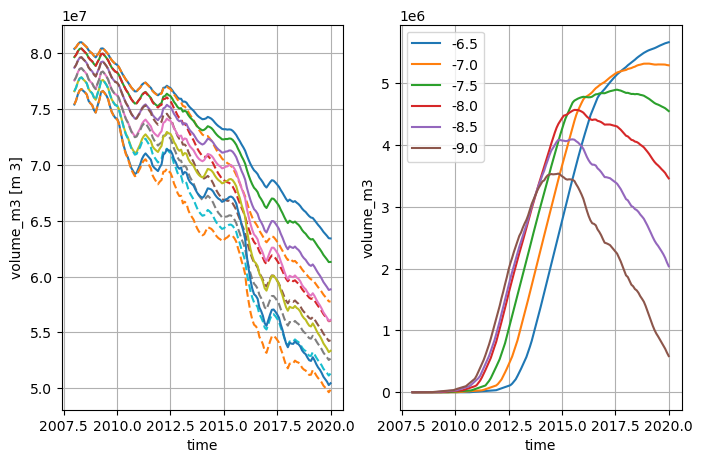

In [100]:
f,(ax,ax1) = plt.subplots(1,2,figsize=(8,5),sharey=False)
for tb in df_raw.temp_bias:
    
    # No Calving
    suf=f'_historical_tb{tb}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol_nc=ds.volume_m3
        length=ds.length_m
        ds.close()    
    vol_nc.plot(ax=ax)
    
    # Calving
    suf=f'_tb{tb}_calving_{k}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
        vol_wc=ds.volume_m3
        length=ds.length_m
        ds.close()    
    vol_wc.plot(linestyle='--',label=str(tb),ax=ax)

    vol_dif = vol_nc - vol_wc
    vol_dif.plot(ax=ax1,label=str(tb))

ax1.legend();
ax1.grid()
ax.grid()

In [231]:
model = tasks.run_from_climate_data(gdir,
                        mb_elev_feedback='monthly',# init_model_filesuffix='_1962_spinup_bias0',
                        store_monthly_step=True,calving_k=k, calving_law=k_calving_law,
                        ys=2008,ye=2020,water_level=wl_cal,evolution_model =FluxBasedModel,
                        output_filesuffix='_delete_this')

In [235]:
model.calving_k

3.1709791983764586e-08

In [237]:
cfg.PARAMS['calving_k']

0.6

In [239]:
1/cfg.SEC_IN_YEAR

3.1709791983764586e-08

## Analyze Results

In [12]:
# Set some params if not already set
cfg.PARAMS['use_kcalving_for_run']=True
gdir.is_tidewater=True
gdir.is_lake_terminating=True
wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
k=1.0 # calving constant unless I want to iterate later

2024-07-11 10:08:32: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.


In [7]:
df_v_inv= pd.read_csv(OUTPUTS+'model_flowline_results.csv',index_col=0)
df_cal_res= pd.read_csv(OUTPUTS+'calibration_results.csv',index_col=0)
df_v_inv.head()

widths_m      area_m2  millan_v  \
dis_along_flowline                                      
30.0                 16.127807   322.556137  4.160244   
50.0                 51.945130  1038.902593  4.073063   
70.0                139.721297  2794.425936  3.681951   
90.0                316.128054  6322.561080  2.772401   
110.0               471.154952  9423.099030  2.166152   

                    OGGM_inversion_velocity_tb-6.5  \
dis_along_flowline                                   
30.0                                      2.181344   
50.0                                      2.870140   
70.0                                      4.305730   
90.0                                      4.424561   
110.0                                     4.821568   

                    OGGM_inversion_velocity_tb-7.0  \
dis_along_flowline                                   
30.0                                      2.326818   
50.0                                      3.067225   
70.0                                      4.572992   
90.0                                      4.741712   
110.0                                     5.187115   

                    OGGM_inversion_velocity_tb-7.5  \
dis_along_flowline                                   
30.0                                      2.437661   
50.0                                      3.215128   
70.0                                      4.762380   
90.0                                      4.969505   
110.0                                     5.450090   

                    OGGM_inversion_velocity_tb-8.0  \
dis_along_flowline                                   
30.0                                      2.537145   
50.0                                      3.347391   
70.0                                      4.928860   
90.0                                      5.166734   
110.0                                     5.672357   

                    OGGM_inversion_velocity_tb-8.5  \
dis_along_flowline                                   
30.0                                      2.622666   
50.0                                      3.460537   
70.0                                      5.068630   
90.0                                      5.332988   
110.0                                     5.860403   

                    OGGM_inversion_velocity_tb-9.0  \
dis_along_flowline                                   
30.0                                      2.701705   
50.0                                      3.564826   
70.0                                      5.197009   
90.0                                      5.484191   
110.0                                     6.029177   

                    OGGM_Run_velocity_tb-6.5_2017  ...  \
dis_along_flowline                                 ...   
30.0                                     0.409302  ...   
50.0                                     1.178175  ...   
70.0                                     1.688901  ...   
90.0                                     2.067518  ...   
110.0                                    2.583544  ...   

                    OGGM_Run_velocity_tb-9.0_calving_1.2_2017  \
dis_along_flowline                                              
30.0                                                 0.556481   
50.0                                                 1.590167   
70.0                                                 2.307096   
90.0                                                 2.883221   
110.0                                                3.637741   

                    OGGM_Run_velocity_tb-9.0_calving_1.2_2018  \
dis_along_flowline                                              
30.0                                                 0.583738   
50.0                                                 1.670873   
70.0                                                 2.430326   
90.0                                                 3.030360   
110.0                                                3.796280   

                    OGGM_Run_

In [8]:
df_cal_res.head()

Unnamed: 0          rgi_id  bias    melt_f  prcp_fac  temp_bias  \
0        -6.5  RGI60-16.02060     0  1.735991       2.5       -6.5   
1        -7.0  RGI60-16.02060     0  2.577051       2.5       -7.0   
2        -7.5  RGI60-16.02060     0  3.870401       2.5       -7.5   
3        -8.0  RGI60-16.02060     0  5.919010       2.5       -8.0   
4        -8.5  RGI60-16.02060     0  9.313196       2.5       -8.5   

   reference_mb  reference_mb_err       reference_period  \
0   -442.154506               NaN  1962-01-01_2009-01-01   
1   -442.154506               NaN  1962-01-01_2009-01-01   
2   -442.154506               NaN  1962-01-01_2009-01-01   
3   -442.154506               NaN  1962-01-01_2009-01-01   
4   -442.154506               NaN  1962-01-01_2009-01-01   

                             baseline_climate_source  ...    Val_ME  \
0  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.290560   
1  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.294803   
2  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.299645   
3  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.303545   
4  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - T...  ...  0.309351   

     Val_MAE   Val_RMSE  Inversion_Volume  Mean_Thickness_Below_5100m  \
0  24.013545  34.518850      8.096665e+07                   73.592180   
1  24.179261  34.799697      8.020542e+07                   73.576989   
2  24.374505  35.128244      7.948764e+07                   73.564689   
3  24.555124  35.415304      7.880863e+07                   73.547654   
4  24.809969  35.822816      7.811494e+07                   73.536119   

   Flowline_Thickness  apparent_mb_from_any_mb_residual  mean_u_surf_m_per_a  \
0           66.620696                        442.154506            16.809282   
1           66.680584                        442.154506            21.340836   
2           66.804331                        442.154506            26.247678   
3           66.837857                        442.154506            31.515443   
4           67.069114                        442.154506            37.285912   

   max_u_surf_m_per_a  min_u_surf_m_per_a  
0           26.949752            2.181344  
1           34.438708            2.326818  
2           42.814114            2.437661  
3           52.575029            2.537145  
4           63.523590            2.622666  

[5 rows x 22 columns]

In [ ]:
# Calibrate Mass Balance Parameters
fls=gdir.read_pickle('inversion_flowlines')
years=np.arange(y0,y1+1)
f,(ax,ax2)=plt.subplots(1,2,figsize=(10,5))
tt=[]
pp=[]
melt_fs=[]
prcp_fs=[]
temp_bs=[]
mean_elas=[]
# cols = ['rgi_id',
#         'bias',
#         'melt_f',
#         'prcp_fac',
#         'temp_bias',
#         'reference_mb',
#         'reference_mb_err',
#         'reference_period',
#         'baseline_climate_source']
mbdf=pd.DataFrame()
temp_biases=np.arange(6.5,9.1,0.5)*-1
for tb in temp_biases:
    try:
        mb_params = mb_calibration_from_scalar_mb(gdir, ref_mb=smb, ref_mb_years = (y0,y1+1),
                                    overwrite_gdir=True,
                                    prcp_fac=2.5,
                                    temp_bias = tb,
                                    prcp_fac_max = 10.0,
                                    prcp_fac_min = 0.1,
                                    melt_f_min = 1.5,
                                    calibrate_param1='melt_f',
                                    #calibrate_param3='temp_bias',
                                    calibrate_param2='prcp_fac'
                                     )
        #_=mb_params.pop('Unnamed: 0')
        global_params=mb_params.pop('mb_global_params')
        mbdf[f'{tb}']=mb_params
        melt_fs.append(mb_params['melt_f'])
        prcp_fs.append(mb_params['prcp_fac'])
        temp_bs.append(mb_params['temp_bias'])

        mbmod=MonthlyTIModel(gdir)
        smb1=mbmod.get_specific_mb(fls=fls, year=np.arange(y0,y1+1))
        elas=mbmod.get_ela(year=np.arange(y0,y1+1))
        mean_elas.append(np.mean(elas))
        temps=[]
        prcps=[]
        for yr in np.arange(y0,y1+1):
            temp,_,prcp,_=mbmod.get_annual_climate(heights=[5000], year=yr)
            temps.append(temp)
            prcps.append(prcp)
        tt.append(temps)
        pp.append(prcps)
        ax2.plot(np.arange(y0,y1+1),smb1,
                 label=f'tb:{round(mb_params['temp_bias'],1)}, mf:{round(mb_params['melt_f'],2)}, pf:{round(mb_params['prcp_fac'],1)}')

    
    except RuntimeError:
        #mb_cals.append(np.nan)
        melt_fs.append(np.nan)
        prcp_fs.append(np.nan)
        temp_bs.append(np.nan)


ax.plot(temp_bs,melt_fs);
ax.set_xlabel('Temp Bias');
ax1=ax.twinx()
ax1.plot(temp_bs,prcp_fs,color='k');
ax2.legend(loc=(1.2,0.));
ax2.grid()
ax2.set_ylabel('SMB (kg m$^-$$^2$a$^-$$^1$)');
ax2.set_xlabel('Year');



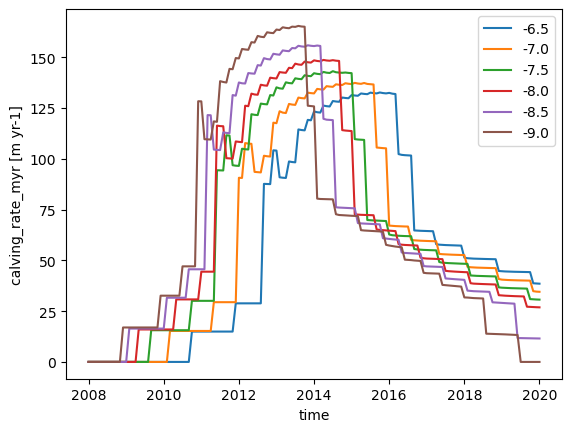

In [237]:
for tb in df_raw.temp_bias.values:
    suf=f'_tb{tb}_calving_{k}'
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds=ds.load()
    ds.calving_rate_myr.plot(label=tb)
plt.legend();

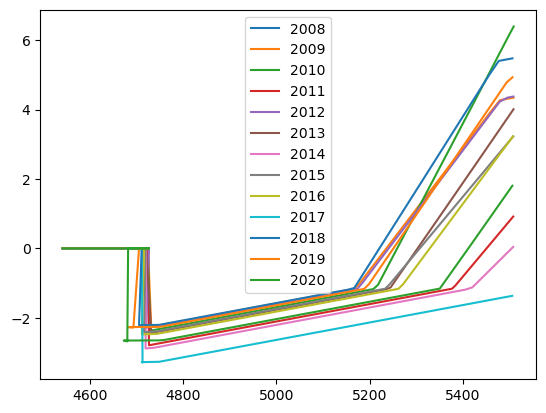

In [46]:
tb=-5.0
k=1.0
years=np.arange(2008,2021)
suf=f'_tb{tb}_calving_{k}'
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix=suf), group='fl_0') as ds_fl:
    for yr in years:
        ds_fls = ds_fl.load().sel(time=yr)
        surf=ds_fls.bed_h.values+ds_fls.thickness_m.values
        plt.plot(surf, ds_fls.climatic_mb_myr.values,label=yr);
plt.legend();

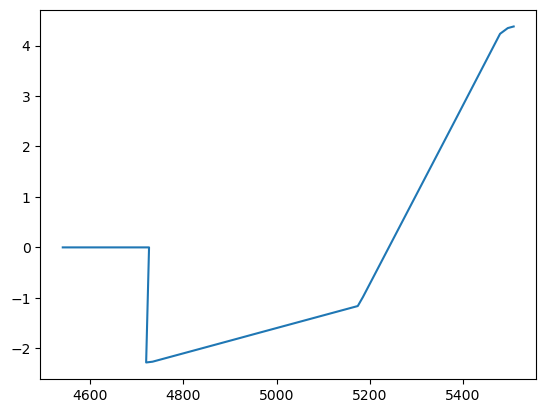

In [43]:
surf=ds_fl.bed_h.values+ds_fl.thickness_m.values
plt.plot(surf, ds_fl.climatic_mb_myr.values);

In [69]:
cfg.PATHS['climate_file'] = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/PISCO/CH_PISCO_Clim_OGGM_ready_1.nc' # This filepath has the correct units on each datavar
with xr.open_dataset(gdir.get_filepath('climate_historical'),) as nc:
    nc.load()
nc

<xarray.Dataset>
Dimensions:  (time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2020-12-01
Data variables:
    prcp     (time) float32 180.4 138.9 135.5 65.27 ... 12.09 20.01 62.1 111.2
    temp     (time) float32 7.448 7.6 7.459 7.389 ... 7.972 7.794 9.263 8.25
Attributes:
    ref_hgt:         4943.0
    ref_pix_lon:     -77.25
    ref_pix_lat:     -9.790000000000001
    ref_pix_dis:     557.671316822772
    climate_source:  CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - The Ohio St...
    yr_0:            1901
    yr_1:            2020
    author:          OGGM
    author_info:     Open Global Glacier Model

In [58]:
_cenlon, _cenlat = gdir.cenlon, gdir.cenlat

(-77.24380720543019, -9.784778186098325)

1962 outline center lat lon: (-77.24555894158757, -9.787550525686378)

In [91]:
gdir.read_json('mb_calib')

{'Unnamed: 0': -9.0,
 'rgi_id': 'RGI60-16.02060',
 'bias': 0,
 'melt_f': 15.31347115992092,
 'prcp_fac': 2.5,
 'temp_bias': -9.0,
 'reference_mb': -442.1545060371504,
 'reference_mb_err': nan,
 'reference_period': '1962-01-01_2009-01-01',
 'baseline_climate_source': 'CRU TS4.04+/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/PISCO/CH_PISCO_Clim_OGGM_ready_1.nc',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0}}

In [95]:
mbmod=MonthlyTIModel(gdir)
mbmod.melt_f

15.31347115992092